In [137]:
# creare csv con file path e path audio corrispondente CON BABELE
# dataset è composto da video_path, audio_path (estratto), label {0: eng, 1: ita, 2: sp, 3: fr}

import os
import glob
import subprocess
import torch

os.environ["ACCELERATE_MIXED_PRECISION"] = "no"
os.environ.pop("USE_FP16", None)
os.environ.setdefault("PYTORCH_MPS_HIGH_WATERMARK_RATIO", "0.0")
device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")
print(f"Device: {device}")

dataset_dir = "/Users/ludovicagenovese/Documents/GitHub/mothertongueVSspoken/BABELE"
audio_dir   = os.path.join(dataset_dir, "audio_wav")
csv_path    = os.path.join(dataset_dir, "dataset.csv")
os.makedirs(audio_dir, exist_ok=True)

video_paths = glob.glob(os.path.join(dataset_dir, "**/*.mp4"), recursive=True)

rows = []
for vp in video_paths:
    if   "English" in vp: label = 0
    elif "Italian" in vp: label = 1
    #elif "French"  in vp: label = 3
    elif "Spanish" in vp: label = 2
    else:
        print("Lingua non riconosciuta → salto:", vp)
        continue

    fname = os.path.splitext(os.path.basename(vp))[0]
    wav   = os.path.join(audio_dir, f"{fname}{label}language.wav")

    if not os.path.exists(wav):
        res = subprocess.run(
            ["ffmpeg", "-i", vp, "-ar", "16000", "-ac", "1",
             "-f", "wav", "-vn", wav],
            stdout=subprocess.DEVNULL, stderr=subprocess.DEVNULL
        )
        if res.returncode != 0:
            print("ffmpeg errore → salto:", vp)
            continue        # non appendere se fallita conversione

    rows.append({"audio_path": wav, "video_path": vp, "label": label})


if not os.path.exists(csv_path):
    import pandas as pd
    pd.DataFrame(rows).to_csv(csv_path, index=False)
    print(f"CSV creato: {csv_path}")




Device: mps
Lingua non riconosciuta → salto: /Users/ludovicagenovese/Documents/GitHub/mothertongueVSspoken/BABELE/French/8_1_2_3_25.mp4
Lingua non riconosciuta → salto: /Users/ludovicagenovese/Documents/GitHub/mothertongueVSspoken/BABELE/French/8_2_1_5_25.mp4
Lingua non riconosciuta → salto: /Users/ludovicagenovese/Documents/GitHub/mothertongueVSspoken/BABELE/French/8_2_1_7_25.mp4
Lingua non riconosciuta → salto: /Users/ludovicagenovese/Documents/GitHub/mothertongueVSspoken/BABELE/French/8_1_2_1_25.mp4
Lingua non riconosciuta → salto: /Users/ludovicagenovese/Documents/GitHub/mothertongueVSspoken/BABELE/French/8_2_2_2_50.mp4
Lingua non riconosciuta → salto: /Users/ludovicagenovese/Documents/GitHub/mothertongueVSspoken/BABELE/French/8_1_1_2_25.mp4
Lingua non riconosciuta → salto: /Users/ludovicagenovese/Documents/GitHub/mothertongueVSspoken/BABELE/French/8_2_2_4_25.mp4
Lingua non riconosciuta → salto: /Users/ludovicagenovese/Documents/GitHub/mothertongueVSspoken/BABELE/French/8_1_2_5_25.

In [138]:
# QUESTO PER EMODB!!!!
# 
#  creare csv con file path e path audio corrispondente CON BABELE
# dataset è composto da video_path, audio_path (estratto), label {0: eng, 1: ita, 2: sp, 3: fr}

import os
import glob
import subprocess
import torch


os.environ["ACCELERATE_MIXED_PRECISION"] = "no"
os.environ.pop("USE_FP16", None)
os.environ.setdefault("PYTORCH_MPS_HIGH_WATERMARK_RATIO", "0.0")
device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")
print(f"Device: {device}")

dataset_dir = "/Users/ludovicagenovese/Documents/GitHub/mothertongueVSspoken/EMODB"
audio_dir   = os.path.join(dataset_dir, "audio_wav")
csv_path    = os.path.join(dataset_dir, "dataset.csv")
os.makedirs(audio_dir, exist_ok=True)

video_paths = glob.glob(os.path.join(dataset_dir, "**/*.mp4"), recursive=True) + \
              glob.glob(os.path.join(dataset_dir, "**/*.MOV"), recursive=True)

rows = []
for vp in video_paths:
    if   "EN" in vp: label = 0
    elif "IT" in vp: label = 1
    #elif "French"  in vp: label = 3
    elif "SP" in vp: label = 2
    else:
        print("Lingua non riconosciuta → salto:", vp)
        continue

    fname = os.path.splitext(os.path.basename(vp))[0]
    wav   = os.path.join(audio_dir, f"{fname}{label}language.wav")

    if not os.path.exists(wav):
        res = subprocess.run(
            ["ffmpeg", "-i", vp, "-ar", "16000", "-ac", "1",
             "-f", "wav", "-vn", wav],
            stdout=subprocess.DEVNULL, stderr=subprocess.DEVNULL
        )
        if res.returncode != 0:
            print("ffmpeg errore → salto:", vp)
            continue        # non appendere se fallita conversione

    rows.append({"audio_path": wav, "video_path": vp, "label": label})


if not os.path.exists(csv_path):
    import pandas as pd
    pd.DataFrame(rows).to_csv(csv_path, index=False)
    print(f"CSV creato: {csv_path}")




Device: mps


In [139]:
#per adesso solo ita, eng, e spa - BABELE!!!
#FATTIBILITA' DI WHISPER NEL POTER RICONOSCERE LE LINGUE CON SOLO ZERO - SHOT, - VERSIONE CON 10 SECONDI che parte da metà video

import whisper, pandas as pd, torch, soundfile as sf, json
from sklearn.metrics import classification_report, confusion_matrix
from tqdm import tqdm

MODEL_NAME = "small"
CSV        = "/Users/ludovicagenovese/Documents/GitHub/mothertongueVSspoken/BABELE/dataset.csv"

id2lang = {0: "en", 1: "it", 2: "es"}

# carica whisper - small, più piccolo ma comunque robusto per riconoscere
model  = whisper.load_model("small")
device = model.device

# carica il dataset con path dell'audio e poi ricalcola i label per farli combaciare con whisper
# ricorda 0: english, 1: italian, 2: spanish
df = pd.read_csv(CSV, usecols=["audio_path", "label"])
df["label"] = df["label"].map(id2lang)       

preds, golds, probs_history = [], [], []
SR          = 16000
DUR_SECONDS = 10
DUR_SAMPLES = DUR_SECONDS * SR


# loop che ci calcola se whisper li riconosce o meno
for wav, true_lang in tqdm(df.itertuples(index=False), total=len(df), desc="LID"):
    audio, sr = sf.read(wav)
    if sr != 16000:
        raise ValueError(f"{wav}: campionamento ≠16 kHz")
    
    total_samples = audio.shape[0]
    mid = total_samples // 2
    start = max(mid - DUR_SAMPLES//2, 0)
    end   = start + DUR_SAMPLES
    clip = torch.from_numpy(audio[start:end]).float().to(device)
    start_s, end_s = start/SR, end/SR
    segments = [(start_s, end_s)]

    clip30 = whisper.pad_or_trim(clip)
    mel   = whisper.log_mel_spectrogram(clip30).to(device)

    _, probs = model.detect_language(mel) 
    pred_lang = max(probs, key=probs.get)

    preds.append(pred_lang)
    golds.append(true_lang)
    probs_history.append(probs)

labels = ["en", "it", "es"]

print(classification_report(
        golds, preds,
        labels      = labels,  
        target_names= labels,
        digits=3))

print("Confusion matrix\n",
      confusion_matrix(golds, preds, labels=labels))




ModuleNotFoundError: No module named 'whisper'

In [29]:
#per adesso solo ita, eng, e spa - EMODB!!!
#FATTIBILITA' DI WHISPER NEL POTER RICONOSCERE LE LINGUE CON SOLO ZERO - SHOT, - VERSIONE CON 10 SECONDI che parte da metà video

import whisper, pandas as pd, torch, soundfile as sf, json
from sklearn.metrics import classification_report, confusion_matrix
from tqdm import tqdm

MODEL_NAME = "small"
CSV        = "/Users/ludovicagenovese/Documents/GitHub/mothertongueVSspoken/EMODB/dataset.csv"

id2lang = {0: "en", 1: "it", 2: "es"}

# carica whisper - small, più piccolo ma comunque robusto per riconoscere
model  = whisper.load_model("small")
device = model.device

# carica il dataset con path dell'audio e poi ricalcola i label per farli combaciare con whisper
# ricorda 0: english, 1: italian, 2: spanish
df = pd.read_csv(CSV, usecols=["audio_path", "label"])
df["label"] = df["label"].map(id2lang)       

preds, golds, probs_history = [], [], []
SR          = 16000
DUR_SECONDS = 10
DUR_SAMPLES = DUR_SECONDS * SR


# loop che ci calcola se whisper li riconosce o meno
for wav, true_lang in tqdm(df.itertuples(index=False), total=len(df), desc="LID"):
    audio, sr = sf.read(wav)
    if sr != 16000:
        raise ValueError(f"{wav}: campionamento ≠16 kHz")
    
    total_samples = audio.shape[0]
    mid = total_samples // 2
    start = max(mid - DUR_SAMPLES//2, 0)
    end   = start + DUR_SAMPLES
    clip = torch.from_numpy(audio[start:end]).float().to(device)
    start_s, end_s = start/SR, end/SR
    segments = [(start_s, end_s)]

    clip30 = whisper.pad_or_trim(clip)
    mel   = whisper.log_mel_spectrogram(clip30).to(device)

    _, probs = model.detect_language(mel) 
    pred_lang = max(probs, key=probs.get)

    preds.append(pred_lang)
    golds.append(true_lang)
    probs_history.append(probs)

labels = ["en", "it", "es"]

print(classification_report(
        golds, preds,
        labels      = labels,  
        target_names= labels,
        digits=3))

print("Confusion matrix\n",
      confusion_matrix(golds, preds, labels=labels))




LID: 100%|██████████| 21/21 [00:10<00:00,  2.07it/s]

              precision    recall  f1-score   support

          en      1.000     0.857     0.923         7
          it      1.000     1.000     1.000         7
          es      1.000     1.000     1.000         7

   micro avg      1.000     0.952     0.976        21
   macro avg      1.000     0.952     0.974        21
weighted avg      1.000     0.952     0.974        21

Confusion matrix
 [[6 0 0]
 [0 7 0]
 [0 0 7]]


In [ ]:
# EXTRACT TEACHER PER EMODB - SOLO PER TESTING!!!! QUINDI STRAI I LOGITS E POI METTI I VIDEO MOUTH

import whisper, torch, soundfile as sf, json, numpy as np, pandas as pd
from tqdm import tqdm

# ───── Config ─────────────────────────────────────────────
MODEL   = "small"
SR      = 16000
CLIP_S  = 10
CLIP_N  = CLIP_S * SR
CSV_IN  = "/Users/ludovicagenovese/Documents/GitHub/mothertongueVSspoken/EMODB/dataset.csv"                # video_path,audio_path,label,segments
CSV_OUT = "/Users/ludovicagenovese/Documents/GitHub/mothertongueVSspoken/EMODB/distillation_dataset.csv"
id2lang = {0: "en", 1: "it", 2: "es"}

model  = whisper.load_model(MODEL)
device = model.device

rows = []
ds = pd.read_csv(CSV_IN)
for vid, wav, lbl in tqdm(ds[["video_path","audio_path","label"]].values,
                          total=len(ds), desc="Teacher"):

    audio, sr = sf.read(wav)
    if sr != SR:
        raise ValueError(f"{wav}: samplerate ≠ {SR} Hz")
    if audio.ndim == 2:
        audio = audio.mean(1)

    # ——— clip centrale di 10 s ———
    mid   = len(audio) // 2
    start = max(mid - CLIP_N//2, 0)
    end   = min(start + CLIP_N, len(audio))
    clip  = torch.from_numpy(audio[start:end]).float().to(device)
    clip  = whisper.pad_or_trim(clip)             # esattamente 10 s

    # ——— Whisper inference ———
    mel   = whisper.log_mel_spectrogram(clip).to(device)
    with torch.no_grad():
        _, probs = model.detect_language(mel)     # 99-way
        enc      = model.encoder(mel.unsqueeze(0))

    # embedding medio (Whisper-small → 768 d)
    enc_seq = enc.squeeze(0).cpu().numpy()           # [Tₐ, 768]
    emb     = enc_seq.mean(0)                        # [768]

    # normalizza SOLO en/it/es  (somma = 1)
    s = probs["en"] + probs["it"] + probs["es"]
    probs3 = {k: float(probs[k] / s) for k in ["en", "it", "es"]}

    # salva su disco: 
    hid_path    = wav + ".hid.npy"        # embedding medio [768]
    feats_path  = wav + ".feat.npy"       # sequenza hidden [Tₐ,768]
    probs_path  = wav + ".probs.json"

    np.save(hid_path, emb)
    np.save(feats_path, enc_seq)
    json.dump(probs3, open(probs_path, "w"))

    # build riga manifest
    rows.append([vid, wav, json.dumps([(start/SR, end/SR)]),
             probs_path, hid_path, feats_path, id2lang[lbl]])


# ——— export nuovo manifest ———
pd.DataFrame(rows,
    columns=["video_path","audio_path","segments",
             "probs_path","hid_path","feats_path","label"]
).to_csv(CSV_OUT, index=False)


print("✅  Manifest scritto in", CSV_OUT)


In [ ]:
# extract_teacher.py  ─── solo fix su embed e normalizzazione probs
import whisper, torch, soundfile as sf, json, numpy as np, pandas as pd
from tqdm import tqdm

# ───── Config ─────────────────────────────────────────────
MODEL   = "small"
SR      = 16000
CLIP_S  = 10
CLIP_N  = CLIP_S * SR
CSV_IN  = "/Users/ludovicagenovese/Documents/GitHub/mothertongueVSspoken/BABELE/dataset.csv"                # video_path,audio_path,label,segments
CSV_OUT = "/Users/ludovicagenovese/Documents/GitHub/mothertongueVSspoken/BABELE/distillation_dataset.csv"
id2lang = {0: "en", 1: "it", 2: "es"}

model  = whisper.load_model(MODEL)
device = model.device

rows = []
ds = pd.read_csv(CSV_IN)
for vid, wav, lbl in tqdm(ds[["video_path","audio_path","label"]].values,
                          total=len(ds), desc="Teacher"):

    audio, sr = sf.read(wav)
    if sr != SR:
        raise ValueError(f"{wav}: samplerate ≠ {SR} Hz")
    if audio.ndim == 2:
        audio = audio.mean(1)

    # ——— clip centrale di 10 s ———
    mid   = len(audio) // 2
    start = max(mid - CLIP_N//2, 0)
    end   = min(start + CLIP_N, len(audio))
    clip  = torch.from_numpy(audio[start:end]).float().to(device)
    clip  = whisper.pad_or_trim(clip)             # esattamente 10 s

    # ——— Whisper inference ———
    mel   = whisper.log_mel_spectrogram(clip).to(device)
    with torch.no_grad():
        _, probs = model.detect_language(mel)     # 99-way
        enc      = model.encoder(mel.unsqueeze(0))

    # embedding medio (Whisper-small → 768 d)
    enc_seq = enc.squeeze(0).cpu().numpy()           # [Tₐ, 768]
    emb     = enc_seq.mean(0)                        # [768]

    # normalizza SOLO en/it/es  (somma = 1)
    s = probs["en"] + probs["it"] + probs["es"]
    probs3 = {k: float(probs[k] / s) for k in ["en", "it", "es"]}

    # salva su disco: 
    hid_path    = wav + ".hid.npy"        # embedding medio [768]
    feats_path  = wav + ".feat.npy"       # sequenza hidden [Tₐ,768]
    probs_path  = wav + ".probs.json"

    np.save(hid_path, emb)
    np.save(feats_path, enc_seq)
    json.dump(probs3, open(probs_path, "w"))

    # build riga manifest
    rows.append([vid, wav, json.dumps([(start/SR, end/SR)]),
             probs_path, hid_path, feats_path, id2lang[lbl]])


# ——— export nuovo manifest ———
pd.DataFrame(rows,
    columns=["video_path","audio_path","segments",
             "probs_path","hid_path","feats_path","label"]
).to_csv(CSV_OUT, index=False)


print("✅  Manifest scritto in", CSV_OUT)


In [120]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-

"""
Whisper teacher per KD L2 multi-livello — preserva TUTTE le colonne (es. 'mouth_path')
Aggiunge:
- probs_path (JSON con p_en/it/es normalizzate)
- hid_path (embedding medio finale)
- feats_path (sequenza hidden finale T×D)
- layer10_mean_path (media penultimo blocco)
- layer11_mean_path (media finale encoder)
"""

import os, json
from typing import Tuple, Dict
import numpy as np
import pandas as pd
import soundfile as sf
from tqdm import tqdm
import torch
import whisper

# ===== Config =====
MODEL       = "small"
SR          = 16000
CLIP_S      = 10

CSV_IN      = "NEWEMODB/distillation_dataset_session2_balanced.csv"       # contiene mouth_path
CSV_OUT     = None                               # None => sovrascrive CSV_IN; altrimenti scrive qui

SAVE_MODE   = "append"                           # "append" | "outdir"
OUT_DIR     = "teacher_features"

AUDIO_COL   = "audio_path"
MOUTH_COL   = "mouth_path"                       # non toccata
LANG_SUBSET = ["en", "it", "es"]

# ===== Utils =====
def ensure_dir(path: str) -> None:
    d = os.path.dirname(path)
    if d and not os.path.exists(d):
        os.makedirs(d, exist_ok=True)

def central_clip(audio: np.ndarray, sr: int, target_len_s: int) -> Tuple[np.ndarray, int, int]:
    n_target = target_len_s * sr
    mid = len(audio) // 2
    start = max(mid - n_target // 2, 0)
    end = min(start + n_target, len(audio))
    return audio[start:end], start, end

def detect_lang_and_encode(model, mel: torch.Tensor) -> Tuple[Dict[str, float], torch.Tensor]:
    with torch.no_grad():
        _, probs = model.detect_language(mel)
        enc = model.encoder(mel.unsqueeze(0))  # [1,T',D]
    return probs, enc

# ===== Main =====
def main():
    df = pd.read_csv(CSV_IN)

    # Verifica che mouth_path esista e venga mantenuta
    if MOUTH_COL not in df.columns:
        print(f"Avviso: '{MOUTH_COL}' non è nel CSV. Procedo comunque, ma non posso 'preservarla'.")
    assert AUDIO_COL in df.columns, f"Colonna '{AUDIO_COL}' assente."

    model = whisper.load_model(MODEL)
    device = model.device

    # Hook penultimo blocco per L10
    assert len(model.encoder.blocks) >= 2, "Modello Whisper privo di sufficienti blocchi."
    mid_cache = {}
    def _mid_hook(m, i, o): mid_cache["x"] = o.detach()
    h_mid = model.encoder.blocks[-2].register_forward_hook(_mid_hook)

    probs_paths, hid_paths, feats_paths, l10_paths, l11_paths = [], [], [], [], []

    for _, row in tqdm(df.iterrows(), total=len(df), desc="Teacher"):
        wav = str(row[AUDIO_COL])
        p_probs = p_hid = p_feats = p_l10 = p_l11 = np.nan
        try:
            audio, sr = sf.read(wav)
            if sr != SR: raise ValueError(f"{wav}: SR {sr} != {SR}")
            if audio.ndim == 2: audio = audio.mean(axis=1)

            clip, _, _ = central_clip(audio, sr, CLIP_S)
            clip_t = torch.from_numpy(clip).float().to(device)
            clip_t = whisper.pad_or_trim(clip_t)
            mel = whisper.log_mel_spectrogram(clip_t).to(device)

            mid_cache.clear()
            probs_all, enc = detect_lang_and_encode(model, mel)
            enc_seq = enc.squeeze(0).cpu().numpy()         # [T',D]
            emb = enc_seq.mean(0)                          # [D]

            if "x" not in mid_cache: raise RuntimeError("Hook non ha catturato L10.")
            l10_seq = mid_cache["x"].squeeze(0).cpu().numpy()
            l10 = l10_seq.mean(0)
            l11 = emb

            s = sum(float(probs_all.get(k, 0.0)) for k in LANG_SUBSET)
            probs_sub = ({k: 1.0/len(LANG_SUBSET) for k in LANG_SUBSET} if s<=0.0
                         else {k: float(probs_all.get(k, 0.0)/s) for k in LANG_SUBSET})

            if SAVE_MODE == "append":
                base = wav
                p_probs = base + ".probs.json"
                p_hid   = base + ".hid.npy"
                p_feats = base + ".feat.npy"
                p_l10   = base + ".layer10_mean.npy"
                p_l11   = base + ".layer11_mean.npy"
            else:
                base_id = os.path.splitext(os.path.basename(wav))[0]
                p_probs = os.path.join(OUT_DIR, "probs", f"{base_id}.json")
                p_hid   = os.path.join(OUT_DIR, "hid",   f"{base_id}.npy")
                p_feats = os.path.join(OUT_DIR, "feats", f"{base_id}.npy")
                p_l10   = os.path.join(OUT_DIR, "L10",   f"{base_id}.npy")
                p_l11   = os.path.join(OUT_DIR, "L11",   f"{base_id}.npy")

            for p in [p_probs, p_hid, p_feats, p_l10, p_l11]: ensure_dir(p)
            with open(p_probs, "w") as f: json.dump(probs_sub, f)
            np.save(p_hid,   emb.astype("float32"))
            np.save(p_feats, enc_seq.astype("float32"))
            np.save(p_l10,   l10.astype("float32"))
            np.save(p_l11,   l11.astype("float32"))
        except Exception:
            pass

        probs_paths.append(p_probs); hid_paths.append(p_hid)
        feats_paths.append(p_feats); l10_paths.append(p_l10); l11_paths.append(p_l11)

    h_mid.remove()

    # Aggiunge le nuove colonne SENZA rimuovere le esistenti (mouth_path inclusa)
    df["probs_path"]        = probs_paths
    df["hid_path"]          = hid_paths
    df["feats_path"]        = feats_paths
    df["layer10_mean_path"] = l10_paths
    df["layer11_mean_path"] = l11_paths

    out_csv = CSV_OUT or CSV_IN
    os.makedirs(os.path.dirname(out_csv) or ".", exist_ok=True)
    df.to_csv(out_csv, index=False)

    # Check: la colonna mouth_path deve essere ancora presente
    if MOUTH_COL in df.columns:
        print("OK: 'mouth_path' è ancora presente ed è stata preservata.")
    else:
        print("Nota: 'mouth_path' non era nel CSV di input.")

    cover = df["layer10_mean_path"].notna() & df["layer11_mean_path"].notna()
    print(f"✅ CSV scritto: {out_csv}")
    print(f"   Coverage L10&L11: {cover.mean()*100:.1f}% su {len(df)} righe")

if __name__ == "__main__":
    main()


Teacher: 100%|██████████| 291/291 [10:39<00:00,  2.20s/it]

OK: 'mouth_path' è ancora presente ed è stata preservata.
✅ CSV scritto: NEWEMODB/distillation_dataset_session2_balanced.csv
   Coverage L10&L11: 100.0% su 291 righe


[BABELE] distillation_dataset.csv | usati=95 | dim=768
1_1_2_21_25_1language.wav.feat.npy    1
2_2_2_18_30_0language.wav.feat.npy    1
4_1_2_22_25_2language.wav.feat.npy    1
4_1_1_4_30_2language.wav.feat.npy     1
4_2_2_2_30_2language.wav.feat.npy     1
Name: count, dtype: int64
[EMODB] manifest_test_neutro.csv | usati=20 | dim=768
101_f_23_1_0_SP2language.wav.feat.npy      1
002_m_22_0_0_IT_11language.wav.feat.npy    1
105_m_18_1_0_SP2language.wav.feat.npy      1
113_f_27_1_0_SP2language.wav.feat.npy      1
116_f_19_1_0_SP2language.wav.feat.npy      1
Name: count, dtype: int64
Drop-by-PC1: rimossi 3 -> 112 rimanenti
[2D] Explained variance: PC1=28.9%, PC2=15.8%, Tot=44.7%
[2D] Silhouette globale: 0.330
[2D] Silhouette en: 0.339
[2D] Silhouette es: 0.101
[2D] Silhouette it: 0.556
[2D] Separability J (feature std): 0.353
[2D] Separability J (PCA 2D):     0.713


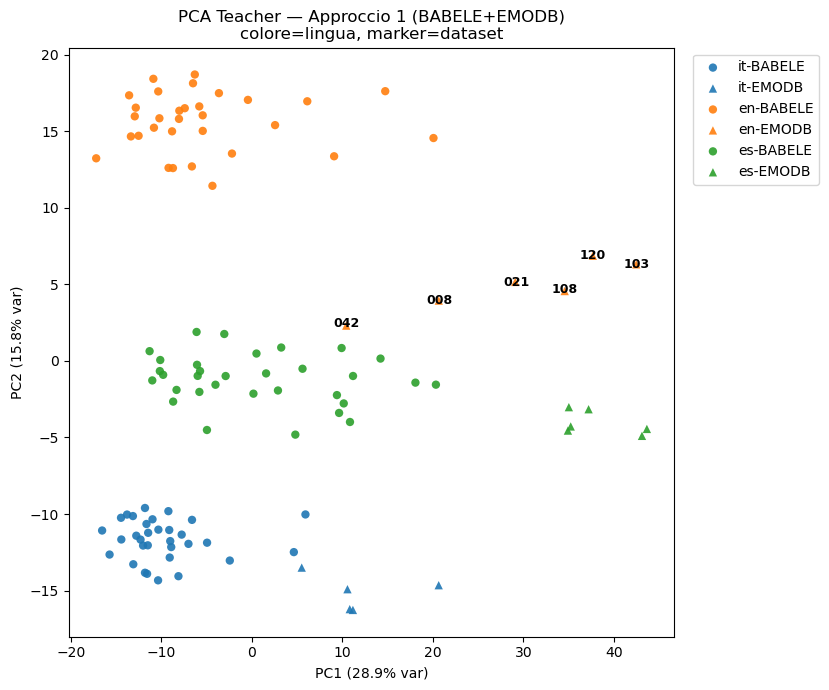

Figure 2D: fig_pca_app1_emodb_en_labels/pca_app1_2D_emodb_en_labels.pdf | fig_pca_app1_emodb_en_labels/pca_app1_2D_emodb_en_labels.png
[3D] Explained variance: PC1=28.9%  PC2=15.8%  PC3=9.0%  (tot=53.7%)
[3D] Silhouette globale: 0.463


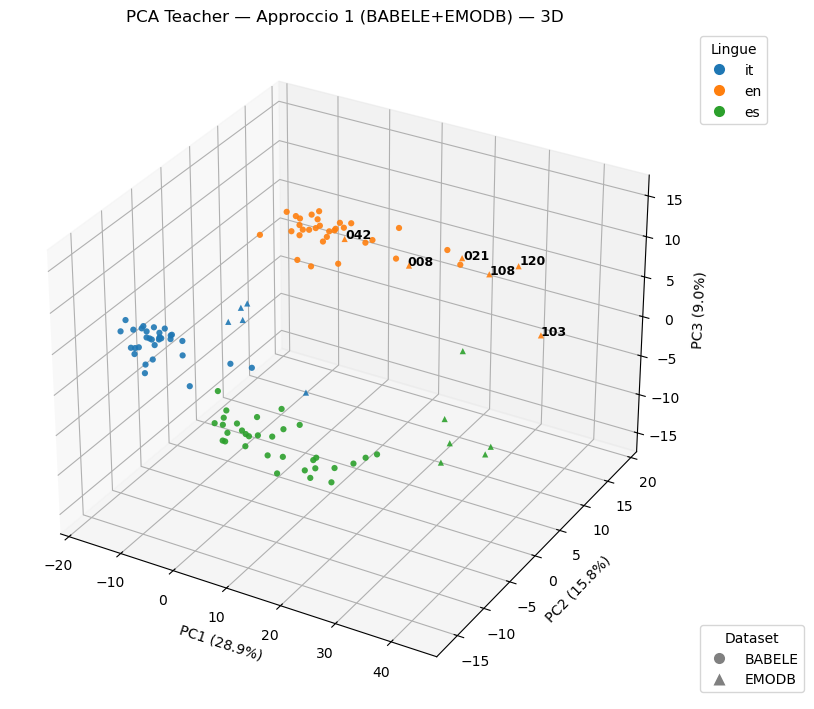

Figure 3D: fig_pca_app1_emodb_en_labels/pca_app1_3D_emodb_en_labels.pdf | fig_pca_app1_emodb_en_labels/pca_app1_3D_emodb_en_labels.png


In [62]:
# -*- coding: utf-8 -*-
# PCA Teacher — Approccio 1 (BABELE+EMODB) + Metriche quantitative
# - Colori = lingua, marker = dataset
# - PCA 2D + 3D
# - Etichette SOLO per EMODB in inglese (3 cifre speaker)
# - Metriche: explained variance, silhouette (globale + per lingua), separability J
# - Nessun drop forzato

import os, os.path as op, re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score, silhouette_samples

# ===================== CONFIG =====================
CSV = {
    "BABELE": "BABELE/distillation_dataset.csv",
    "EMODB":  "EMODB/manifest_test_neutro.csv",
}

FILTER_LANGS       = ["en", "it", "es"]   # None = tutte
EMB_KIND           = "feat"               # 'feat' oppure 'hid'
FORCE_COL = {                             
    "BABELE": "feat_path",                # o "hid_path" se serve
    "EMODB":  "feat_path",
}

# Pre-processing (non eliminano campioni)
L2_NORMALIZE       = False                 # ||x||=1
CENTER_BY_DATASET  = False                 # z-score per-dataset

# NIENTE drop
DROP_TOP_BY_NORM   = 0
DROP_TOP_BY_PC1    = 3

# Etichette (solo EMODB/en)
SHOW_LABELS_2D     = True
SHOW_LABELS_3D     = True
LABEL_FONT_SIZE    = 9
LABEL_JITTER       = 0.35

RANDOM_STATE       = 0
OUT_DIR            = "fig_pca_app1_emodb_en_labels"
os.makedirs(OUT_DIR, exist_ok=True)
# ==================================================

def find_col(df, candidates):
    m = {c.lower(): c for c in df.columns}
    for cand in candidates:
        for k, orig in m.items():
            if cand in k: return orig
    return None

def resolve_path(p, csv_path):
    p = Path(str(p)).expanduser()
    if p.is_absolute(): return str(p) if p.exists() else None
    cand = Path(csv_path).parent / p
    return str(cand) if cand.exists() else None

def pick_embedding_column(df, ds_name):
    forced = FORCE_COL.get(ds_name)
    if forced and forced in df.columns:
        return forced
    if EMB_KIND == "feat":
        for c in df.columns:
            v = str(df[c].iloc[0]) if len(df) else ""
            if v.endswith(".feat.npy") or "feat" in c.lower(): return c
    elif EMB_KIND == "hid":
        for c in df.columns:
            v = str(df[c].iloc[0]) if len(df) else ""
            if v.endswith(".hid.npy") or "hid" in c.lower(): return c
    for c in df.columns:
        v = str(df[c].iloc[0]) if len(df) else ""
        if v.endswith(".npy"): return c
    return None

def speaker_code_from_filename(fname: str) -> str:
    stem = Path(fname).stem
    m = re.match(r"(\d{3})[\-_]", stem)
    if m: return m.group(1)
    m = re.search(r"(\d{3})", stem)
    return m.group(1) if m else stem[:3]

def separability_J(X, y):
    """Trace ratio tr(Sb)/tr(Sw)."""
    classes = np.unique(y)
    D = X.shape[1]
    mu = X.mean(axis=0)
    Sw = np.zeros((D, D), dtype=float)
    Sb = np.zeros((D, D), dtype=float)
    for c in classes:
        Xc = X[y == c]
        if Xc.shape[0] < 2: continue
        muc = Xc.mean(axis=0)
        Cc  = Xc - muc
        Sw += Cc.T @ Cc
        diff = (muc - mu).reshape(-1,1)
        Sb += Xc.shape[0] * (diff @ diff.T)
    return float(np.trace(Sb) / (np.trace(Sw) + 1e-9))

def load_dataset(ds_name, csv_path):
    if not op.exists(csv_path): raise FileNotFoundError(csv_path)
    df = pd.read_csv(csv_path)

    label_col   = find_col(df, ["label","lang","language"])
    dataset_col = find_col(df, ["dataset","source"])
    if label_col is None: raise RuntimeError(f"Colonna label/lang non trovata in {csv_path}")
    if dataset_col is None:
        df["dataset"] = ds_name; dataset_col = "dataset"

    if FILTER_LANGS is not None:
        df = df[df[label_col].astype(str).isin(FILTER_LANGS)].copy()

    emb_col = pick_embedding_column(df, ds_name)
    if emb_col is None: raise RuntimeError(f"[{ds_name}] nessuna colonna embedding valida in {csv_path}")

    csv_abs = str(Path(csv_path).resolve())
    X, y, d, files = [], [], [], []
    chosen = []
    for _, r in df.iterrows():
        p = r.get(emb_col, None)
        if not (isinstance(p, str) and p.endswith(".npy")): continue
        p = resolve_path(p, csv_abs)
        if not p: continue
        arr = np.load(p)
        x = arr.mean(axis=0) if arr.ndim > 1 else arr
        X.append(x.astype(np.float32))
        y.append(str(r[label_col]).strip())
        d.append(ds_name)
        files.append(Path(p).name)
        chosen.append(Path(p).name)

    if not X: raise RuntimeError(f"[{ds_name}] nessun embedding caricato da {csv_path}")

    X = np.vstack(X); y = np.array(y, str); d = np.array(d, str); files = np.array(files, str)
    print(f"[{ds_name}] {Path(csv_path).name} | usati={len(X)} | dim={X.shape[1]}")
    print(pd.Series(chosen).value_counts().head())
    return X, y, d, files

# --------- LOAD ---------
Xs, Ys, Ds, Fs = [], [], [], []
for name, path in CSV.items():
    Xi, yi, di, fi = load_dataset(name, path)
    Xs.append(Xi); Ys.append(yi); Ds.append(di); Fs.append(fi)
X = np.vstack(Xs); y = np.concatenate(Ys); d = np.concatenate(Ds); files = np.concatenate(Fs)

# --------- OPTIONAL (drop disattivi di default) ---------
if DROP_TOP_BY_NORM > 0:
    norms = np.linalg.norm(X, axis=1)
    idx = np.argsort(norms)[::-1][:DROP_TOP_BY_NORM]
    keep = np.ones(len(X), bool); keep[idx] = False
    X, y, d, files = X[keep], y[keep], d[keep], files[keep]
    print(f"Drop-by-norm: rimossi {len(idx)} -> {keep.sum()} rimanenti")

if L2_NORMALIZE:
    X = X / (np.linalg.norm(X, axis=1, keepdims=True) + 1e-8)
    print("L2 normalization: ON")

if CENTER_BY_DATASET:
    Xc = np.empty_like(X)
    for nm in np.unique(d):
        m = (d == nm)
        mu = X[m].mean(axis=0); sd = X[m].std(axis=0, ddof=0) + 1e-8
        Xc[m] = (X[m] - mu) / sd
    X = Xc
    print("Per-dataset standardization: ON")

if DROP_TOP_BY_PC1 > 0:
    Ztmp = StandardScaler().fit_transform(X)
    pc1 = PCA(n_components=1, random_state=RANDOM_STATE).fit(Ztmp).components_[0]
    scores = Ztmp @ pc1
    idx = np.argsort(np.abs(scores))[::-1][:DROP_TOP_BY_PC1]
    keep = np.ones(len(X), bool); keep[idx] = False
    X, y, d, files = X[keep], y[keep], d[keep], files[keep]
    print(f"Drop-by-PC1: rimossi {len(idx)} -> {keep.sum()} rimanenti")

# --------- PCA 2D ---------
Xz  = StandardScaler().fit_transform(X)
pca2 = PCA(n_components=2, random_state=RANDOM_STATE)
Z2   = pca2.fit_transform(Xz)
ev2  = pca2.explained_variance_ratio_ * 100

# ===== Metriche (2D) =====
n_classes = len(np.unique(y))
sil_overall_2d = float(silhouette_score(Z2, y)) if n_classes > 1 else float("nan")
sil_samp = silhouette_samples(Z2, y) if n_classes > 1 else np.full(len(y), np.nan)
sil_per_lang_2d = {lg: float(np.mean(sil_samp[y == lg])) for lg in np.unique(y)}

J_feat = separability_J(Xz, y)   # nello spazio standardizzato
J_pca2 = separability_J(Z2, y)   # nella proiezione 2D

print(f"[2D] Explained variance: PC1={ev2[0]:.1f}%, PC2={ev2[1]:.1f}%, Tot={ev2.sum():.1f}%")
print(f"[2D] Silhouette globale: {sil_overall_2d:.3f}")
for lg, v in sil_per_lang_2d.items():
    print(f"[2D] Silhouette {lg}: {v:.3f}")
print(f"[2D] Separability J (feature std): {J_feat:.3f}")
print(f"[2D] Separability J (PCA 2D):     {J_pca2:.3f}")

# Salva metriche CSV
rows = [
    {"metric":"explained_PC1","space":"PCA2D","value":float(ev2[0])},
    {"metric":"explained_PC2","space":"PCA2D","value":float(ev2[1])},
    {"metric":"explained_total","space":"PCA2D","value":float(ev2.sum())},
    {"metric":"silhouette_overall","space":"PCA2D","value":sil_overall_2d},
    {"metric":"separability_J","space":"features_std","value":J_feat},
    {"metric":"separability_J","space":"PCA2D","value":J_pca2},
]
for lg, v in sil_per_lang_2d.items():
    rows.append({"metric":f"silhouette_{lg}","space":"PCA2D","value":v})
pd.DataFrame(rows).to_csv(op.join(OUT_DIR, "metrics_app1.csv"), index=False)

# --------- Plot 2D ---------
langs    = list(dict.fromkeys(y))
datasets = list(dict.fromkeys(d))
markers  = ["o","^","s","D","P","X","v","<",">","*","h","+","x"]
m_map    = {ds: markers[i % len(markers)] for i, ds in enumerate(datasets)}
palette  = plt.colormaps.get("tab10")
c_map    = {lg: palette.colors[i % len(palette.colors)] for i, lg in enumerate(langs)}

fig, ax = plt.subplots(figsize=(8.4, 7.0))
for lg in langs:
    for ds_name in datasets:
        m = (y == lg) & (d == ds_name)
        if not np.any(m): continue
        ax.scatter(Z2[m,0], Z2[m,1], c=[c_map[lg]], marker=m_map[ds_name],
                   alpha=0.9, edgecolor='none', label=f"{lg}-{ds_name}")

# Etichette SOLO EMODB/en
if SHOW_LABELS_2D:
    m_lab = (d == "EMODB") & (y == "en")
    rng = np.random.RandomState(0)
    for i in np.where(m_lab)[0]:
        code = speaker_code_from_filename(files[i])
        jx = (rng.rand()-0.5)*LABEL_JITTER
        jy = (rng.rand()-0.5)*LABEL_JITTER
        ax.text(Z2[i,0]+jx, Z2[i,1]+jy, code, fontsize=LABEL_FONT_SIZE,
                weight='bold', ha='center', va='center')

ax.set_xlabel(f"PC1 ({ev2[0]:.1f}% var)")
ax.set_ylabel(f"PC2 ({ev2[1]:.1f}% var)")
ax.set_title("PCA Teacher — Approccio 1 (BABELE+EMODB)\ncolore=lingua, marker=dataset")
handles, labels = ax.get_legend_handles_labels()
uniq = dict(zip(labels, handles))
ax.legend(uniq.values(), uniq.keys(), bbox_to_anchor=(1.02,1), loc="upper left")
plt.tight_layout()
out2_pdf = op.join(OUT_DIR, "pca_app1_2D_emodb_en_labels.pdf")
out2_png = op.join(OUT_DIR, "pca_app1_2D_emodb_en_labels.png")
plt.savefig(out2_pdf, bbox_inches="tight")
plt.savefig(out2_png, dpi=220, bbox_inches="tight")
plt.show()

print("Figure 2D:", out2_pdf, "|", out2_png)

# --------- PCA 3D + plot ---------
from mpl_toolkits.mplot3d import Axes3D  # noqa: F401
pca3 = PCA(n_components=3, random_state=RANDOM_STATE)
Z3 = pca3.fit_transform(Xz)
ev3 = pca3.explained_variance_ratio_ * 100
sil_overall_3d = float(silhouette_score(Z3, y)) if n_classes > 1 else float("nan")

print(f"[3D] Explained variance: PC1={ev3[0]:.1f}%  PC2={ev3[1]:.1f}%  PC3={ev3[2]:.1f}%  (tot={ev3.sum():.1f}%)")
print(f"[3D] Silhouette globale: {sil_overall_3d:.3f}")

fig = plt.figure(figsize=(8.8, 7.2))
ax3 = fig.add_subplot(111, projection='3d')
for lg in langs:
    for ds_name in datasets:
        m = (y == lg) & (d == ds_name)
        if not np.any(m): continue
        ax3.scatter(Z3[m,0], Z3[m,1], Z3[m,2],
                    c=[c_map[lg]], marker=m_map[ds_name],
                    alpha=0.9, edgecolor='none', label=f"{lg}-{ds_name}")

if SHOW_LABELS_3D:
    m_lab = (d == "EMODB") & (y == "en")
    rng = np.random.RandomState(0)
    for i in np.where(m_lab)[0]:
        code = speaker_code_from_filename(files[i])
        jx = (rng.rand()-0.5)*LABEL_JITTER
        jy = (rng.rand()-0.5)*LABEL_JITTER
        jz = (rng.rand()-0.5)*LABEL_JITTER
        ax3.text(Z3[i,0]+jx, Z3[i,1]+jy, Z3[i,2]+jz, code,
                 fontsize=LABEL_FONT_SIZE, weight='bold')

ax3.set_xlabel(f"PC1 ({ev3[0]:.1f}%)"); ax3.set_ylabel(f"PC2 ({ev3[1]:.1f}%)"); ax3.set_zlabel(f"PC3 ({ev3[2]:.1f}%)")
ax3.set_title("PCA Teacher — Approccio 1 (BABELE+EMODB) — 3D")
lang_h = [plt.Line2D([0],[0], marker='o', linestyle='', markerfacecolor=c_map[lg],
                     markeredgecolor='none', markersize=8, label=lg) for lg in langs]
ds_h   = [plt.Line2D([0],[0], marker=m_map[dsn], linestyle='', markerfacecolor='gray',
                     markeredgecolor='none', markersize=8, label=dsn) for dsn in datasets]
leg1 = plt.legend(handles=lang_h, title="Lingue", loc="upper left", bbox_to_anchor=(1.02,1.0))
ax3.add_artist(leg1)
plt.legend(handles=ds_h, title="Dataset", loc="lower left", bbox_to_anchor=(1.02,0.0))
plt.tight_layout()
out3_pdf = op.join(OUT_DIR, "pca_app1_3D_emodb_en_labels.pdf")
out3_png = op.join(OUT_DIR, "pca_app1_3D_emodb_en_labels.png")
plt.savefig(out3_pdf, bbox_inches="tight")
plt.savefig(out3_png, dpi=220, bbox_inches="tight")
plt.show()

print("Figure 3D:", out3_pdf, "|", out3_png)


In [66]:
# %% [markdown]
# Seleziona i video in cui il token '0' è immediatamente prima di 'EN'
# (es. ..._0_EN, ..._0_EN_2, ..._0_EN_final) e salva <input>_neutro.csv

# %%
import os, re
import pandas as pd
from pathlib import Path

# === Config ===
IN_CSV = "NEWEMODB/manifest_en_only.csv"  # cambia se serve
if not os.path.exists(IN_CSV):
    alt = "/mnt/data/manifest_en_only.csv"
    IN_CSV = alt if os.path.exists(alt) else IN_CSV
if not os.path.exists(IN_CSV):
    raise FileNotFoundError("CSV non trovato. Imposta IN_CSV o usa /mnt/data/manifest_en_only.csv")

# Colonne che probabilmente contengono path/nomi file
FILE_LIKE_KEYS = [
    "file", "filename", "name", "basename",
    "video", "video_path", "path",
    "mouth", "mouth_path", "feat_path", "hid_path"
]

def guess_file_columns(df: pd.DataFrame):
    return [c for c in df.columns if any(k in c.lower() for k in FILE_LIKE_KEYS)] or list(df.columns)

def strip_all_ext(p: str) -> str:
    s = Path(p).name
    while True:
        root = Path(s).stem
        if root == s: break
        s = root
    return s

def norm_stem(p: str) -> list:
    """Basename -> uppercase, separatori (spazio/-/./_) -> '_', compattati; ritorna lista token."""
    s = strip_all_ext(p).upper()
    s = re.sub(r"[ \-\.]+", "_", s)      # unifica
    s = re.sub(r"_+", "_", s).strip("_") # compatta/rimuovi bordi
    return s.split("_") if s else []

def has_token_0_before_EN(val) -> bool:
    if not isinstance(val, str) or not val:
        return False
    toks = norm_stem(val)
    # match di token adiacenti: ... 0, EN, ...
    return any(toks[i] == "0" and i+1 < len(toks) and toks[i+1] == "EN" for i in range(len(toks)-1))

# --- Filtra e salva ---
df = pd.read_csv(IN_CSV)
cols = guess_file_columns(df)

mask = pd.Series(False, index=df.index)
for c in cols:
    mask |= df[c].astype(str).apply(has_token_0_before_EN)

out_df = df[mask].copy()

out_csv = str(Path(IN_CSV).with_name(Path(IN_CSV).stem + "_neutro.csv"))
out_df.to_csv(out_csv, index=False)

print(f"Input: {IN_CSV}")
print(f"Righe totali: {len(df)}")
print(f"Selezionate (token '0' subito prima di 'EN'): {len(out_df)}")
print(f"Salvato: {out_csv}")


Input: NEWEMODB/manifest_en_only.csv
Righe totali: 431
Selezionate (token '0' subito prima di 'EN'): 62
Salvato: NEWEMODB/manifest_en_only_neutro.csv


[EMODB] distillation_dataset_filtrato.csv | usati=195 | dim=768 | uniq label=['es', 'it']
[VidTIMIT] distillation_dataset.csv | usati=98 | dim=768 | uniq label=['en']
[EMODB_EN] manifest_en_only_neutro.csv | usati=62 | dim=768 | uniq label=['en']
L2 normalization: ON
Drop-by-PC1: rimossi 3 -> 352 rimanenti
[2D] Explained variance: PC1=29.7%, PC2=21.5%, Tot=51.3%
[2D] Silhouette globale: 0.511
[2D] Silhouette en: 0.283
[2D] Silhouette es: 0.720
[2D] Silhouette it: 0.674
[2D] Separability J (feature std): 0.651
[2D] Separability J (PCA 2D):     2.628


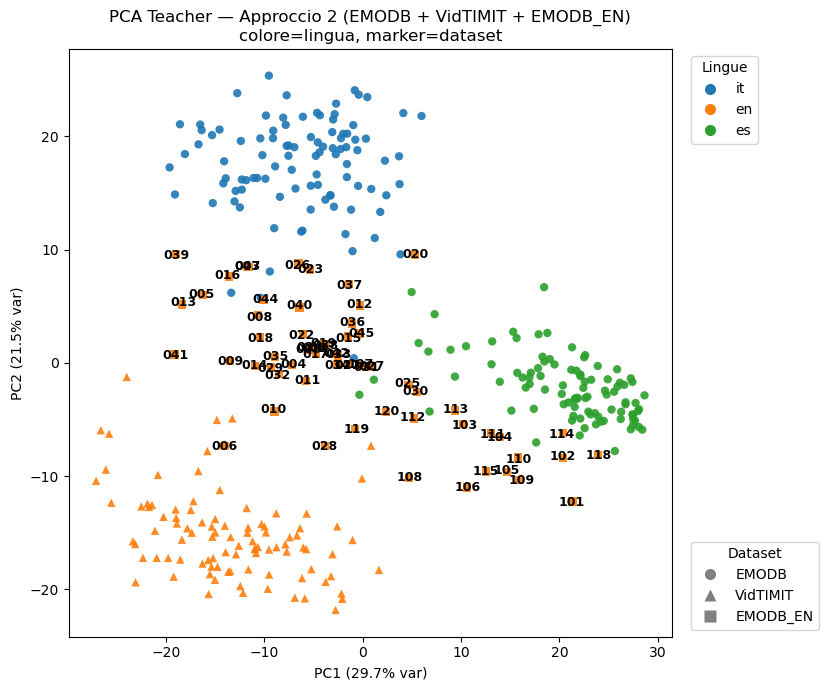

Figure 2D: fig_pca_app2_emodb_en_labels/pca_app2_2D_emodb_en_labels.pdf | fig_pca_app2_emodb_en_labels/pca_app2_2D_emodb_en_labels.png
[3D] Explained variance: PC1=29.7%  PC2=21.5%  PC3=8.0%  (tot=59.3%)
[3D] Silhouette globale: 0.490


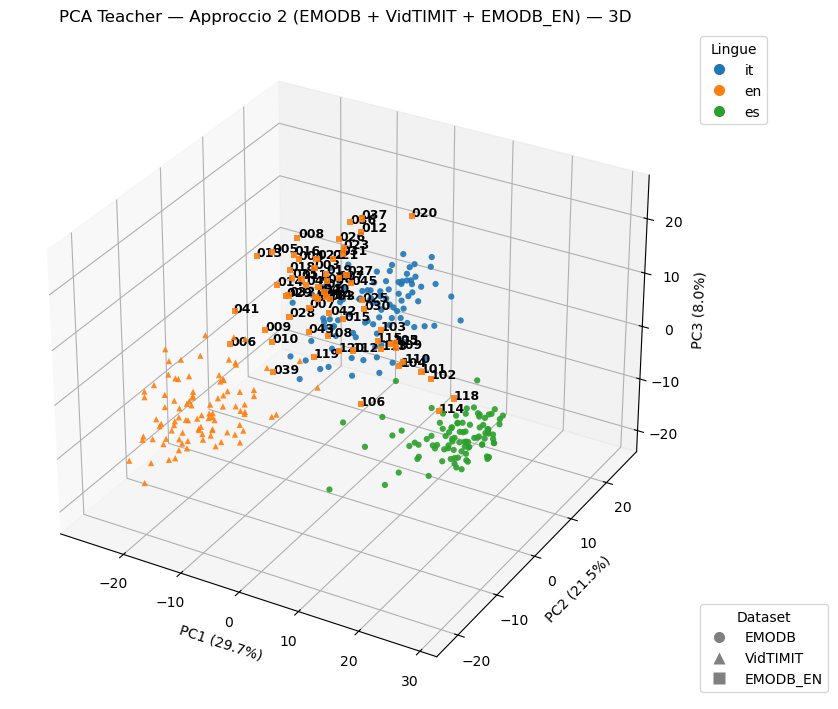

Figure 3D: fig_pca_app2_emodb_en_labels/pca_app2_3D_emodb_en_labels.pdf | fig_pca_app2_emodb_en_labels/pca_app2_3D_emodb_en_labels.png


In [ ]:
# -*- coding: utf-8 -*-
# PCA Teacher — Approccio 2 (EMODB + VidTIMIT + EMODB_EN) robusto
# - Colori fissi per lingua: it=blu, en=arancione, es=verde
# - Marker = dataset
# - PCA 2D + 3D
# - Etichette 3-digit opzionali per EN di EMODB/EMODB_EN
# - Metriche: explained variance, silhouette (globale + per lingua), separability J

import os, os.path as op, re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score, silhouette_samples

# ===================== CONFIG =====================
CSV = {
    "EMODB":     "NEWEMODB/distillation_dataset_filtrato.csv",
    "VidTIMIT":  "VidTIMIT/distillation_dataset.csv",
    #"EMODB_EN":  "NEWEMODB/manifest_en_only_neutro.csv",
}

FILTER_LANGS       = ["en", "it", "es"]   # <- metti None per evitare filtri
EMB_KIND           = "feat"               # 'feat' oppure 'hid'
FORCE_COL = {                             
    "EMODB":     "feat_path",
    "VidTIMIT":  "feat_path",
    "EMODB_EN":  "feat_path",
}

L2_NORMALIZE       = True
CENTER_BY_DATASET  = False
DROP_TOP_BY_NORM   = 0
DROP_TOP_BY_PC1    = 3

SHOW_LABELS_2D     = True
SHOW_LABELS_3D     = True
LABEL_FONT_SIZE    = 9
LABEL_JITTER       = 0.35
LABEL_DATASETS_FOR_CODES = ["EMODB", "EMODB_EN"]

RANDOM_STATE       = 0
OUT_DIR            = "fig_pca_app2_emodb_en_labels"
os.makedirs(OUT_DIR, exist_ok=True)
# ==================================================

def find_col(df, candidates):
    m = {c.lower(): c for c in df.columns}
    for cand in candidates:
        for k, orig in m.items():
            if cand in k:
                return orig
    return None

def resolve_path_multi(p, csv_path):
    """
    Risolve p provando, in ordine:
      1) assoluto
      2) relativo alla cartella del CSV
      3) relativo alla CWD
      4) /mnt/data/<p> (preservando sottocartelle)
      5) /mnt/data/<basename>
    Evita duplicazioni tipo NEWEMODB/NEWEMODB/...
    """
    if not isinstance(p, str) or not p.strip():
        return None
    p_rel = Path(p).expanduser()
    if p_rel.is_absolute():
        return str(p_rel) if p_rel.exists() else None

    csv_dir = Path(csv_path).parent

    # 1) relativo alla cartella del CSV (attenzione al doppio prefisso)
    try1 = (csv_dir / p_rel)
    if p_rel.parts and csv_dir.name.lower() == p_rel.parts[0].lower():
        if p_rel.exists():
            return str(p_rel)
    if try1.exists():
        return str(try1)

    # 2) relativo alla CWD
    try2 = Path.cwd() / p_rel
    if try2.exists():
        return str(try2)

    # 3) /mnt/data/<p> (mantieni sottodirectory)
    try3 = Path("/mnt/data") / p_rel
    if try3.exists():
        return str(try3)

    # 4) fallback basename
    try4 = Path("/mnt/data") / p_rel.name
    if try4.exists():
        return str(try4)

    return None

def pick_embedding_column(df, ds_name):
    forced = FORCE_COL.get(ds_name)
    if forced and forced in df.columns:
        return forced
    candidates = [
        "feat_path", "features_path",
        "layer11_mean_path", "layer10_mean_path",
        "hid_path", "hidden_path", "hidden_mean_path",
        "embedding_path"
    ]
    npy_cols = [c for c in df.columns if str(df[c].iloc[0] if len(df) else "").endswith(".npy")]
    for c in candidates + npy_cols + list(df.columns):
        if c in df.columns:
            v = str(df[c].iloc[0]) if len(df) else ""
            if v.endswith(".npy") or any(k in c.lower() for k in ["feat","hid","layer10","layer11","embed"]):
                return c
    return None

def normalize_lang(val: str):
    if val is None or (isinstance(val, float) and np.isnan(val)):
        return None
    s = str(val).strip().lower()
    repl = {
        "eng":"en", "english":"en", "en-us":"en", "en_gb":"en",
        "ita":"it", "italian":"it",
        "esp":"es", "spa":"es", "spanish":"es"
    }
    s = repl.get(s, s)
    if s not in {"en","it","es"}:
        m = re.search(r"(?:^|[_\-/])(en|it|es)(?:[_\-/]|$)", s)
        if m: s = m.group(1)
    return s

def speaker_code_from_filename(fname: str) -> str:
    stem = Path(fname).stem
    m = re.match(r"(\d{3})[\-_]", stem)
    if m: return m.group(1)
    m = re.search(r"(\d{3})", stem)
    return m.group(1) if m else stem[:3]

def separability_J(X, y):
    classes = np.unique(y)
    D = X.shape[1]
    mu = X.mean(axis=0)
    Sw = np.zeros((D, D), dtype=float)
    Sb = np.zeros((D, D), dtype=float)
    for c in classes:
        Xc = X[y == c]
        if Xc.shape[0] < 2:
            continue
        muc = Xc.mean(axis=0)
        Cc  = Xc - muc
        Sw += Cc.T @ Cc
        diff = (muc - mu).reshape(-1,1)
        Sb += Xc.shape[0] * (diff @ diff.T)
    return float(np.trace(Sb) / (np.trace(Sw) + 1e-9))

def load_dataset(ds_name, csv_path):
    if not op.exists(csv_path):
        alt = str(Path("/mnt/data") / Path(csv_path).name)
        if op.exists(alt):
            csv_path = alt
        else:
            raise FileNotFoundError(csv_path)

    df = pd.read_csv(csv_path)

    label_col   = find_col(df, ["label","lang","language"])
    dataset_col = find_col(df, ["dataset","source"])
    if dataset_col is None:
        df["dataset"] = ds_name; dataset_col = "dataset"

    # Normalizza/inferisci lingue
    if label_col is None:
        if ds_name == "EMODB_EN":
            df["label"] = "en"; label_col = "label"
        else:
            guess_col = find_col(df, ["mouth","video","file","path"])
            if guess_col is not None:
                df["label"] = df[guess_col].astype(str).map(normalize_lang)
                label_col = "label"
    else:
        df[label_col] = df[label_col].map(normalize_lang)

    if label_col is None:
        df["label"] = "other"; label_col = "label"

    if FILTER_LANGS is not None:
        df = df[df[label_col].isin(FILTER_LANGS)].copy()

    emb_col = pick_embedding_column(df, ds_name)
    if emb_col is None:
        print(f"[{ds_name}] Nessuna colonna embedding valida in {csv_path} — SKIP")
        return None

    csv_abs = str(Path(csv_path).resolve())
    X, y, d, files = [], [], [], []
    n_rows = len(df)
    n_ok = 0
    for _, r in df.iterrows():
        p = r.get(emb_col, None)
        if isinstance(p, str) and p.strip():
            rp = resolve_path_multi(p, csv_abs)
            if rp and Path(rp).exists():
                arr = np.load(rp)
                x = arr.mean(axis=0) if arr.ndim > 1 else arr
                X.append(x.astype(np.float32))
                y.append(str(r[label_col]).strip())
                d.append(ds_name)
                files.append(Path(rp).name)
                n_ok += 1
                continue
        for alt in ["layer11_mean_path","layer10_mean_path","feat_path","hid_path"]:
            if alt == emb_col or alt not in df.columns:
                continue
            p2 = r.get(alt, None)
            if isinstance(p2, str) and p2.strip():
                rp2 = resolve_path_multi(p2, csv_abs)
                if rp2 and Path(rp2).exists():
                    arr = np.load(rp2)
                    x = arr.mean(axis=0) if arr.ndim > 1 else arr
                    X.append(x.astype(np.float32))
                    y.append(str(r[label_col]).strip())
                    d.append(ds_name)
                    files.append(Path(rp2).name)
                    n_ok += 1
                    break

    if n_ok == 0:
        print(f"[{ds_name}] WARNING: nessun embedding caricato da {csv_path} (righe={n_rows}). SKIP")
        return None

    X = np.vstack(X); y = np.array(y, str); d = np.array(d, str); files = np.array(files, str)
    print(f"[{ds_name}] {Path(csv_path).name} | usati={len(X)} | dim={X.shape[1]} | uniq label={pd.Series(y).unique().tolist()}")
    return X, y, d, files

# --------- LOAD ---------
Xs, Ys, Ds, Fs = [], [], [], []
for name, path in CSV.items():
    loaded = load_dataset(name, path)
    if loaded is None:
        continue
    Xi, yi, di, fi = loaded
    Xs.append(Xi); Ys.append(yi); Ds.append(di); Fs.append(fi)

if not Xs:
    raise RuntimeError("Nessun dataset contiene embedding leggibili. Controlla path e colonne *feat/hid/layer*_mean_path.")

X = np.vstack(Xs); y = np.concatenate(Ys); d = np.concatenate(Ds); files = np.concatenate(Fs)

# --------- OPTIONAL DROPs ---------
if DROP_TOP_BY_NORM > 0:
    norms = np.linalg.norm(X, axis=1)
    idx = np.argsort(norms)[::-1][:DROP_TOP_BY_NORM]
    keep = np.ones(len(X), bool); keep[idx] = False
    X, y, d, files = X[keep], y[keep], d[keep], files[keep]
    print(f"Drop-by-norm: rimossi {len(idx)} -> {keep.sum()} rimanenti")

if L2_NORMALIZE:
    X = X / (np.linalg.norm(X, axis=1, keepdims=True) + 1e-8)
    print("L2 normalization: ON")

if CENTER_BY_DATASET:
    Xc = np.empty_like(X)
    for nm in np.unique(d):
        m = (d == nm)
        mu = X[m].mean(axis=0); sd = X[m].std(axis=0, ddof=0) + 1e-8
        Xc[m] = (X[m] - mu) / sd
    X = Xc
    print("Per-dataset standardization: ON")

if DROP_TOP_BY_PC1 > 0:
    Ztmp = StandardScaler().fit_transform(X)
    pc1 = PCA(n_components=1, random_state=RANDOM_STATE).fit(Ztmp).components_[0]
    scores = Ztmp @ pc1
    idx = np.argsort(np.abs(scores))[::-1][:DROP_TOP_BY_PC1]
    keep = np.ones(len(X), bool); keep[idx] = False
    X, y, d, files = X[keep], y[keep], d[keep], files[keep]
    print(f"Drop-by-PC1: rimossi {len(idx)} -> {keep.sum()} rimanenti")

# --------- PCA 2D ---------
Xz  = StandardScaler().fit_transform(X)
pca2 = PCA(n_components=2, random_state=RANDOM_STATE)
Z2   = pca2.fit_transform(Xz)
ev2  = pca2.explained_variance_ratio_ * 100

# ===== Metriche (2D) =====
n_classes = len(np.unique(y))
sil_overall_2d = float(silhouette_score(Z2, y)) if n_classes > 1 else float("nan")
sil_samp = silhouette_samples(Z2, y) if n_classes > 1 else np.full(len(y), np.nan)
sil_per_lang_2d = {lg: float(np.mean(sil_samp[y == lg])) for lg in np.unique(y)}

J_feat = separability_J(Xz, y)
J_pca2 = separability_J(Z2, y)

print(f"[2D] Explained variance: PC1={ev2[0]:.1f}%, PC2={ev2[1]:.1f}%, Tot={ev2.sum():.1f}%")
print(f"[2D] Silhouette globale: {sil_overall_2d:.3f}")
for lg, v in sil_per_lang_2d.items():
    print(f"[2D] Silhouette {lg}: {v:.3f}")
print(f"[2D] Separability J (feature std): {J_feat:.3f}")
print(f"[2D] Separability J (PCA 2D):     {J_pca2:.3f}")

rows = [
    {"metric":"explained_PC1","space":"PCA2D","value":float(ev2[0])},
    {"metric":"explained_PC2","space":"PCA2D","value":float(ev2[1])},
    {"metric":"explained_total","space":"PCA2D","value":float(ev2.sum())},
    {"metric":"silhouette_overall","space":"PCA2D","value":sil_overall_2d},
    {"metric":"separability_J","space":"features_std","value":J_feat},
    {"metric":"separability_J","space":"PCA2D","value":J_pca2},
]
for lg, v in sil_per_lang_2d.items():
    rows.append({"metric":f"silhouette_{lg}","space":"PCA2D","value":v})
pd.DataFrame(rows).to_csv(op.join(OUT_DIR, "metrics_app2.csv"), index=False)

# --------- Plot 2D ---------
langs    = list(dict.fromkeys(y))
datasets = list(dict.fromkeys(d))

# Palette fissa per lingue (come screenshot)
LANG_COLORS = {"it": "#1f77b4", "en": "#ff7f0e", "es": "#2ca02c"}  # blu, arancione, verde
def color_for(lg): 
    return LANG_COLORS.get(lg, "#7f7f7f")  # default grigio per lingue inattese

markers  = ["o","^","s","D","P","X","v","<",">","*","h","+","x"]
m_map    = {ds: markers[i % len(markers)] for i, ds in enumerate(datasets)}

fig, ax = plt.subplots(figsize=(8.4, 7.0))
for lg in langs:
    for ds_name in datasets:
        m = (y == lg) & (d == ds_name)
        if not np.any(m): 
            continue
        ax.scatter(Z2[m,0], Z2[m,1],
                   c=[color_for(lg)], marker=m_map[ds_name],
                   alpha=0.9, edgecolor='none')

# Etichette (SOLO se abilitate)
if SHOW_LABELS_2D:
    m_lab = np.isin(d, LABEL_DATASETS_FOR_CODES) & (y == "en")
    rng = np.random.RandomState(0)
    for i in np.where(m_lab)[0]:
        code = speaker_code_from_filename(files[i])
        jx = (rng.rand()-0.5)*LABEL_JITTER
        jy = (rng.rand()-0.5)*LABEL_JITTER
        ax.text(Z2[i,0]+jx, Z2[i,1]+jy, code, fontsize=LABEL_FONT_SIZE,
                weight='bold', ha='center', va='center')

ax.set_xlabel(f"PC1 ({ev2[0]:.1f}% var)")
ax.set_ylabel(f"PC2 ({ev2[1]:.1f}% var)")
ax.set_title("PCA Teacher — Approccio 2 (EMODB + VidTIMIT + EMODB_EN)\ncolore=lingua, marker=dataset")

# Legende separate
lang_order = [lg for lg in ["it","en","es"] if lg in set(langs)]
lang_h = [plt.Line2D([0],[0], marker='o', linestyle='',
                     markerfacecolor=LANG_COLORS[lg], markeredgecolor='none',
                     markersize=8, label=lg) for lg in lang_order]
leg1 = ax.legend(handles=lang_h, title="Lingue", loc="upper left", bbox_to_anchor=(1.02,1.0))
ax.add_artist(leg1)

ds_h = [plt.Line2D([0],[0], marker=m_map[dsn], linestyle='',
                   markerfacecolor='gray', markeredgecolor='none',
                   markersize=8, label=dsn) for dsn in datasets]
ax.legend(handles=ds_h, title="Dataset", loc="lower left", bbox_to_anchor=(1.02,0.0))

plt.tight_layout()
out2_pdf = op.join(OUT_DIR, "pca_app2_2D_emodb_en_labels.pdf")
out2_png = op.join(OUT_DIR, "pca_app2_2D_emodb_en_labels.png")
plt.savefig(out2_pdf, bbox_inches="tight")
plt.savefig(out2_png, dpi=220, bbox_inches="tight")
plt.show()
print("Figure 2D:", out2_pdf, "|", out2_png)

# --------- PCA 3D ---------
from mpl_toolkits.mplot3d import Axes3D  # noqa: F401
pca3 = PCA(n_components=3, random_state=RANDOM_STATE)
Z3 = pca3.fit_transform(Xz)
ev3 = pca3.explained_variance_ratio_ * 100
sil_overall_3d = float(silhouette_score(Z3, y)) if n_classes > 1 else float("nan")

print(f"[3D] Explained variance: PC1={ev3[0]:.1f}%  PC2={ev3[1]:.1f}%  PC3={ev3[2]:.1f}%  (tot={ev3.sum():.1f}%)")
print(f"[3D] Silhouette globale: {sil_overall_3d:.3f}")

fig = plt.figure(figsize=(8.8, 7.2))
ax3 = fig.add_subplot(111, projection='3d')
for lg in langs:
    for ds_name in datasets:
        m = (y == lg) & (d == ds_name)
        if not np.any(m): 
            continue
        ax3.scatter(Z3[m,0], Z3[m,1], Z3[m,2],
                    c=[color_for(lg)], marker=m_map[ds_name],
                    alpha=0.9, edgecolor='none')

if SHOW_LABELS_3D:
    m_lab = np.isin(d, LABEL_DATASETS_FOR_CODES) & (y == "en")
    rng = np.random.RandomState(0)
    for i in np.where(m_lab)[0]:
        code = speaker_code_from_filename(files[i])
        jx = (rng.rand()-0.5)*LABEL_JITTER
        jy = (rng.rand()-0.5)*LABEL_JITTER
        jz = (rng.rand()-0.5)*LABEL_JITTER
        ax3.text(Z3[i,0]+jx, Z3[i,1]+jy, Z3[i,2]+jz, code,
                 fontsize=LABEL_FONT_SIZE, weight='bold')

ax3.set_xlabel(f"PC1 ({ev3[0]:.1f}%)")
ax3.set_ylabel(f"PC2 ({ev3[1]:.1f}%)")
ax3.set_zlabel(f"PC3 ({ev3[2]:.1f}%)")
ax3.set_title("PCA Teacher — Approccio 2 (EMODB + VidTIMIT + EMODB_EN) — 3D")

# Legende separate
lang_h = [plt.Line2D([0],[0], marker='o', linestyle='',
                     markerfacecolor=LANG_COLORS[lg], markeredgecolor='none',
                     markersize=8, label=lg) for lg in lang_order]
leg1 = plt.legend(handles=lang_h, title="Lingue", loc="upper left", bbox_to_anchor=(1.02,1.0))
ax3.add_artist(leg1)

ds_h = [plt.Line2D([0],[0], marker=m_map[dsn], linestyle='',
                   markerfacecolor='gray', markeredgecolor='none',
                   markersize=8, label=dsn) for dsn in datasets]
plt.legend(handles=ds_h, title="Dataset", loc="lower left", bbox_to_anchor=(1.02,0.0))

plt.tight_layout()
out3_pdf = op.join(OUT_DIR, "pca_app2_3D_emodb_en_labels.pdf")
out3_png = op.join(OUT_DIR, "pca_app2_3D_emodb_en_labels.png")
plt.savefig(out3_pdf, bbox_inches="tight")
plt.savefig(out3_png, dpi=220, bbox_inches="tight")
plt.show()
print("Figure 3D:", out3_pdf, "|", out3_png)


In [38]:
# -*- coding: utf-8 -*-
"""
Crea un manifest con *soli* campioni in inglese a partire da un CSV esistente.
- Riconosce automaticamente la colonna della lingua (label/lang/language).
- Filtra ai valori: en / eng / english (case-insensitive).
- (Opzionale) Sovrascrive la colonna 'dataset' con 'EMODB_EN_ONLY'.
- Mantiene tutte le colonne originali.

Esempio output:
  input : EMODB/distillation_dataset_session2.csv
  output: EMODB/manifest_en_only.csv
"""

import os
import pandas as pd
from pathlib import Path

# ============== CONFIG ==============
INPUT_CSV  = "NEWEMODB/distillation_dataset_session2.csv"   # <--- il tuo CSV di partenza
OUTPUT_CSV = "NEWEMODB/manifest_en_only.csv"  # None -> stesso folder con nome 'manifest_en_only.csv'
SET_DATASET_NAME = "EMODB_EN_ONLY"  # None per lasciare il dataset com'è
EN_TOKENS = {"en", "eng", "english"}  # valori accettati per "inglese"
# (facoltativo) tieni solo righe che hanno almeno un path .npy in una colonna
REQUIRE_ANY_EMB_PATH = False
# ====================================

def find_col(df, candidates):
    m = {c.lower(): c for c in df.columns}
    for cand in candidates:
        for k, orig in m.items():
            if cand in k:
                return orig
    return None

def has_any_npy_paths(row):
    for c in row.index:
        v = row[c]
        if isinstance(v, str) and v.endswith(".npy"):
            return True
    return False

# ---- load ----
if not Path(INPUT_CSV).exists():
    raise FileNotFoundError(INPUT_CSV)
df = pd.read_csv(INPUT_CSV)
print(f"[LOAD] {INPUT_CSV} | righe={len(df)} | colonne={list(df.columns)}")

# ---- trova colonna lingua ----
lab_col = find_col(df, ["label", "lang", "language"])
if lab_col is None:
    raise RuntimeError("Nessuna colonna 'label'/'lang'/'language' trovata.")

# ---- filtro inglese ----
lab_norm = df[lab_col].astype(str).str.strip().str.lower()
mask_en = lab_norm.isin(EN_TOKENS)
df_en = df.loc[mask_en].copy()
print(f"[FILTER] Inglese trovati: {mask_en.sum()} / {len(df)}")

# ---- (opzionale) richiedi almeno un path .npy valido sulla riga ----
if REQUIRE_ANY_EMB_PATH:
    keep = df_en.apply(has_any_npy_paths, axis=1)
    print(f"[CHECK PATHS] righe con almeno un *.npy: {keep.sum()} / {len(df_en)}")
    df_en = df_en.loc[keep].copy()

# ---- (opzionale) forza il nome dataset ----
ds_col = find_col(df_en, ["dataset", "source"])
if SET_DATASET_NAME:
    if ds_col is None:
        ds_col = "dataset"
        df_en[ds_col] = SET_DATASET_NAME
    else:
        df_en[ds_col] = SET_DATASET_NAME

# ---- salva ----
if OUTPUT_CSV is None:
    OUTPUT_CSV = str(Path(INPUT_CSV).with_name("manifest_en_only.csv"))
df_en.reset_index(drop=True).to_csv(OUTPUT_CSV, index=False)
print(f"[SAVE] {OUTPUT_CSV} | righe={len(df_en)}")

# ---- anteprima ----
print("\n[HEAD]")
print(df_en.head(8))


[LOAD] NEWEMODB/distillation_dataset_session2.csv | righe=822 | colonne=['video_path', 'audio_path', 'segments', 'probs_path', 'hid_path', 'feats_path', 'label']
[FILTER] Inglese trovati: 431 / 822
[SAVE] NEWEMODB/manifest_en_only.csv | righe=431

[HEAD]
                                           video_path  \
0   /Volumes/Crucial X9/EMODB/Session 2/035/035_m_...   
2   /Volumes/Crucial X9/EMODB/Session 2/035/035_m_...   
3   /Volumes/Crucial X9/EMODB/Session 2/035/035_m_...   
7   /Volumes/Crucial X9/EMODB/Session 2/035/035_m_...   
8   /Volumes/Crucial X9/EMODB/Session 2/035/035_m_...   
11  /Volumes/Crucial X9/EMODB/Session 2/035/035_m_...   
12  /Volumes/Crucial X9/EMODB/Session 2/035/035_m_...   
15  /Volumes/Crucial X9/EMODB/Session 2/120/120_m_...   

                                           audio_path  \
0   NEWEMODB/audio_wav/035_m_022_0_5_EN_20language...   
2   NEWEMODB/audio_wav/035_m_022_0_0_EN_20language...   
3   NEWEMODB/audio_wav/035_m_022_0_6_EN_20language...   
7  

In [13]:
# PREPARE DATA PER EMODB !!!!!
import os, cv2, json, numpy as np, pandas as pd
from tqdm import tqdm
import face_alignment
from face_alignment import FaceAlignment

# caso in cui se va fuori frame non dovrebbe tcnicamente bloccarsi
def mouth_roi(frame, landmarks, size=96, scale=1.4):
    h_frame, w_frame = frame.shape[:2]
    pts = landmarks[48:68]
    cx, cy = pts.mean(axis=0)
    w = max(np.ptp(pts[:,0]), np.ptp(pts[:,1])) * scale

    # coords originali
    x1 = int(cx - w/2)
    y1 = int(cy - w/2)
    x2 = int(cx + w/2)
    y2 = int(cy + w/2)

    # clipping ai bordi
    x1 = max(0, x1)
    y1 = max(0, y1)
    x2 = min(w_frame, x2)
    y2 = min(h_frame, y2)

    # se crop vuoto o negativo, skip
    if x2 <= x1 or y2 <= y1:
        return None

    crop = frame[y1:y2, x1:x2]
    if crop.size == 0:
        return None

    return cv2.resize(crop, (size, size))


# Init FaceAlignment su CPU
fa      = FaceAlignment(face_alignment.LandmarksType.TWO_D, device="cpu")
distill = "/Users/ludovicagenovese/Documents/GitHub/mothertongueVSspoken/EMODB/distillation_dataset.csv"
out_dir = "/Users/ludovicagenovese/Documents/GitHub/mothertongueVSspoken/EMODB/video_mouth"
os.makedirs(out_dir, exist_ok=True)

# Leggi manifest (segments come come JSON string)
mani = pd.read_csv(distill, dtype={"segments": str})
mouth_paths = []

for idx, row in tqdm(mani.iterrows(), total=len(mani), desc="Crop Video"):
    video_path = row["video_path"]
    outp = os.path.join(out_dir, os.path.basename(video_path) + ".npy")

    print(f"\n▶️ Video {idx+1}/{len(mani)}: {os.path.basename(video_path)}")

    if os.path.exists(outp):
        print(f"▶️ [{idx+1}/{len(mani)}] {os.path.basename(video_path)} già processato, skip")
        mouth_paths.append(outp)
        continue
    # Carica i segmenti di parlato
    segments = json.loads(row["segments"])
    cap      = cv2.VideoCapture(video_path)
    fps      = cap.get(cv2.CAP_PROP_FPS) or 25
    frames   = []

    # Loop sui segmenti
    for seg_i, (start_s, end_s) in enumerate(segments, 1):
        start_f = int(start_s * fps)
        end_f   = int(end_s   * fps)
        print(f"  Segmento {seg_i}/{len(segments)} → frames {start_f}–{end_f}")
        cap.set(cv2.CAP_PROP_POS_FRAMES, start_f)

        # Loop sui singoli frame
        for f in range(start_f, end_f):
            print(f" Frame {f}")
            ok, frame = cap.read()
            if not ok:
                break
            
            frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB) 
            lm = fa.get_landmarks(frame)
            if lm is None or len(lm) == 0:
                print(f"     ⚠️ Nessun landmark al frame {f}")
                continue

            roi = mouth_roi(frame, lm[0])
            if roi is None:
                continue

            frames.append(roi)

    cap.release()

    print(f"  Estratti {len(frames)} frame totali per questo video")
    if not frames:
        mouth_paths.append("")
        continue

    arr  = np.stack(frames).astype("uint8")
    outp = os.path.join(out_dir, os.path.basename(video_path) + ".npy")
    np.save(outp, arr)
    mouth_paths.append(outp)
    print(f"  ✅ Salvati {len(frames)} frame in {outp}")

# Aggiorna manifest
mani["mouth_path"] = mouth_paths
mani.to_csv(distill, index=False)


Crop Video:   0%|          | 0/21 [00:00<?, ?it/s]


▶️ Video 1/21: 103_f_18_1_2_SP.mp4
▶️ [1/21] 103_f_18_1_2_SP.mp4 già processato, skip

▶️ Video 2/21: 106_m_18_1_4_SP.mp4
▶️ [2/21] 106_m_18_1_4_SP.mp4 già processato, skip

▶️ Video 3/21: 102_m_18_1_1_SP.mp4
▶️ [3/21] 102_m_18_1_1_SP.mp4 già processato, skip

▶️ Video 4/21: 105_m_18_1_3_SP.mp4
▶️ [4/21] 105_m_18_1_3_SP.mp4 già processato, skip

▶️ Video 5/21: 101_f_23_1_0_SP.mp4
▶️ [5/21] 101_f_23_1_0_SP.mp4 già processato, skip

▶️ Video 6/21: 112_m_19_1_6_SP.mp4
▶️ [6/21] 112_m_19_1_6_SP.mp4 già processato, skip

▶️ Video 7/21: 111_m_23_1_5_SP.mp4
▶️ [7/21] 111_m_23_1_5_SP.mp4 già processato, skip

▶️ Video 8/21: 120_m_29_1_5_EN.mp4
▶️ [8/21] 120_m_29_1_5_EN.mp4 già processato, skip

▶️ Video 9/21: 118_m_23_1_6_EN.mp4
▶️ [9/21] 118_m_23_1_6_EN.mp4 già processato, skip

▶️ Video 10/21: 113_f_27_1_1_EN.mp4
▶️ [10/21] 113_f_27_1_1_EN.mp4 già processato, skip

▶️ Video 11/21: 003_f_21_0_1_IT_1.MOV
▶️ [11/21] 003_f_21_0_1_IT_1.MOV già processato, skip

▶️ Video 12/21: 002_m_22_0_0_IT_1.

Crop Video: 100%|██████████| 21/21 [07:27<00:00, 21.29s/it]

  Estratti 147 frame totali per questo video
  ✅ Salvati 147 frame in /Users/ludovicagenovese/Documents/GitHub/mothertongueVSspoken/EMODB/video_mouth/010_m_26_0_5_IT_1.MOV.npy


In [89]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-

"""
Aggiorna IN-PLACE un CSV aggiungendo/riempiendo la colonna 'mouth_path'.
- Legge il CSV indicato
- Usa la colonna video (di default 'video_path'; cambia VIDEO_COL se diverso)
- Estrae un .npy (fallback semplice) per ogni riga con mouth_path mancante
- Salva di nuovo lo stesso CSV (scrittura atomica)

Sostituisci l'estrattore fallback con il tuo ROI-bocca se lo hai già.
"""

import os, re, sys, tempfile, warnings
from pathlib import Path
import numpy as np
import pandas as pd

# ====== CONFIG ======
CSV_PATH   = Path("EMODB/EMODB_neutro_2.csv")  # <-- metti qui il tuo CSV
VIDEO_COL  = "video_path"   # <-- cambia se nel tuo CSV si chiama diverso (es. 'path'/'file')
MOUTH_COL  = "mouth_path"
MOUTH_DIR  = None           # se None: crea una cartella 'mouth_npy' accanto al CSV
RUN_EXTRACTION = True       # False = solo precompila i percorsi senza estrarre

FRAME_SIZE = 112
MAX_FRAMES = None  # None = tutti i frame; oppure un limite, es. 64

try:
    import cv2
except Exception:
    cv2 = None
    warnings.warn("OpenCV non disponibile: userò solo il prefill dei percorsi se RUN_EXTRACTION=True.")

# ====== HELPERS ======
def ensure_parent(p: Path):
    p.parent.mkdir(parents=True, exist_ok=True)

def unique_outpath(base_dir: Path, stem: str, suffix: str = ".npy") -> Path:
    """
    Genera un path unico (stem.npy, stem_1.npy, stem_2.npy, ...) per evitare collisioni.
    """
    cand = base_dir / f"{stem}{suffix}"
    k = 1
    while cand.exists():
        cand = base_dir / f"{stem}_{k}{suffix}"
        k += 1
    return cand

def extract_mouth_fallback(video_path: str, out_npy: Path,
                           frame_size: int = 112,
                           max_frames: int | None = None) -> bool:
    """
    Fallback SEMPLICE: center-crop quadrato + resize in grayscale.
    Sostituisci con il tuo estrattore della bocca (ROI) per risultati reali.
    """
    if cv2 is None:
        return False

    cap = cv2.VideoCapture(video_path)
    if not cap.isOpened():
        return False

    frames = []
    count = 0
    while True:
        ok, frame = cap.read()
        if not ok:
            break
        gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
        h, w = gray.shape
        side = min(h, w)
        y0 = (h - side) // 2
        x0 = (w - side) // 2
        crop = gray[y0:y0+side, x0:x0+side]
        crop = cv2.resize(crop, (frame_size, frame_size), interpolation=cv2.INTER_AREA)
        frames.append(crop)
        count += 1
        if max_frames is not None and count >= max_frames:
            break
    cap.release()

    if not frames:
        return False

    arr = np.stack(frames, axis=0).astype(np.float32) / 255.0  # (T,H,W)
    ensure_parent(out_npy)
    np.save(str(out_npy), arr)
    return True

def pick_video_col(df: pd.DataFrame, desired: str) -> str:
    """Sceglie la colonna dei video (tollerante a nomi diversi)."""
    if desired in df.columns:
        return desired
    candidates = [c for c in df.columns if c.lower() in ("video_path","path","filepath","video","file")]
    if not candidates:
        raise KeyError(
            f"Nessuna colonna video riconosciuta. Colonne disponibili: {list(df.columns)}. "
            "Imposta VIDEO_COL al nome corretto."
        )
    return candidates[0]

# ====== MAIN ======
def main():
    if not CSV_PATH.exists():
        raise FileNotFoundError(f"CSV non trovato: {CSV_PATH}")

    df = pd.read_csv(CSV_PATH)

    vcol = pick_video_col(df, VIDEO_COL)

    # assicura colonna mouth_path
    if MOUTH_COL not in df.columns:
        df[MOUTH_COL] = np.nan

    # base dir per gli npy
    base_dir = Path(MOUTH_DIR) if MOUTH_DIR else (CSV_PATH.parent / "mouth_npy")
    base_dir.mkdir(parents=True, exist_ok=True)

    # quante righe da processare
    todo_mask = df[MOUTH_COL].isna() | (df[MOUTH_COL].astype(str).str.strip() == "")
    todo_idx = df.index[todo_mask]
    print(f"[INFO] Righe totali: {len(df)} | da estrarre: {len(todo_idx)}")

    for i in todo_idx:
        vpath = str(df.at[i, vcol])
        if not isinstance(vpath, str) or not vpath.strip():
            # se manca proprio il path video, lascia NaN
            continue

        stem = os.path.basename(vpath) + ".npy"   # preserva info basename
        stem = stem.replace(os.sep, "_")          # sicurezza su separatori
        out_path = unique_outpath(base_dir, stem=stem[:-4], suffix=".npy")

        ok = True
        if RUN_EXTRACTION:
            ok = extract_mouth_fallback(vpath, out_path,
                                        frame_size=FRAME_SIZE,
                                        max_frames=MAX_FRAMES)

        # aggiorna comunque il percorso (se vuoi solo quando ok, sposta dentro l'if)
        df.at[i, MOUTH_COL] = str(out_path if ok else "")

    # scrittura atomica (tmp -> replace)
    with tempfile.NamedTemporaryFile("w", delete=False, dir=CSV_PATH.parent, suffix=".csv") as tmp:
        df.to_csv(tmp.name, index=False)
        tmp_path = Path(tmp.name)
    tmp_path.replace(CSV_PATH)  # sovrascrive il file originale in modo atomico

    print(f"[DONE] CSV aggiornato in-place: {CSV_PATH}")
    print(f"[HINT] File .npy in: {base_dir}")

if __name__ == "__main__":
    main()


[INFO] Righe totali: 21 | da estrarre: 21


/var/folders/jx/nf2g6k1s1550mrw1rrvdw69h0000gn/T/ipykernel_73653/2162478796.py:142: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value 'EMODB/mouth_npy/037_m_023_0_0_IT_2.mp4_1.npy' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  df.at[i, MOUTH_COL] = str(out_path if ok else "")


[DONE] CSV aggiornato in-place: EMODB/EMODB_neutro_2.csv
[HINT] File .npy in: EMODB/mouth_npy


In [10]:
# prepare_data.py (segment-aligned + debug prints)
import os, cv2, json, numpy as np, pandas as pd
from tqdm import tqdm
import face_alignment
from face_alignment import FaceAlignment

# caso in cui se va fuori frame non dovrebbe tcnicamente bloccarsi
def mouth_roi(frame, landmarks, size=96, scale=1.4):
    h_frame, w_frame = frame.shape[:2]
    pts = landmarks[48:68]
    cx, cy = pts.mean(axis=0)
    w = max(np.ptp(pts[:,0]), np.ptp(pts[:,1])) * scale

    # coords originali
    x1 = int(cx - w/2)
    y1 = int(cy - w/2)
    x2 = int(cx + w/2)
    y2 = int(cy + w/2)

    # clipping ai bordi
    x1 = max(0, x1)
    y1 = max(0, y1)
    x2 = min(w_frame, x2)
    y2 = min(h_frame, y2)

    # se crop vuoto o negativo, skip
    if x2 <= x1 or y2 <= y1:
        return None

    crop = frame[y1:y2, x1:x2]
    if crop.size == 0:
        return None

    return cv2.resize(crop, (size, size))


# Init FaceAlignment su CPU
fa      = FaceAlignment(face_alignment.LandmarksType.TWO_D, device="cpu")
distill = "/Users/ludovicagenovese/Documents/GitHub/mothertongueVSspoken/BABELE/distillation_dataset.csv"
out_dir = "video_mouth"
os.makedirs(out_dir, exist_ok=True)

# Leggi manifest (segments come come JSON string)
mani = pd.read_csv(distill, dtype={"segments": str})
mouth_paths = []

for idx, row in tqdm(mani.iterrows(), total=len(mani), desc="Crop Video"):
    video_path = row["video_path"]
    outp = os.path.join(out_dir, os.path.basename(video_path) + ".npy")

    print(f"\n▶️ Video {idx+1}/{len(mani)}: {os.path.basename(video_path)}")

    if os.path.exists(outp):
        print(f"▶️ [{idx+1}/{len(mani)}] {os.path.basename(video_path)} già processato, skip")
        mouth_paths.append(outp)
        continue
    # Carica i segmenti di parlato
    segments = json.loads(row["segments"])
    cap      = cv2.VideoCapture(video_path)
    fps      = cap.get(cv2.CAP_PROP_FPS) or 25
    frames   = []

    # Loop sui segmenti
    for seg_i, (start_s, end_s) in enumerate(segments, 1):
        start_f = int(start_s * fps)
        end_f   = int(end_s   * fps)
        print(f"  Segmento {seg_i}/{len(segments)} → frames {start_f}–{end_f}")
        cap.set(cv2.CAP_PROP_POS_FRAMES, start_f)

        # Loop sui singoli frame
        for f in range(start_f, end_f):
            print(f" Frame {f}")
            ok, frame = cap.read()
            if not ok:
                break
            
            frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB) 
            lm = fa.get_landmarks(frame)
            if lm is None or len(lm) == 0:
                print(f"     ⚠️ Nessun landmark al frame {f}")
                continue

            roi = mouth_roi(frame, lm[0])
            if roi is None:
                continue

            frames.append(roi)

    cap.release()

    print(f"  Estratti {len(frames)} frame totali per questo video")
    if not frames:
        mouth_paths.append("")
        continue

    arr  = np.stack(frames).astype("uint8")
    outp = os.path.join(out_dir, os.path.basename(video_path) + ".npy")
    np.save(outp, arr)
    mouth_paths.append(outp)
    print(f"  ✅ Salvati {len(frames)} frame in {outp}")

# Aggiorna manifest
mani["mouth_path"] = mouth_paths
mani.to_csv(distill, index=False)


Crop Video:   0%|          | 0/95 [00:00<?, ?it/s]


▶️ Video 1/95: 1_1_2_21_25.mp4
▶️ [1/95] 1_1_2_21_25.mp4 già processato, skip

▶️ Video 2/95: 1_2_2_9_30.mp4
▶️ [2/95] 1_2_2_9_30.mp4 già processato, skip

▶️ Video 3/95: 1_2_1_18_30.mp4
▶️ [3/95] 1_2_1_18_30.mp4 già processato, skip

▶️ Video 4/95: 1_2_2_13_30.mp4
▶️ [4/95] 1_2_2_13_30.mp4 già processato, skip

▶️ Video 5/95: 1_1_2_15_25.mp4
▶️ [5/95] 1_1_2_15_25.mp4 già processato, skip

▶️ Video 6/95: 1_1_1_12_30.mp4
▶️ [6/95] 1_1_1_12_30.mp4 già processato, skip

▶️ Video 7/95: 1_2_1_4_25.mp4
▶️ [7/95] 1_2_1_4_25.mp4 già processato, skip

▶️ Video 8/95: 1_2_1_8_25.mp4
▶️ [8/95] 1_2_1_8_25.mp4 già processato, skip

▶️ Video 9/95: 1_2_1_12_25.mp4
▶️ [9/95] 1_2_1_12_25.mp4 già processato, skip

▶️ Video 10/95: 1_1_1_9_24.mp4
▶️ [10/95] 1_1_1_9_24.mp4 già processato, skip

▶️ Video 11/95: 1_1_1_16_25.mp4
▶️ [11/95] 1_1_1_16_25.mp4 già processato, skip

▶️ Video 12/95: 1_1_1_14_30.mp4
▶️ [12/95] 1_1_1_14_30.mp4 già processato, skip

▶️ Video 13/95: 1_2_1_10_25.mp4
▶️ [13/95] 1_2_1_10_2

/opt/anaconda3/envs/casaenv/lib/python3.12/site-packages/face_alignment/api.py:147: UserWarning: No faces were detected.
  warnings.warn("No faces were detected.")


     ⚠️ Nessun landmark al frame 14397
 Frame 14398
     ⚠️ Nessun landmark al frame 14398
 Frame 14399
     ⚠️ Nessun landmark al frame 14399
 Frame 14400
     ⚠️ Nessun landmark al frame 14400
 Frame 14401
     ⚠️ Nessun landmark al frame 14401
 Frame 14402
     ⚠️ Nessun landmark al frame 14402
 Frame 14403
     ⚠️ Nessun landmark al frame 14403
 Frame 14404
     ⚠️ Nessun landmark al frame 14404
 Frame 14405
     ⚠️ Nessun landmark al frame 14405
 Frame 14406
     ⚠️ Nessun landmark al frame 14406
 Frame 14407
     ⚠️ Nessun landmark al frame 14407
 Frame 14408


Crop Video:  63%|██████▎   | 60/95 [00:03<00:02, 16.93it/s]

     ⚠️ Nessun landmark al frame 14408
 Frame 14409


KeyboardInterrupt: 

In [18]:
# split per l,a validation - sta qua così può essere cambiata
# split_manifest.py
import pandas as pd
from sklearn.model_selection import train_test_split
import numpy as np

SEED = 42
CSV_IN  = "/Users/ludovicagenovese/Documents/GitHub/mothertongueVSspoken/BABELE/distillation_dataset.csv"      # creato dal tuo prepare_data.py
TRAIN_CSV = "/Users/ludovicagenovese/Documents/GitHub/mothertongueVSspoken/BABELE/manifest_train.csv"
VAL_CSV   = "/Users/ludovicagenovese/Documents/GitHub/mothertongueVSspoken/BABELE/manifest_val.csv"
TEST_CSV  = "/Users/ludovicagenovese/Documents/GitHub/mothertongueVSspoken/BABELE/manifest_test.csv"

# 1. carica il dataset e filtra clip con crop vuoto
df = pd.read_csv(CSV_IN)
df = df[df["mouth_path"].str.len() > 0].reset_index(drop=True)

# 2. mappatura label → int per stratificazione
lang2id = {"en":0, "it":1, "es":2}
y = df["label"].map(lang2id)

# 3. train 70 %, temp 30 %
train_df, temp_df, y_train, y_temp = train_test_split(
        df, y, test_size=0.30, stratify=y, random_state=SEED)

# 4. val 15 %, test 15 % (split 50 / 50 del restante 30 %)
val_df, test_df = train_test_split(
        temp_df, test_size=0.50, stratify=y_temp, random_state=SEED)

# 5. salva i tre file
train_df.to_csv(TRAIN_CSV, index=False)
val_df.to_csv(VAL_CSV,     index=False)
test_df.to_csv(TEST_CSV,   index=False)

print(f"Totale clip valide: {len(df)}")
print(f" Train: {len(train_df)}  Val: {len(val_df)}  Test: {len(test_df)}")


Totale clip valide: 94
 Train: 65  Val: 14  Test: 15


In [23]:
# dataset.py
import json, numpy as np, pandas as pd, torch

class LanguageDataset(torch.utils.data.Dataset):
    lang2id = {"en":0, "it":1, "es":2}
    def __init__(self, manifest, max_len=64):
        self.df = pd.read_csv(manifest)
        self.L  = max_len                    # lunghezza fissa

    def _temporal_fix(self, arr):
        T = len(arr)
        if T >= self.L:                                  # campiona L index equispaziati
            idx = np.linspace(0, T-1, self.L).astype(int)
        else:                                            # pad copiando l’ultimo frame
            idx = np.concatenate([np.arange(T), np.full(self.L-T, T-1)])
        return arr[idx]

    def __len__(self):  return len(self.df)

    def __getitem__(self, idx):
        r   = self.df.iloc[idx]
        # dataset.py  (metodo __getitem__)
        vid = self._temporal_fix(np.load(r.mouth_path)) / 255.0   # (T,H,W,3)
        vid = torch.from_numpy(vid).permute(3,0,1,2).float()      # (3,T,H,W)
        vid = (vid - 0.5) / 0.5

        # — carico soft-target e embedding audio medio
        with open(r.probs_path) as f:
            p = json.load(f)
        probs = torch.tensor([p["en"], p["it"], p["es"]])

        emb = torch.from_numpy(np.load(r.hid_path))              # [768] (embedding medio)
        
        # — **carico la sequenza di hidden states** del teacher
        feat_seq = torch.from_numpy(np.load(r.feats_path))       # [Tₐ, 768]

        y = self.lang2id[r.label]
        return vid, probs, emb, feat_seq, y


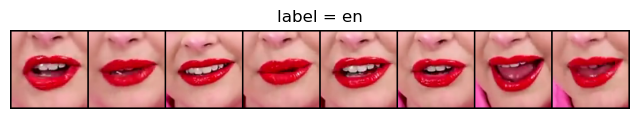

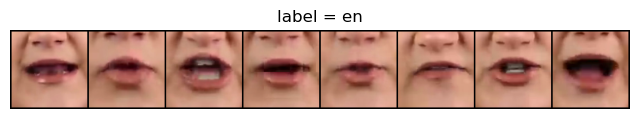

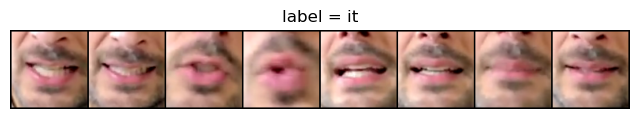

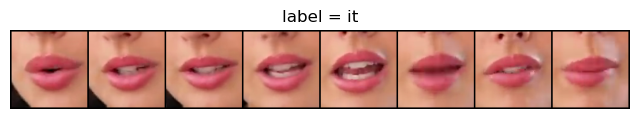

In [39]:
# ───────── Visualizza 4 clip random (8 frame ciascuno) ─────────
import random, matplotlib.pyplot as plt, torchvision.utils as vutils

val_set = LanguageDataset("/Users/ludovicagenovese/Documents/GitHub/mothertongueVSspoken/BABELE/distillation_dataset.csv", max_len=32)

for idx in random.sample(range(len(val_set)), 4):
    vid, _, _,_,lab = val_set[idx]          # vid: (C,T,H,W), float32 0–1
    frames = vid[:, :8]                    # (C,8,H,W)
    frames = frames.permute(1, 0, 2, 3)    # → (8,C,H,W) per make_grid

    grid = vutils.make_grid(frames, nrow=8, normalize=True)  # (C,H,W)
    img  = grid.permute(1, 2, 0).cpu().numpy()               # (H,W,C)
    label = 'en' if lab == 0 else 'it' if lab == 1 else 'sp' if lab == 2 else None

    plt.figure(figsize=(8, 2))
    plt.title(f"label = {label}")
    plt.imshow(img)
    plt.axis("off")
    plt.show()


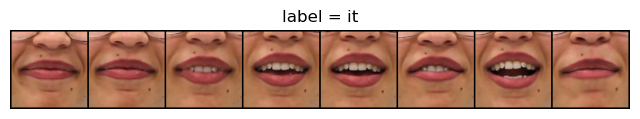

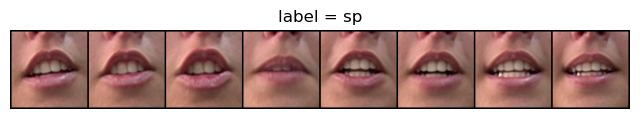

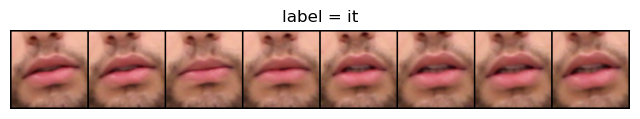

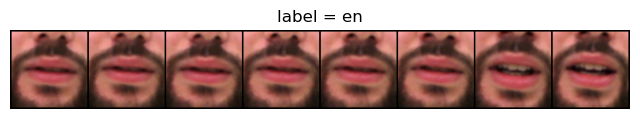

In [40]:
# ───────── Visualizza 4 clip random (8 frame ciascuno) ─────────
import random, matplotlib.pyplot as plt, torchvision.utils as vutils

# Carica il dataset da CSV (modifica max_len se necessario)
val_set = LanguageDataset("EMODB/distillation_dataset.csv", max_len=32)

# Estrai e mostra 4 clip casuali
for idx in random.sample(range(len(val_set)), 4):
    vid, _,_,_,  lab = val_set[idx]          # vid: (C,T,H,W), float32 in [0,1]
    frames = vid[:, :8]                    # Primi 8 frame (C,8,H,W)
    frames = frames.permute(1, 0, 2, 3)    # → (8,C,H,W)

    grid = vutils.make_grid(frames, nrow=8, normalize=True)
    img  = grid.permute(1, 2, 0).cpu().numpy()  # → (H,W,C)
    label = 'en' if lab == 0 else 'it' if lab == 1 else 'sp' if lab == 2 else None

    plt.figure(figsize=(8, 2))
    plt.title(f"label = {label}")
    plt.imshow(img)
    plt.axis("off")
    plt.show()


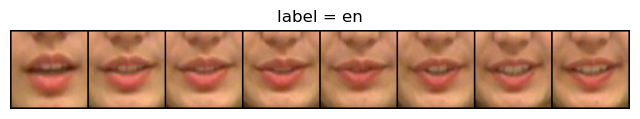

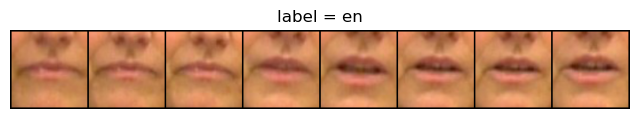

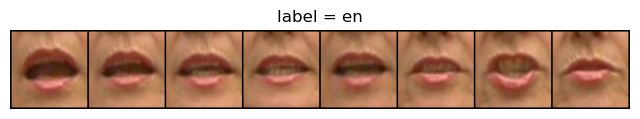

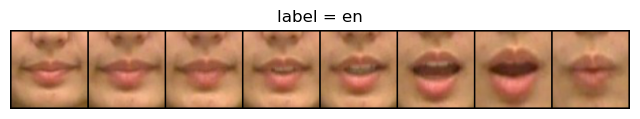

In [41]:
# ───────── Visualizza 4 clip random (8 frame ciascuno) ─────────
import random, matplotlib.pyplot as plt, torchvision.utils as vutils

# Carica il dataset da CSV (modifica max_len se necessario)
val_set = LanguageDataset("VidTIMIT/distillation_dataset.csv", max_len=32)

# Estrai e mostra 4 clip casuali
for idx in random.sample(range(len(val_set)), 4):
    vid, _,_,_,  lab = val_set[idx]          # vid: (C,T,H,W), float32 in [0,1]
    frames = vid[:, :8]                    # Primi 8 frame (C,8,H,W)
    frames = frames.permute(1, 0, 2, 3)    # → (8,C,H,W)

    grid = vutils.make_grid(frames, nrow=8, normalize=True)
    img  = grid.permute(1, 2, 0).cpu().numpy()  # → (H,W,C)
    label = 'en' if lab == 0 else 'it' if lab == 1 else 'sp' if lab == 2 else None

    plt.figure(figsize=(8, 2))
    plt.title(f"label = {label}")
    plt.imshow(img)
    plt.axis("off")
    plt.show()


In [ ]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-
# VER FINALEEEEEEE


import os, json, random, copy, math, contextlib
import numpy as np, pandas as pd

import torch
import torch.nn as nn
import torch.nn.functional as F

import torchvision.transforms as T
from torchvision.models.video import r3d_18, R3D_18_Weights
from torch.utils.data import Dataset, DataLoader, WeightedRandomSampler
from torch.optim import AdamW
from torch.optim.lr_scheduler import OneCycleLR
from sklearn.metrics import precision_recall_fscore_support, confusion_matrix, f1_score, accuracy_score, roc_auc_score

# ───────────── Config base ─────────────
SEED = 42
EPOCHS = 40
BATCH_SIZE = 8
LR, WD = 3e-4, 1e-3
NUM_WORKERS = 0

LANGS = ['en','it','es']
OUT_H, OUT_W, L = 64, 64, 32
MIXUP_ALPHA = 0.30
PATIENCE = 7
MAX_LR = 3e-4
DIV_FACTOR = 10
FINAL_DIV = 100

# Datasets
TRAIN_CSV = "BABELE/manifest_train.csv"
VAL_CSV   = "BABELE/manifest_test.csv"
CROSS_CSV = "EMODB/manifest_test.csv"

# Device & AMP
DEVICE = torch.device('cuda' if torch.cuda.is_available() else ('mps' if torch.backends.mps.is_available() else 'cpu'))
AMP_ENABLED = (DEVICE.type == 'cuda')
PIN_MEMORY = (DEVICE.type == 'cuda')

random.seed(SEED); np.random.seed(SEED); torch.manual_seed(SEED)
torch.backends.cudnn.benchmark = True

# ───────────── Metriche ─────────────
def macro_f1(y_true, y_pred):
    return precision_recall_fscore_support(y_true, y_pred,
                                           average='macro', zero_division=0)[2]

# ───────────── Augmentazioni ─────────────
class SpecAug3D:
    def __init__(self, H, W, T_mask=4, S_mask=4):
        self.tf = T.Compose([
            T.ToPILImage(),
            T.RandomResizedCrop((H,W), scale=(0.95,1.0), ratio=(1.0,1.0)),
            T.ColorJitter(brightness=0.3, contrast=0.3, saturation=0.2),
            T.RandomHorizontalFlip(0.5),
            T.ToTensor(),
        ])
        self.T_mask, self.S_mask = T_mask, S_mask
    def __call__(self, vid):
        frames = []
        for f in vid:
            img = (f*255).byte()
            t   = self.tf(img).squeeze(0)
            frames.append(t)
        vid = torch.stack(frames)
        L_,H,W = vid.shape
        if L_ > self.T_mask:
            t0 = random.randrange(0, L_-self.T_mask+1)
            vid[t0:t0+self.T_mask] = 0
        if H>self.S_mask and W>self.S_mask:
            fi = random.randrange(0, L_)
            h0 = random.randrange(0, H-self.S_mask+1)
            w0 = random.randrange(0, W-self.S_mask+1)
            vid[fi,h0:h0+self.S_mask,w0:w0+self.S_mask] = 0
        return vid

class RandomErasing3D:
    def __init__(self, p=0.3, size=(8,8,8)):
        self.p = p; self.d, self.h, self.w = size
    def __call__(self, vid):
        if random.random()>self.p: return vid
        L_,H,W = vid.shape
        sd = random.randint(0, max(0, L_-self.d))
        sh = random.randint(0, max(0, H-self.h))
        sw = random.randint(0, max(0, W-self.w))
        vid[sd:sd+self.d, sh:sh+self.h, sw:sw+self.w] = 0
        return vid

def mixup_return_params(x, y_onehot, alpha=MIXUP_ALPHA):
    if alpha <= 0:
        B = x.size(0); idx = torch.arange(B, device=x.device); lam = 1.0
        return x, y_onehot, lam, idx
    lam = np.random.beta(alpha, alpha)
    idx = torch.randperm(x.size(0), device=x.device)
    x_m = lam*x + (1-lam)*x[idx]
    y_m = lam*y_onehot + (1-lam)*y_onehot[idx]
    return x_m, y_m, float(lam), idx

# ───────────── Loss ─────────────
class SoftFocalLoss(nn.Module):
    def __init__(self, alpha=0.25, gamma=2.0):
        super().__init__(); self.alpha, self.gamma = alpha, gamma
    def forward(self, logits, y_soft):
        logp = F.log_softmax(logits,1)
        p    = logp.exp()
        ce   = -(y_soft * logp).sum(1)
        pt   = (y_soft * p).sum(1)
        return ( self.alpha * (1-pt)**self.gamma * ce ).mean()

# ───────────── MixStyle (invarianza leggera) ─────────────
class MixStyle(nn.Module):
    def __init__(self, p=0.3, α=0.1):
        super().__init__(); self.p, self.α = p, α
    def forward(self, x):
        if not self.training or random.random()>self.p:
            return x
        B,C = x.shape
        mu  = x.mean(1,keepdim=True)
        sig = (x.var(1,keepdim=True)+1e-6).sqrt()
        lm  = np.random.beta(self.α, self.α)
        perm= torch.randperm(B,device=x.device)
        mu2, sig2 = mu[perm], sig[perm]
        x_norm = (x-mu)/sig
        return x_norm*(lm*sig + (1-lm)*sig2) + (lm*mu + (1-lm)*mu2)

# ───────────── Dataset ─────────────
TEACHER_L10_COL = "layer10_mean_path"
TEACHER_L11_COL = "layer11_mean_path"

class MouthDS(Dataset):
    def __init__(self,csv,L=32,augment=False,need_teacher=False):
        df = pd.read_csv(csv).query('mouth_path.notna()').reset_index(drop=True)
        self.df, self.L = df, L
        self.l2i         = {l:i for i,l in enumerate(LANGS)}
        self.spec        = SpecAug3D(OUT_H,OUT_W) if augment else None
        self.randomerase = RandomErasing3D()      if augment else None
        self.need_teacher = need_teacher

        if self.need_teacher:
            if TEACHER_L10_COL not in self.df.columns or TEACHER_L11_COL not in self.df.columns:
                raise ValueError("Per KD L2 servono le colonne teacher: "
                                 f"'{TEACHER_L10_COL}', '{TEACHER_L11_COL}' nel CSV.")

    def _align(self,a):
        T0 = a.shape[0]
        if T0>=self.L: idx = np.linspace(0,T0-1,self.L).astype(int)
        else:          idx = np.concatenate([np.arange(T0), np.full(self.L-T0, T0-1)])
        return a[idx]
    def __len__(self): return len(self.df)

    def __getitem__(self,i):
        r = self.df.iloc[i]
        # ROI bocca
        a = np.load(r.mouth_path,allow_pickle=True).astype('float32')/255.
        if a.ndim==4 and a.shape[-1]==3: a = a.mean(-1)
        a = self._align(a)
        v = torch.from_numpy(a)
        if self.spec:        v = self.spec(v)
        if self.randomerase: v = self.randomerase(v)
        v5 = v.unsqueeze(0).unsqueeze(0)
        v5 = F.interpolate(v5, size=(self.L,OUT_H,OUT_W), mode='trilinear', align_corners=False)
        x  = (v5 - 0.5)/0.5
        x  = x.squeeze(0)                     # [1, L, H, W]
        y  = torch.tensor(self.l2i[str(r.label).lower()],dtype=torch.long)

        if not self.need_teacher:
            return x, y

        # teacher features (possono mancare → restituiamo None)
        l10 = l11 = None
        p10 = r.get(TEACHER_L10_COL, None)
        p11 = r.get(TEACHER_L11_COL, None)
        if isinstance(p10,str) and os.path.exists(p10):
            l10 = torch.from_numpy(np.load(p10)).float()
        if isinstance(p11,str) and os.path.exists(p11):
            l11 = torch.from_numpy(np.load(p11)).float()
        return x, y, l10, l11

def collate_with_optional_teacher(batch):
    """Batch (x,y,l10,l11) dove l10/l11 possono essere None."""
    xs, ys, l10s, l11s = [], [], [], []
    for item in batch:
        x,y,*rest = item
        xs.append(x); ys.append(y)
        if len(rest)==2:
            l10s.append(rest[0]); l11s.append(rest[1])
    x = torch.stack(xs,0)
    y = torch.stack(ys,0)
    if len(l10s)==0:  # no-teacher path
        return x, y
    return x, y, l10s, l11s

# ───────────── Model ─────────────
class Student(nn.Module):
    def __init__(self, proj_dim=128):
        super().__init__()
        self.backbone = r3d_18(weights=R3D_18_Weights.DEFAULT)
        self.backbone.fc = nn.Identity()
        self.mixstyle   = MixStyle(p=0.3, α=0.1)
        self.proj_v     = nn.Sequential(nn.LayerNorm(512), nn.Linear(512, proj_dim))
        self.head       = nn.Sequential(nn.LayerNorm(512), nn.Linear(512,256), nn.GELU(), nn.Dropout(0.1),
                                        nn.Linear(256,len(LANGS)))
    def forward(self, x):
        x = x.repeat(1,3,1,1,1)
        f = self.backbone(x)      # [B,512]
        f = self.mixstyle(f)
        logits = self.head(f)
        z_v = self.proj_v(f)      # [B,proj]
        return logits, f, z_v

# ───────────── Sampler ─────────────
def make_sampler(df):
    cnt = df['label'].astype(str).str.lower().value_counts().reindex(LANGS,fill_value=0).to_dict()
    w   = df['label'].astype(str).str.lower().map(lambda l:1.0/(cnt[l]+1e-6)).tolist()
    return WeightedRandomSampler(w, num_samples=len(w), replacement=True)

# ───────────── Loader builder ─────────────
def build_loaders(train_csv, val_csv, need_teacher):
    df_tr = pd.read_csv(train_csv)
    dl_tr = DataLoader(MouthDS(train_csv, L, augment=True,  need_teacher=need_teacher),
                       batch_size=BATCH_SIZE,
                       sampler=make_sampler(df_tr),
                       num_workers=NUM_WORKERS,
                       pin_memory=PIN_MEMORY,
                       collate_fn=(collate_with_optional_teacher if need_teacher else None))
    dl_va = DataLoader(MouthDS(val_csv,   L, augment=False, need_teacher=False),
                       batch_size=BATCH_SIZE, shuffle=False,
                       num_workers=NUM_WORKERS, pin_memory=PIN_MEMORY)
    return dl_tr, dl_va

# ───────────── Eval helpers ─────────────
def evaluate_manifest(csv_path, ckpt_path, title=""):
    model = Student().to(DEVICE)
    state = torch.load(ckpt_path, map_location=DEVICE)
    model.load_state_dict(state, strict=False)
    for m in model.backbone.modules():
        if isinstance(m, nn.BatchNorm3d):
            m.eval(); m.weight.requires_grad_(False); m.bias.requires_grad_(False)
    model.eval()

    dl = DataLoader(MouthDS(csv_path, L, augment=False, need_teacher=False),
                    batch_size=BATCH_SIZE, shuffle=False, num_workers=0, pin_memory=PIN_MEMORY)
    y_true, y_pred = [], []
    with torch.no_grad():
        for x,y in dl:
            x = x.to(DEVICE); y = y.to(DEVICE)
            logits, _, _ = model(x)
            y_true += y.cpu().tolist()
            y_pred += logits.argmax(1).cpu().tolist()
    y_true = np.array(y_true); y_pred = np.array(y_pred)
    all_labels = list(range(len(LANGS)))
    acc = accuracy_score(y_true, y_pred) if len(y_true) else 0.0
    mf1 = f1_score(y_true, y_pred, average="macro") if len(y_true) else 0.0
    cm  = confusion_matrix(y_true, y_pred, labels=all_labels) if len(y_true) else np.zeros((len(LANGS),len(LANGS)), dtype=int)
    print(f"\n[{title}] N={len(y_true)}  Acc={acc:.3f}  Macro-F1={mf1:.3f}")
    print(pd.DataFrame(cm, index=LANGS, columns=LANGS))
    return mf1, acc

def split_emodb_L1_L2(csv_path):
    df = pd.read_csv(csv_path)
    df['label'] = df['label'].astype(str).str.lower()
    l2 = df[df['label']=='en']
    l1 = df[df['label'].isin(['it','es'])]
    p_all = csv_path
    p_l1  = os.path.splitext(csv_path)[0] + "__L1_it_es.csv"
    p_l2  = os.path.splitext(csv_path)[0] + "__L2_en.csv"
    l1[['mouth_path','label']].to_csv(p_l1, index=False)
    l2[['mouth_path','label']].to_csv(p_l2, index=False)
    return p_all, p_l1, p_l2

def build_enL1_from_babele(train_csv, val_csv, out_csv="reports/EN_L1_from_BABELE.csv"):
    os.makedirs(os.path.dirname(out_csv), exist_ok=True)
    dft = pd.read_csv(train_csv); dfv = pd.read_csv(val_csv)
    df  = pd.concat([dft, dfv], ignore_index=True)
    df  = df[df['label'].astype(str).str.lower()=='en'][['mouth_path','label']].reset_index(drop=True)
    if len(df)==0: raise ValueError("Nessuna riga 'en' trovata in BABELE train+val.")
    df.to_csv(out_csv, index=False)
    return out_csv

def _collect_en_scores(csv_path, ckpt_path, run_dir=None, tag=""):
    model = Student().to(DEVICE)
    state = torch.load(ckpt_path, map_location=DEVICE)
    model.load_state_dict(state, strict=False)
    for m in model.backbone.modules():
        if isinstance(m, nn.BatchNorm3d):
            m.eval(); m.weight.requires_grad_(False); m.bias.requires_grad_(False)
    model.eval()

    dl = DataLoader(MouthDS(csv_path, L, augment=False, need_teacher=False),
                    batch_size=BATCH_SIZE, shuffle=False, num_workers=0, pin_memory=PIN_MEMORY)
    en_idx = LANGS.index('en')
    probs, margins, preds, paths = [], [], [], []
    with torch.no_grad():
        for x,y in dl:
            x = x.to(DEVICE)
            logits,_,_ = model(x)
            pr = F.softmax(logits,1)
            p_en = pr[:, en_idx]
            logit_en = logits[:, en_idx]
            others = torch.stack([logits[:, LANGS.index('it')], logits[:, LANGS.index('es')]], dim=1)
            margin = logit_en - others.max(dim=1).values
            pred = pr.argmax(1)
            probs.append(p_en.cpu().numpy()); margins.append(margin.cpu().numpy())
            preds.extend((pred.cpu()==en_idx).tolist())
            paths.extend(dl.dataset.df['mouth_path'].iloc[len(paths):len(paths)+len(p_en)].tolist())
    probs = np.concatenate(probs) if probs else np.array([])
    margins = np.concatenate(margins) if margins else np.array([])
    acc_en = float(np.mean(preds)) if len(preds) else 0.0
    if run_dir is not None:
        os.makedirs(run_dir, exist_ok=True)
        pd.DataFrame({'path':paths,'p_en':probs,'margin':margins,'pred_is_en':preds}).to_csv(
            os.path.join(run_dir, f"{tag}__per_sample.csv"), index=False)
    return dict(N=len(probs), acc_en=acc_en, p_en=probs, margin=margins)

def eval_enL1_vs_enL2(enL1_csv, enL2_csv, ckpt_path, run_dir=None):
    sL1 = _collect_en_scores(enL1_csv, ckpt_path, run_dir, tag="EN_L1")
    sL2 = _collect_en_scores(enL2_csv, ckpt_path, run_dir, tag="EN_L2")
    y  = np.concatenate([np.ones(sL1['N']), np.zeros(sL2['N'])]) if (sL1['N'] and sL2['N']) else np.array([0,1])
    sp = np.concatenate([sL1['p_en'], sL2['p_en']]) if (sL1['N'] and sL2['N']) else np.array([0.5,0.5])
    sm = np.concatenate([sL1['margin'], sL2['margin']]) if (sL1['N'] and sL2['N']) else np.array([0.0,0.0])
    auc_p = roc_auc_score(y, sp) if len(np.unique(y))>1 else float('nan')
    auc_m = roc_auc_score(y, sm) if len(np.unique(y))>1 else float('nan')
    print("\n=== EN L1 (BABELE train+val) vs EN L2 (EMODB) ===")
    print(f"EN_L1: N={sL1['N']}  Acc(en)={sL1['acc_en']:.3f}  p(en) mean={np.mean(sL1['p_en']) if sL1['N'] else float('nan'):.3f}  margin mean={np.mean(sL1['margin']) if sL1['N'] else float('nan'):.3f}")
    print(f"EN_L2: N={sL2['N']}  Acc(en)={sL2['acc_en']:.3f}  p(en) mean={np.mean(sL2['p_en']) if sL2['N'] else float('nan'):.3f}  margin mean={np.mean(sL2['margin']) if sL2['N'] else float('nan'):.3f}")
    print(f"AUC p(en)={auc_p:.3f}   AUC margin={auc_m:.3f}")
    return {'Acc_en_L1': sL1['acc_en'], 'Acc_en_L2': sL2['acc_en'], 'AUC_p_en': float(auc_p),
            'AUC_margin': float(auc_m), 'N_en_L1': sL1['N'], 'N_en_L2': sL2['N']}

# ───────────── Utility: infer dims teacher una volta ─────────────
def infer_teacher_dims(csv_path):
    ds = MouthDS(csv_path, L, augment=False, need_teacher=True)
    for i in range(len(ds)):
        _, _, l10, l11 = ds[i]
        if (isinstance(l10, torch.Tensor)) and (isinstance(l11, torch.Tensor)):
            return int(l10.shape[0]), int(l11.shape[0])
    return 512, 512  # fallback prudente

# ───────────── Training di UNA RUN ─────────────
def train_one_run(run_cfg):
    RUN_ID         = run_cfg['run_id']

    # L2 controls
    USE_L2_ML      = run_cfg.get('USE_L2_ML', False)
    LAMBDA_L2_TOP  = float(run_cfg.get('LAMBDA_L2_TOP', 0.0))
    LAMBDA_L2_MID  = float(run_cfg.get('LAMBDA_L2_MID', 0.0))
    L2_APPLY_PROB  = float(run_cfg.get('L2_APPLY_PROB', 1.0))   # p con cui applichi L2 per-sample
    L2_SCHEDULE    = run_cfg.get('L2_SCHEDULE', 'const')        # 'const' | 'warmup'
    L2_WARMUP_E    = int(run_cfg.get('L2_WARMUP_EPOCHS', 5))    # epoche warm-up
    PROJ_DIM       = int(run_cfg.get('PROJ_DIM', 128))

    need_teacher = USE_L2_ML
    dl_tr, dl_va = build_loaders(TRAIN_CSV, VAL_CSV, need_teacher=need_teacher)

    model = Student(proj_dim=PROJ_DIM).to(DEVICE)
    # teste L2 (student side)
    proj_l11_top = nn.Linear(512, PROJ_DIM).to(DEVICE)  # teacher top (→512 via adapter) → proj_dim
    proj_l10_mid = nn.Linear(512, 512).to(DEVICE)       # teacher mid (→512 via adapter) → 512

    # FREEZE BN
    for m in model.backbone.modules():
        if isinstance(m, nn.BatchNorm3d):
            m.eval(); m.weight.requires_grad_(False); m.bias.requires_grad_(False)

    # PRE-INIT ADAPTERS (teacher dims → 512) PRIMA di creare optimizer/scheduler
    if USE_L2_ML:
        d10, d11 = infer_teacher_dims(TRAIN_CSV)   # es. Whisper-small: 768,768
        mid_adapter = (nn.Identity().to(DEVICE) if d10 == 512 else nn.Linear(d10, 512).to(DEVICE))
        top_adapter = (nn.Identity().to(DEVICE) if d11 == 512 else nn.Linear(d11, 512).to(DEVICE))
    else:
        mid_adapter = nn.Identity().to(DEVICE)
        top_adapter = nn.Identity().to(DEVICE)

    # Optimizer con TUTTI i param dentro
    params = list(model.parameters()) \
           + list(proj_l11_top.parameters()) \
           + list(proj_l10_mid.parameters())
    if isinstance(top_adapter, nn.Linear): params += list(top_adapter.parameters())
    if isinstance(mid_adapter, nn.Linear): params += list(mid_adapter.parameters())
    opt   = AdamW(params, lr=LR, weight_decay=WD)

    total = EPOCHS * len(dl_tr)
    sched = OneCycleLR(opt, max_lr=MAX_LR, total_steps=total, pct_start=0.3,
                       div_factor=DIV_FACTOR, final_div_factor=FINAL_DIV, anneal_strategy='cos')
    crit  = SoftFocalLoss()

    run_name = (f"{RUN_ID}__L2{int(USE_L2_ML)}"
                f"__top{LAMBDA_L2_TOP:g}__mid{LAMBDA_L2_MID:g}"
                f"__p{L2_APPLY_PROB:g}__sched{L2_SCHEDULE}")
    ckpt_dir = os.path.join("ckpts", run_name); os.makedirs(ckpt_dir, exist_ok=True)
    best_path_student = os.path.join(ckpt_dir, "best_student.pt")
    best_path_proj_l11 = os.path.join(ckpt_dir, "best_proj_l11_top.pt")
    best_path_proj_l10 = os.path.join(ckpt_dir, "best_proj_l10_mid.pt")

    last_path_student = os.path.join(ckpt_dir, "last_student.pt")
    last_path_proj_l11 = os.path.join(ckpt_dir, "last_proj_l11_top.pt")
    last_path_proj_l10 = os.path.join(ckpt_dir, "last_proj_l10_mid.pt")

    run_dir = os.path.join("reports", run_name); os.makedirs(run_dir, exist_ok=True)
    epoch_logs = []
    best_f1, patience = 0.0, 0

    print(f"\n===== TRAIN {RUN_ID} | USE_L2_ML={USE_L2_ML}  top={LAMBDA_L2_TOP} mid={LAMBDA_L2_MID}  p={L2_APPLY_PROB}  sched={L2_SCHEDULE} =====")

    # helper per schedule
    def eff_lambda(base, ep):
        if L2_SCHEDULE == 'warmup' and L2_WARMUP_E>0:
            return float(base) * min(1.0, ep / L2_WARMUP_E)
        return float(base)

    for ep in range(1, EPOCHS+1):
        model.train(); proj_l11_top.train(); proj_l10_mid.train()
        if isinstance(top_adapter, nn.Module): top_adapter.train()
        if isinstance(mid_adapter, nn.Module): mid_adapter.train()

        sup_loss_sum = 0.0
        l2_top_sum = 0.0
        l2_mid_sum = 0.0
        cover_cnt = 0
        seen_cnt  = 0

        for batch in dl_tr:
            if USE_L2_ML:
                x, y, l10, l11 = batch
            else:
                x, y = batch
                l10 = l11 = None

            x = x.to(DEVICE); y = y.to(DEVICE)

            # mixup
            y_onehot = F.one_hot(y, len(LANGS)).float()
            x_m, y_m, lam, idx = mixup_return_params(x, y_onehot)

            opt.zero_grad(set_to_none=True)
            amp_ctx = torch.cuda.amp.autocast if AMP_ENABLED else contextlib.nullcontext

            with amp_ctx():
                logits_m, f_m, z_v_m = model(x_m)
                loss_sup = crit(logits_m, y_m)

                # L2 losses
                l2_top = torch.tensor(0.0, device=DEVICE)
                l2_mid = torch.tensor(0.0, device=DEVICE)

                if USE_L2_ML:
                    logits_c, f_c, z_v_c = model(x)

                    B = x.size(0)
                    have = torch.tensor([ (isinstance(l10[i], torch.Tensor)) and (isinstance(l11[i], torch.Tensor))
                                          for i in range(B) ],
                                        device=DEVICE, dtype=torch.bool)
                    seen_cnt += int(B); cover_cnt += int(have.sum().item())

                    if have.any():
                        mask_idx = torch.nonzero(have).squeeze(1).tolist()
                        l10_t = torch.stack([l10[i2].to(DEVICE) for i2 in mask_idx], dim=0)  # [M, d10]
                        l11_t = torch.stack([l11[i2].to(DEVICE) for i2 in mask_idx], dim=0)  # [M, d11]

                        # adattatori verso 512
                        l10_512 = mid_adapter(l10_t)  # [M,512]
                        l11_512 = top_adapter(l11_t)  # [M,512]

                        f_sel  = f_c[have]            # [M,512]
                        z_sel  = z_v_c[have]          # [M,proj]
                        pt     = proj_l11_top(l11_512)  # [M,proj]
                        pm     = proj_l10_mid(l10_512)  # [M,512]

                        # applicazione stocastica "light"
                        if L2_APPLY_PROB < 1.0:
                            keep = (torch.rand(f_sel.size(0), device=DEVICE) < L2_APPLY_PROB)
                        else:
                            keep = torch.ones(f_sel.size(0), device=DEVICE, dtype=torch.bool)

                        if keep.any():
                            z_n  = F.normalize(z_sel[keep], dim=1)
                            pt_n = F.normalize(pt[keep],   dim=1)
                            f_n  = F.normalize(f_sel[keep], dim=1)
                            pm_n = F.normalize(pm[keep],    dim=1)

                            lam_top = eff_lambda(LAMBDA_L2_TOP, ep)
                            lam_mid = eff_lambda(LAMBDA_L2_MID, ep)

                            l2_top = F.mse_loss(z_n, pt_n) if lam_top>0 else torch.tensor(0.0, device=DEVICE)
                            l2_mid = F.mse_loss(f_n, pm_n) if lam_mid>0 else torch.tensor(0.0, device=DEVICE)

                            loss_sup = loss_sup + lam_top * l2_top + lam_mid * l2_mid

                loss = loss_sup

            loss.backward()
            torch.nn.utils.clip_grad_norm_( list(model.parameters())
                                           + list(proj_l11_top.parameters())
                                           + list(proj_l10_mid.parameters())
                                           + (list(top_adapter.parameters()) if isinstance(top_adapter, nn.Linear) else [])
                                           + (list(mid_adapter.parameters()) if isinstance(mid_adapter, nn.Linear) else []),
                                           1.0)
            opt.step(); opt.zero_grad()
            sched.step()

            with torch.no_grad():
                sup_loss_sum += float(loss_sup.item())
                l2_top_sum   += float(l2_top.item()) if isinstance(l2_top, torch.Tensor) else float(l2_top)
                l2_mid_sum   += float(l2_mid.item()) if isinstance(l2_mid, torch.Tensor) else float(l2_mid)

        # ── Validation ───────────────────────────
        model.eval()
        preds, gts = [], []
        with torch.no_grad():
            for x,y in DataLoader(MouthDS(VAL_CSV, L, augment=False, need_teacher=False),
                                  batch_size=BATCH_SIZE, shuffle=False, num_workers=0, pin_memory=PIN_MEMORY):
                x = x.to(DEVICE); y = y.to(DEVICE)
                logits,_,_ = model(x)
                preds += logits.argmax(1).cpu().tolist()
                gts   += y.cpu().tolist()
        f1 = macro_f1(gts, preds)
        cm = confusion_matrix(gts, preds, labels=list(range(len(LANGS))))
        print(f"Epoch {ep:02d}  Val-F1={f1:.3f}")
        print(pd.DataFrame(cm, index=LANGS, columns=LANGS))

        # log per-epoca
        loss_sup_mean = sup_loss_sum / max(1, len(dl_tr))
        l2_top_mean   = l2_top_sum / max(1, len(dl_tr))
        l2_mid_mean   = l2_mid_sum / max(1, len(dl_tr))
        cover_rate    = (cover_cnt / max(1, seen_cnt)) * 100.0
        epoch_logs.append(dict(epoch=ep, val_f1=float(f1),
                               loss_sup_mean=loss_sup_mean,
                               loss_l2_top_mean=l2_top_mean,
                               loss_l2_mid_mean=l2_mid_mean,
                               teacher_cover_pct=cover_rate))
        pd.DataFrame(epoch_logs).to_csv(os.path.join(run_dir, "epoch_log.csv"), index=False)

        # early stopping
        if f1>best_f1:
            best_f1, patience = f1, 0
            torch.save(model.state_dict(), best_path_student)
            torch.save(proj_l11_top.state_dict(), best_path_proj_l11)
            torch.save(proj_l10_mid.state_dict(), best_path_proj_l10)
            print(f"  → New best: Val-F1={f1:.3f}  saved: {best_path_student}")
        else:
            patience += 1
            if patience >= PATIENCE:
                print("Early stopping"); break

    # save last
    torch.save(model.state_dict(), last_path_student)
    torch.save(proj_l11_top.state_dict(), last_path_proj_l11)
    torch.save(proj_l10_mid.state_dict(), last_path_proj_l10)

    print(f"Best Val-F1 (VAL) = {best_f1:.3f}")
    return best_path_student, run_name

# ───────────── RUN SUITE + REPORT ─────────────
def run_suite():
    # Esperimenti focalizzati su L2 (nessuna EMB-KD/InfoNCE)
    EXPERIMENTS = [
        # Baseline — no KD
        dict(run_id="B0_noKD",
             USE_L2_ML=False, LAMBDA_L2_TOP=0.0, LAMBDA_L2_MID=0.0,
             L2_APPLY_PROB=0.0, L2_SCHEDULE='const'),

        # L2 both (top+mid) — strong
        dict(run_id="B1_L2_both",
             USE_L2_ML=True, LAMBDA_L2_TOP=1.0, LAMBDA_L2_MID=0.5,
             L2_APPLY_PROB=1.0, L2_SCHEDULE='const'),

        # Solo top
        dict(run_id="B2_L2_top_only",
             USE_L2_ML=True, LAMBDA_L2_TOP=1.0, LAMBDA_L2_MID=0.0,
             L2_APPLY_PROB=1.0, L2_SCHEDULE='const'),

        # Solo mid
        dict(run_id="B3_L2_mid_only",
             USE_L2_ML=True, LAMBDA_L2_TOP=0.0, LAMBDA_L2_MID=0.5,
             L2_APPLY_PROB=1.0, L2_SCHEDULE='const'),

        # L2 “light” (warm-up + probabilità 0.3)
        dict(run_id="B4_L2_both_light",
             USE_L2_ML=True, LAMBDA_L2_TOP=0.5, LAMBDA_L2_MID=0.25,
             L2_APPLY_PROB=0.3, L2_SCHEDULE='warmup', L2_WARMUP_EPOCHS=5),
    ]

    results = []
    emodb_all, emodb_L1, emodb_L2 = split_emodb_L1_L2(CROSS_CSV)
    enL1_csv = build_enL1_from_babele(TRAIN_CSV, VAL_CSV, out_csv="reports/EN_L1_from_BABELE.csv")

    for cfg in EXPERIMENTS:
        best_ckpt, run_name = train_one_run(cfg)

        # Eval IN-domain (VAL)
        f1_in, acc_in = evaluate_manifest(VAL_CSV, best_ckpt, title=f"{cfg['run_id']}__IN_VAL")

        # Eval CROSS EMODB (all, L1, L2)
        f1_x_all, acc_x_all = evaluate_manifest(emodb_all, best_ckpt, title=f"{cfg['run_id']}__CROSS_EMODB_all")
        f1_x_L1,  acc_x_L1  = evaluate_manifest(emodb_L1,  best_ckpt, title=f"{cfg['run_id']}__CROSS_EMODB_L1_it_es")
        f1_x_L2,  acc_x_L2  = evaluate_manifest(emodb_L2,  best_ckpt, title=f"{cfg['run_id']}__CROSS_EMODB_L2_en")

        # EN L1 (TRAIN+VAL) vs EN L2 (EMODB)
        run_dir = os.path.join("reports", run_name)
        en_stats = eval_enL1_vs_enL2(enL1_csv, emodb_L2, best_ckpt, run_dir=run_dir)

        results.append({
            "run": cfg['run_id'],
            "USE_L2_ML": int(cfg['USE_L2_ML']),
            "L2_top": cfg['LAMBDA_L2_TOP'],
            "L2_mid": cfg['LAMBDA_L2_MID'],
            "L2_apply_prob": cfg.get('L2_APPLY_PROB', 1.0),
            "L2_schedule": cfg.get('L2_SCHEDULE', 'const'),
            "F1_in":  float(f1_in),
            "F1_x_all": float(f1_x_all),
            "F1_x_L1": float(f1_x_L1),
            "F1_x_L2": float(f1_x_L2),
            "Acc_en_L1": en_stats['Acc_en_L1'],
            "Acc_en_L2": en_stats['Acc_en_L2'],
            "AUC_p_en":  en_stats['AUC_p_en'],
            "AUC_margin": en_stats['AUC_margin'],
        })

    df = pd.DataFrame(results)
    base = df.iloc[0]
    df["ΔF1_in_vs_baseline"]   = df["F1_in"]    - base["F1_in"]
    df["ΔF1_x_vs_baseline"]    = df["F1_x_all"] - base["F1_x_all"]
    df["ΔAcc_en_L1_vs_base"]   = df["Acc_en_L1"] - base["Acc_en_L1"]
    df["ΔAcc_en_L2_vs_base"]   = df["Acc_en_L2"] - base["Acc_en_L2"]

    print("\n================ L2-ONLY ABLATION SUMMARY ================")
    print(df.to_string(index=False))
    os.makedirs("reports", exist_ok=True)
    out_csv = "reports/kd_l2_only_ablation.csv"
    df.to_csv(out_csv, index=False)
    print(f"\nSaved: {out_csv}")

if __name__ == "__main__":
    run_suite()



===== TRAIN B0_noKD | USE_L2_ML=False  top=0.0 mid=0.0  p=0.0  sched=const =====
Epoch 01  Val-F1=0.340
    en  it  es
en   9   0   0
it   6   2   2
es   6   3   1
  → New best: Val-F1=0.340  saved: ckpts/B0_noKD__L20__top0__mid0__p0__schedconst/best_student.pt
Epoch 02  Val-F1=0.360
    en  it  es
en   6   2   1
it   5   3   2
es   5   3   2
  → New best: Val-F1=0.360  saved: ckpts/B0_noKD__L20__top0__mid0__p0__schedconst/best_student.pt
Epoch 03  Val-F1=0.488
    en  it  es
en   5   4   0
it   3   4   3
es   2   3   5
  → New best: Val-F1=0.488  saved: ckpts/B0_noKD__L20__top0__mid0__p0__schedconst/best_student.pt
Epoch 04  Val-F1=0.453
    en  it  es
en   3   6   0
it   3   5   2
es   2   3   5
Epoch 05  Val-F1=0.634
    en  it  es
en   3   5   1
it   0   8   2
es   0   2   8
  → New best: Val-F1=0.634  saved: ckpts/B0_noKD__L20__top0__mid0__p0__schedconst/best_student.pt
Epoch 06  Val-F1=0.613
    en  it  es
en   4   4   1
it   0   6   4
es   1   1   8
Epoch 07  Val-F1=0.584
    e

In [ ]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-
# VER FINALE con reader CSV robusto + loader npy eterogenei

import os, csv, json, random, copy, math, contextlib
import numpy as np, pandas as pd

import torch
import torch.nn as nn
import torch.nn.functional as F

import torchvision.transforms as T
from torchvision.models.video import r3d_18, R3D_18_Weights
from torch.utils.data import Dataset, DataLoader, WeightedRandomSampler
from torch.optim import AdamW
from torch.optim.lr_scheduler import OneCycleLR
from sklearn.metrics import precision_recall_fscore_support, confusion_matrix, f1_score, accuracy_score, roc_auc_score

# ───────────── Config base ─────────────
SEED = 42
EPOCHS = 40
BATCH_SIZE = 8
LR, WD = 3e-4, 1e-3
NUM_WORKERS = 0

LANGS = ['en','it','es']
OUT_H, OUT_W, L = 64, 64, 32
MIXUP_ALPHA = 0.30
PATIENCE = 7
MAX_LR = 3e-4
DIV_FACTOR = 10
FINAL_DIV = 100

# Datasets
TRAIN_CSV = "BABELE/manifest_train.csv"
VAL_CSV   = "BABELE/manifest_test.csv"
CROSS_CSV = "EMODB/EMODB_neutro_2.csv"

# Device & AMP
DEVICE = torch.device('cuda' if torch.cuda.is_available() else ('mps' if torch.backends.mps.is_available() else 'cpu'))
AMP_ENABLED = (DEVICE.type == 'cuda')
PIN_MEMORY = (DEVICE.type == 'cuda')

random.seed(SEED); np.random.seed(SEED); torch.manual_seed(SEED)
torch.backends.cudnn.benchmark = True

# ───────────── Lettura manifest robusta ─────────────
def read_manifest_robust(csv_path):
    """
    Lettura robusta per manifest con virgole/virgolette sporche.
    Richiede almeno colonne: mouth_path, label (nomi case-insensitive).
    Normalizza 'label' in lowercase e ripulisce 'mouth_path'.
    Mantiene tutte le altre colonne (es. teacher).
    """
    rows = []
    with open(csv_path, 'r', encoding='utf-8-sig', errors='replace', newline='') as f:
        rdr = csv.reader(f, delimiter=',', quotechar='"', escapechar='\\', strict=False)
        for r in rdr:
            rows.append(r)

    if not rows:
        raise ValueError(f"CSV vuoto: {csv_path}")

    # uniforma lunghezze righe
    max_cols = max(len(r) for r in rows)
    rows = [r + ['']*(max_cols - len(r)) for r in rows]

    # header
    header = [h.strip() if h and h.strip() else f"col_{i}" for i, h in enumerate(rows[0])]
    df = pd.DataFrame(rows[1:], columns=header)

    # map nomi simili → richiesti
    def _find_col(name):
        cands = [c for c in df.columns if c.strip().lower() == name]
        return cands[0] if cands else None

    lab_col = _find_col('label')
    mth_col = _find_col('mouth_path')
    if lab_col is None or mth_col is None:
        raise ValueError(f"Nel CSV '{csv_path}' servono colonne 'label' e 'mouth_path' (case-insensitive).")

    if lab_col != 'label':      df.rename(columns={lab_col: 'label'}, inplace=True)
    if mth_col != 'mouth_path': df.rename(columns={mth_col: 'mouth_path'}, inplace=True)

    # pulizia base
    df['label'] = df['label'].astype(str).str.strip().str.lower()
    df['mouth_path'] = df['mouth_path'].astype(str).str.strip()
    df = df[(df['mouth_path'] != '') & df['mouth_path'].notna()]

    return df

def save_fixed_manifest(src_csv, dst_csv):
    """Legge in modo robusto e salva un CSV pulito (comodo per ispezione)."""
    os.makedirs(os.path.dirname(dst_csv) or '.', exist_ok=True)
    df = read_manifest_robust(src_csv)
    df.to_csv(dst_csv, index=False)
    cnt = df['label'].value_counts().reindex(LANGS, fill_value=0).to_dict()
    print(f"[FIX] salvato: {dst_csv}   righe={len(df)}   counts={cnt}")
    return dst_csv

def debug_compare_counts(csv_path):
    """Confronto rapido conteggi label: pandas standard vs reader robusto."""
    try:
        df_naive = pd.read_csv(csv_path)
        cnt_naive = df_naive['label'].astype(str).str.lower().value_counts().reindex(LANGS, fill_value=0).to_dict()
    except Exception as e:
        cnt_naive = f"errore pandas: {e}"

    df_rb = read_manifest_robust(csv_path)
    cnt_rb = df_rb['label'].value_counts().reindex(LANGS, fill_value=0).to_dict()

    print(f"[COMPARE] {csv_path}")
    print(f" - pandas: {cnt_naive}")
    print(f" - robust: {cnt_rb}")

# ───────────── Metriche ─────────────
def macro_f1(y_true, y_pred):
    return precision_recall_fscore_support(y_true, y_pred,
                                           average='macro', zero_division=0)[2]

# ───────────── Augmentazioni ─────────────
class SpecAug3D:
    def __init__(self, H, W, T_mask=4, S_mask=4):
        self.tf = T.Compose([
            T.ToPILImage(),
            T.RandomResizedCrop((H,W), scale=(0.95,1.0), ratio=(1.0,1.0)),
            T.ColorJitter(brightness=0.3, contrast=0.3, saturation=0.2),
            T.RandomHorizontalFlip(0.5),
            T.ToTensor(),
        ])
        self.T_mask, self.S_mask = T_mask, S_mask
    def __call__(self, vid):
        frames = []
        for f in vid:
            img = (f*255).byte()
            t   = self.tf(img).squeeze(0)
            frames.append(t)
        vid = torch.stack(frames)
        L_,H,W = vid.shape
        if L_ > self.T_mask:
            t0 = random.randrange(0, L_-self.T_mask+1)
            vid[t0:t0+self.T_mask] = 0
        if H>self.S_mask and W>self.S_mask:
            fi = random.randrange(0, L_)
            h0 = random.randrange(0, H-self.S_mask+1)
            w0 = random.randrange(0, W-self.S_mask+1)
            vid[fi,h0:h0+self.S_mask,w0:w0+self.S_mask] = 0
        return vid

class RandomErasing3D:
    def __init__(self, p=0.3, size=(8,8,8)):
        self.p = p; self.d, self.h, self.w = size
    def __call__(self, vid):
        if random.random()>self.p: return vid
        L_,H,W = vid.shape
        sd = random.randint(0, max(0, L_-self.d))
        sh = random.randint(0, max(0, H-self.h))
        sw = random.randint(0, max(0, W-self.w))
        vid[sd:sd+self.d, sh:sh+self.h, sw:sw+self.w] = 0
        return vid

def mixup_return_params(x, y_onehot, alpha=MIXUP_ALPHA):
    if alpha <= 0:
        B = x.size(0); idx = torch.arange(B, device=x.device); lam = 1.0
        return x, y_onehot, lam, idx
    lam = np.random.beta(alpha, alpha)
    idx = torch.randperm(x.size(0), device=x.device)
    x_m = lam*x + (1-lam)*x[idx]
    y_m = lam*y_onehot + (1-lam)*y_onehot[idx]
    return x_m, y_m, float(lam), idx

# ───────────── Loss ─────────────
class SoftFocalLoss(nn.Module):
    def __init__(self, alpha=0.25, gamma=2.0):
        super().__init__(); self.alpha, self.gamma = alpha, gamma
    def forward(self, logits, y_soft):
        logp = F.log_softmax(logits,1)
        p    = logp.exp()
        ce   = -(y_soft * logp).sum(1)
        pt   = (y_soft * p).sum(1)
        return ( self.alpha * (1-pt)**self.gamma * ce ).mean()

# ───────────── MixStyle (invarianza leggera) ─────────────
class MixStyle(nn.Module):
    def __init__(self, p=0.3, α=0.1):
        super().__init__(); self.p, self.α = p, α
    def forward(self, x):
        if not self.training or random.random()>self.p:
            return x
        B,C = x.shape
        mu  = x.mean(1,keepdim=True)
        sig = (x.var(1,keepdim=True)+1e-6).sqrt()
        lm  = np.random.beta(self.α, self.α)
        perm= torch.randperm(B,device=x.device)
        mu2, sig2 = mu[perm], sig[perm]
        x_norm = (x-mu)/sig
        return x_norm*(lm*sig + (1-lm)*sig2) + (lm*mu + (1-lm)*mu2)

# ───────────── LOADER ROBUSTO (npy → THW in [0,1]) ─────────────
def _guess_perm_to_THW(shape):
    cand = [(0,1,2),(0,2,1),(1,0,2),(1,2,0),(2,0,1),(2,1,0)]
    def score(idx):
        t,h,w = [shape[i] for i in idx]
        pen_t = 0 if (8 <= t <= 256) else 1000 + abs(t-32)
        pen_hw = abs(h-64)+abs(w-64)
        return pen_t + pen_hw
    return min(cand, key=score)

def safe_np_load_to_THW01(path):
    a = np.load(path, allow_pickle=True)
    if a.ndim == 4 and a.shape[-1] in (1,3):
        a = a.mean(-1) if a.shape[-1]==3 else a[...,0]
    if a.ndim != 3:
        raise ValueError(f"{path}: atteso 3D o 4D, trovato shape {a.shape}")
    perm = _guess_perm_to_THW(a.shape)
    if perm != (0,1,2):
        a = np.transpose(a, perm)
    a = a.astype('float32', copy=False)
    vmax = float(np.nanmax(a)) if a.size else 0.0
    if vmax > 1.5:
        a = a / 255.0
    a = np.nan_to_num(a, nan=0.0, posinf=1.0, neginf=0.0)
    return a  # (T,H,W) in [0,1]

# ───────────── Dataset ─────────────
TEACHER_L10_COL = "layer10_mean_path"
TEACHER_L11_COL = "layer11_mean_path"

class MouthDS(Dataset):
    def __init__(self,csv,L=32,augment=False,need_teacher=False):
        df = read_manifest_robust(csv).reset_index(drop=True)
        self.df, self.L = df, L
        self.l2i         = {l:i for i,l in enumerate(LANGS)}
        self.spec        = SpecAug3D(OUT_H,OUT_W) if augment else None
        self.randomerase = RandomErasing3D()      if augment else None
        self.need_teacher = need_teacher

        if self.need_teacher:
            if TEACHER_L10_COL not in self.df.columns or TEACHER_L11_COL not in self.df.columns:
                raise ValueError("Per KD L2 servono le colonne teacher: "
                                 f"'{TEACHER_L10_COL}', '{TEACHER_L11_COL}' nel CSV.")

    def _align(self,a):
        T0 = a.shape[0]
        if T0>=self.L: idx = np.linspace(0,T0-1,self.L).astype(int)
        else:          idx = np.concatenate([np.arange(T0), np.full(self.L-T0, T0-1)])
        return a[idx]
    def __len__(self): return len(self.df)

    def __getitem__(self,i):
        r = self.df.iloc[i]
        a = safe_np_load_to_THW01(r.mouth_path)
        a = self._align(a)
        v = torch.from_numpy(a)
        if self.spec:        v = self.spec(v)
        if self.randomerase: v = self.randomerase(v)
        v5 = v.unsqueeze(0).unsqueeze(0)  # [1,1,T,H,W]
        v5 = F.interpolate(v5, size=(self.L,OUT_H,OUT_W), mode='trilinear', align_corners=False)
        x  = (v5 - 0.5)/0.5               # normalizzazione train-like
        x  = x.squeeze(0)                 # [1, L, H, W]
        y  = torch.tensor(self.l2i[str(r.label).lower()],dtype=torch.long)

        if not self.need_teacher:
            return x, y

        l10 = l11 = None
        p10 = r.get(TEACHER_L10_COL, None)
        p11 = r.get(TEACHER_L11_COL, None)
        if isinstance(p10,str) and os.path.exists(p10):
            l10 = torch.from_numpy(np.load(p10)).float()
        if isinstance(p11,str) and os.path.exists(p11):
            l11 = torch.from_numpy(np.load(p11)).float()
        return x, y, l10, l11

def collate_with_optional_teacher(batch):
    xs, ys, l10s, l11s = [], [], [], []
    for item in batch:
        x,y,*rest = item
        xs.append(x); ys.append(y)
        if len(rest)==2:
            l10s.append(rest[0]); l11s.append(rest[1])
    x = torch.stack(xs,0)
    y = torch.stack(ys,0)
    if len(l10s)==0:
        return x, y
    return x, y, l10s, l11s

# ───────────── Model ─────────────
class Student(nn.Module):
    def __init__(self, proj_dim=128):
        super().__init__()
        self.backbone = r3d_18(weights=R3D_18_Weights.DEFAULT)
        self.backbone.fc = nn.Identity()
        self.mixstyle   = MixStyle(p=0.3, α=0.1)
        self.proj_v     = nn.Sequential(nn.LayerNorm(512), nn.Linear(512, proj_dim))
        self.head       = nn.Sequential(nn.LayerNorm(512), nn.Linear(512,256), nn.GELU(), nn.Dropout(0.1),
                                        nn.Linear(256,len(LANGS)))
    def forward(self, x):
        x = x.repeat(1,3,1,1,1)
        f = self.backbone(x)      # [B,512]
        f = self.mixstyle(f)
        logits = self.head(f)
        z_v = self.proj_v(f)      # [B,proj]
        return logits, f, z_v

# ───────────── Sampler ─────────────
def make_sampler(df):
    cnt = df['label'].astype(str).str.lower().value_counts().reindex(LANGS,fill_value=0).to_dict()
    w   = df['label'].astype(str).str.lower().map(lambda l:1.0/(cnt[l]+1e-6)).tolist()
    return WeightedRandomSampler(w, num_samples=len(w), replacement=True)

# ───────────── Loader builder ─────────────
def build_loaders(train_csv, val_csv, need_teacher):
    df_tr = read_manifest_robust(train_csv)
    dl_tr = DataLoader(MouthDS(train_csv, L, augment=True,  need_teacher=need_teacher),
                       batch_size=BATCH_SIZE,
                       sampler=make_sampler(df_tr),
                       num_workers=NUM_WORKERS,
                       pin_memory=PIN_MEMORY,
                       collate_fn=(collate_with_optional_teacher if need_teacher else None))
    dl_va = DataLoader(MouthDS(val_csv,   L, augment=False, need_teacher=False),
                       batch_size=BATCH_SIZE, shuffle=False,
                       num_workers=NUM_WORKERS, pin_memory=PIN_MEMORY)
    return dl_tr, dl_va

# ───────────── Eval helpers ─────────────
def evaluate_manifest(csv_path, ckpt_path, title=""):
    model = Student().to(DEVICE)
    state = torch.load(ckpt_path, map_location=DEVICE)
    model.load_state_dict(state, strict=False)
    for m in model.backbone.modules():
        if isinstance(m, nn.BatchNorm3d):
            m.eval(); m.weight.requires_grad_(False); m.bias.requires_grad_(False)
    model.eval()

    dl = DataLoader(MouthDS(csv_path, L, augment=False, need_teacher=False),
                    batch_size=BATCH_SIZE, shuffle=False, num_workers=0, pin_memory=PIN_MEMORY)
    y_true, y_pred = [], []
    with torch.no_grad():
        for x,y in dl:
            x = x.to(DEVICE); y = y.to(DEVICE)
            logits, _, _ = model(x)
            y_true += y.cpu().tolist()
            y_pred += logits.argmax(1).cpu().tolist()
    y_true = np.array(y_true); y_pred = np.array(y_pred)
    all_labels = list(range(len(LANGS)))
    acc = accuracy_score(y_true, y_pred) if len(y_true) else 0.0
    mf1 = f1_score(y_true, y_pred, average="macro") if len(y_true) else 0.0
    cm  = confusion_matrix(y_true, y_pred, labels=all_labels) if len(y_true) else np.zeros((len(LANGS),len(LANGS)), dtype=int)
    print(f"\n[{title}] N={len(y_true)}  Acc={acc:.3f}  Macro-F1={mf1:.3f}")
    print(pd.DataFrame(cm, index=LANGS, columns=LANGS))
    return mf1, acc

def split_emodb_L1_L2(csv_path):
    df = read_manifest_robust(csv_path)
    df['label'] = df['label'].astype(str).str.lower()
    l2 = df[df['label']=='en']
    l1 = df[df['label'].isin(['it','es'])]
    p_all = csv_path
    p_l1  = os.path.splitext(csv_path)[0] + "__L1_it_es.csv"
    p_l2  = os.path.splitext(csv_path)[0] + "__L2_en.csv"
    l1[['mouth_path','label']].to_csv(p_l1, index=False)
    l2[['mouth_path','label']].to_csv(p_l2, index=False)
    return p_all, p_l1, p_l2

def build_enL1_from_babele(train_csv, val_csv, out_csv="reports/EN_L1_from_BABELE.csv"):
    os.makedirs(os.path.dirname(out_csv), exist_ok=True)
    dft = read_manifest_robust(train_csv); dfv = read_manifest_robust(val_csv)
    df  = pd.concat([dft, dfv], ignore_index=True)
    df  = df[df['label'].astype(str).str.lower()=='en'][['mouth_path','label']].reset_index(drop=True)
    if len(df)==0: raise ValueError("Nessuna riga 'en' trovata in BABELE train+val.")
    df.to_csv(out_csv, index=False)
    return out_csv

def _collect_en_scores(csv_path, ckpt_path, run_dir=None, tag=""):
    model = Student().to(DEVICE)
    state = torch.load(ckpt_path, map_location=DEVICE)
    model.load_state_dict(state, strict=False)
    for m in model.backbone.modules():
        if isinstance(m, nn.BatchNorm3d):
            m.eval(); m.weight.requires_grad_(False); m.bias.requires_grad_(False)
    model.eval()

    dl = DataLoader(MouthDS(csv_path, L, augment=False, need_teacher=False),
                    batch_size=BATCH_SIZE, shuffle=False, num_workers=0, pin_memory=PIN_MEMORY)
    en_idx = LANGS.index('en')
    probs, margins, preds = [], [], []
    with torch.no_grad():
        for x,y in dl:
            x = x.to(DEVICE)
            logits,_,_ = model(x)
            pr = F.softmax(logits,1)
            p_en = pr[:, en_idx]
            logit_en = logits[:, en_idx]
            others = torch.stack([logits[:, LANGS.index('it')], logits[:, LANGS.index('es')]], dim=1)
            margin = logit_en - others.max(dim=1).values
            pred = pr.argmax(1)
            probs.append(p_en.cpu().numpy()); margins.append(margin.cpu().numpy())
            preds.extend((pred.cpu()==en_idx).tolist())
    probs = np.concatenate(probs) if probs else np.array([])
    margins = np.concatenate(margins) if margins else np.array([])
    acc_en = float(np.mean(preds)) if len(preds) else 0.0
    if run_dir is not None:
        os.makedirs(run_dir, exist_ok=True)
        pd.DataFrame({'p_en':probs,'margin':margins,'pred_is_en':preds}).to_csv(
            os.path.join(run_dir, f"{tag}__per_sample.csv"), index=False)
    return dict(N=len(probs), acc_en=acc_en, p_en=probs, margin=margins)

def eval_enL1_vs_enL2(enL1_csv, enL2_csv, ckpt_path, run_dir=None):
    sL1 = _collect_en_scores(enL1_csv, ckpt_path, run_dir, tag="EN_L1")
    sL2 = _collect_en_scores(enL2_csv, ckpt_path, run_dir, tag="EN_L2")
    y  = np.concatenate([np.ones(sL1['N']), np.zeros(sL2['N'])]) if (sL1['N'] and sL2['N']) else np.array([0,1])
    sp = np.concatenate([sL1['p_en'], sL2['p_en']]) if (sL1['N'] and sL2['N']) else np.array([0.5,0.5])
    sm = np.concatenate([sL1['margin'], sL2['margin']]) if (sL1['N'] and sL2['N']) else np.array([0.0,0.0])
    auc_p = roc_auc_score(y, sp) if len(np.unique(y))>1 else float('nan')
    auc_m = roc_auc_score(y, sm) if len(np.unique(y))>1 else float('nan')
    print("\n=== EN L1 (BABELE train+val) vs EN L2 (EMODB) ===")
    print(f"EN_L1: N={sL1['N']}  Acc(en)={sL1['acc_en']:.3f}  p(en) mean={np.mean(sL1['p_en']) if sL1['N'] else float('nan'):.3f}  margin mean={np.mean(sL1['margin']) if sL1['N'] else float('nan'):.3f}")
    print(f"EN_L2: N={sL2['N']}  Acc(en)={sL2['acc_en']:.3f}  p(en) mean={np.mean(sL2['p_en']) if sL2['N'] else float('nan'):.3f}  margin mean={np.mean(sL2['margin']) if sL2['N'] else float('nan'):.3f}")
    print(f"AUC p(en)={auc_p:.3f}   AUC margin={auc_m:.3f}")
    return {'Acc_en_L1': sL1['acc_en'], 'Acc_en_L2': sL2['acc_en'],
            'AUC_p_en': float(auc_p), 'AUC_margin': float(auc_m),
            'N_en_L1': sL1['N'], 'N_en_L2': sL2['N']}

# ───────────── Utility: infer dims teacher una volta ─────────────
def infer_teacher_dims(csv_path):
    ds = MouthDS(csv_path, L, augment=False, need_teacher=True)
    for i in range(len(ds)):
        _, _, l10, l11 = ds[i]
        if (isinstance(l10, torch.Tensor)) and (isinstance(l11, torch.Tensor)):
            return int(l10.shape[0]), int(l11.shape[0])
    return 512, 512  # fallback prudente

# ───────────── Training di UNA RUN ─────────────
def train_one_run(run_cfg):
    RUN_ID         = run_cfg['run_id']

    # L2 controls
    USE_L2_ML      = run_cfg.get('USE_L2_ML', False)
    LAMBDA_L2_TOP  = float(run_cfg.get('LAMBDA_L2_TOP', 0.0))
    LAMBDA_L2_MID  = float(run_cfg.get('LAMBDA_L2_MID', 0.0))
    L2_APPLY_PROB  = float(run_cfg.get('L2_APPLY_PROB', 1.0))   # p con cui applichi L2 per-sample
    L2_SCHEDULE    = run_cfg.get('L2_SCHEDULE', 'const')        # 'const' | 'warmup'
    L2_WARMUP_E    = int(run_cfg.get('L2_WARMUP_EPOCHS', 5))    # epoche warm-up
    PROJ_DIM       = int(run_cfg.get('PROJ_DIM', 128))

    need_teacher = USE_L2_ML
    dl_tr, dl_va = build_loaders(TRAIN_CSV, VAL_CSV, need_teacher=need_teacher)

    model = Student(proj_dim=PROJ_DIM).to(DEVICE)
    proj_l11_top = nn.Linear(512, PROJ_DIM).to(DEVICE)
    proj_l10_mid = nn.Linear(512, 512).to(DEVICE)

    # FREEZE BN
    for m in model.backbone.modules():
        if isinstance(m, nn.BatchNorm3d):
            m.eval(); m.weight.requires_grad_(False); m.bias.requires_grad_(False)

    # PRE-INIT ADAPTERS (teacher dims → 512) PRIMA dell'optimizer
    if USE_L2_ML:
        d10, d11 = infer_teacher_dims(TRAIN_CSV)
        mid_adapter = (nn.Identity().to(DEVICE) if d10 == 512 else nn.Linear(d10, 512).to(DEVICE))
        top_adapter = (nn.Identity().to(DEVICE) if d11 == 512 else nn.Linear(d11, 512).to(DEVICE))
    else:
        mid_adapter = nn.Identity().to(DEVICE)
        top_adapter = nn.Identity().to(DEVICE)

    # Optimizer con TUTTI i param
    params = list(model.parameters()) \
           + list(proj_l11_top.parameters()) \
           + list(proj_l10_mid.parameters())
    if isinstance(top_adapter, nn.Linear): params += list(top_adapter.parameters())
    if isinstance(mid_adapter, nn.Linear): params += list(mid_adapter.parameters())
    opt   = AdamW(params, lr=LR, weight_decay=WD)

    total = EPOCHS * len(dl_tr)
    sched = OneCycleLR(opt, max_lr=MAX_LR, total_steps=total, pct_start=0.3,
                       div_factor=DIV_FACTOR, final_div_factor=FINAL_DIV, anneal_strategy='cos')
    crit  = SoftFocalLoss()

    run_name = (f"{RUN_ID}__L2{int(USE_L2_ML)}"
                f"__top{LAMBDA_L2_TOP:g}__mid{LAMBDA_L2_MID:g}"
                f"__p{L2_APPLY_PROB:g}__sched{L2_SCHEDULE}")
    ckpt_dir = os.path.join("ckpts", run_name); os.makedirs(ckpt_dir, exist_ok=True)
    best_path_student = os.path.join(ckpt_dir, "best_student.pt")
    best_path_proj_l11 = os.path.join(ckpt_dir, "best_proj_l11_top.pt")
    best_path_proj_l10 = os.path.join(ckpt_dir, "best_proj_l10_mid.pt")

    last_path_student = os.path.join(ckpt_dir, "last_student.pt")
    last_path_proj_l11 = os.path.join(ckpt_dir, "last_proj_l11_top.pt")
    last_path_proj_l10 = os.path.join(ckpt_dir, "last_proj_l10_mid.pt")

    run_dir = os.path.join("reports", run_name); os.makedirs(run_dir, exist_ok=True)
    epoch_logs = []
    best_f1, patience = 0.0, 0

    # sanity: label set (lettura robusta)
    try:
        tr_u = read_manifest_robust(TRAIN_CSV)['label'].unique().tolist()
        va_u = read_manifest_robust(VAL_CSV)['label'].unique().tolist()
        te_u = read_manifest_robust(CROSS_CSV)['label'].unique().tolist()
        print(f"[TRAIN] label unique: {tr_u}\n[VAL] label unique: {va_u}\n[TEST] label unique: {te_u}\n"
              f"[LANGS usate dal codice] = {LANGS}\n")
    except Exception as _:
        pass

    print(f"\n===== TRAIN {RUN_ID} | USE_L2_ML={USE_L2_ML}  top={LAMBDA_L2_TOP} mid={LAMBDA_L2_MID}  p={L2_APPLY_PROB}  sched={L2_SCHEDULE} =====")

    def eff_lambda(base, ep):
        if L2_SCHEDULE == 'warmup' and L2_WARMUP_E>0:
            return float(base) * min(1.0, ep / L2_WARMUP_E)
        return float(base)

    for ep in range(1, EPOCHS+1):
        model.train(); proj_l11_top.train(); proj_l10_mid.train()
        if isinstance(top_adapter, nn.Module): top_adapter.train()
        if isinstance(mid_adapter, nn.Module): mid_adapter.train()

        sup_loss_sum = 0.0
        l2_top_sum = 0.0
        l2_mid_sum = 0.0
        cover_cnt = 0
        seen_cnt  = 0

        for batch in dl_tr:
            if USE_L2_ML:
                x, y, l10, l11 = batch
            else:
                x, y = batch
                l10 = l11 = None

            x = x.to(DEVICE); y = y.to(DEVICE)

            # mixup
            y_onehot = F.one_hot(y, len(LANGS)).float()
            x_m, y_m, lam, idx = mixup_return_params(x, y_onehot)

            opt.zero_grad(set_to_none=True)
            amp_ctx = torch.cuda.amp.autocast if AMP_ENABLED else contextlib.nullcontext

            with amp_ctx():
                logits_m, f_m, z_v_m = model(x_m)
                loss_sup = crit(logits_m, y_m)

                # L2 losses
                l2_top = torch.tensor(0.0, device=DEVICE)
                l2_mid = torch.tensor(0.0, device=DEVICE)

                if USE_L2_ML:
                    logits_c, f_c, z_v_c = model(x)

                    B = x.size(0)
                    have = torch.tensor([ (isinstance(l10[i], torch.Tensor)) and (isinstance(l11[i], torch.Tensor))
                                          for i in range(B) ],
                                        device=DEVICE, dtype=torch.bool)
                    seen_cnt += int(B); cover_cnt += int(have.sum().item())

                    if have.any():
                        mask_idx = torch.nonzero(have).squeeze(1).tolist()
                        l10_t = torch.stack([l10[i2].to(DEVICE) for i2 in mask_idx], dim=0)  # [M, d10]
                        l11_t = torch.stack([l11[i2].to(DEVICE) for i2 in mask_idx], dim=0)  # [M, d11]

                        # adattatori verso 512
                        l10_512 = mid_adapter(l10_t)  # [M,512]
                        l11_512 = top_adapter(l11_t)  # [M,512]

                        f_sel  = f_c[have]            # [M,512]
                        z_sel  = z_v_c[have]          # [M,proj]
                        pt     = proj_l11_top(l11_512)  # [M,proj]
                        pm     = proj_l10_mid(l10_512)  # [M,512]

                        # applicazione stocastica "light"
                        if L2_APPLY_PROB < 1.0:
                            keep = (torch.rand(f_sel.size(0), device=DEVICE) < L2_APPLY_PROB)
                        else:
                            keep = torch.ones(f_sel.size(0), device=DEVICE, dtype=torch.bool)

                        if keep.any():
                            z_n  = F.normalize(z_sel[keep], dim=1)
                            pt_n = F.normalize(pt[keep],   dim=1)
                            f_n  = F.normalize(f_sel[keep], dim=1)
                            pm_n = F.normalize(pm[keep],    dim=1)

                            lam_top = eff_lambda(LAMBDA_L2_TOP, ep)
                            lam_mid = eff_lambda(LAMBDA_L2_MID, ep)

                            l2_top = F.mse_loss(z_n, pt_n) if lam_top>0 else torch.tensor(0.0, device=DEVICE)
                            l2_mid = F.mse_loss(f_n, pm_n) if lam_mid>0 else torch.tensor(0.0, device=DEVICE)

                            loss_sup = loss_sup + lam_top * l2_top + lam_mid * l2_mid

                loss = loss_sup

            loss.backward()
            torch.nn.utils.clip_grad_norm_( list(model.parameters())
                                           + list(proj_l11_top.parameters())
                                           + list(proj_l10_mid.parameters())
                                           + (list(top_adapter.parameters()) if isinstance(top_adapter, nn.Linear) else [])
                                           + (list(mid_adapter.parameters()) if isinstance(mid_adapter, nn.Linear) else []),
                                           1.0)
            opt.step(); opt.zero_grad()
            sched.step()

            with torch.no_grad():
                sup_loss_sum += float(loss_sup.item())
                l2_top_sum   += float(l2_top.item()) if isinstance(l2_top, torch.Tensor) else float(l2_top)
                l2_mid_sum   += float(l2_mid.item()) if isinstance(l2_mid, torch.Tensor) else float(l2_mid)

        # ── Validation ───────────────────────────
        model.eval()
        preds, gts = [], []
        with torch.no_grad():
            for x,y in DataLoader(MouthDS(VAL_CSV, L, augment=False, need_teacher=False),
                                  batch_size=BATCH_SIZE, shuffle=False, num_workers=0, pin_memory=PIN_MEMORY):
                x = x.to(DEVICE); y = y.to(DEVICE)
                logits,_,_ = model(x)
                preds += logits.argmax(1).cpu().tolist()
                gts   += y.cpu().tolist()
        f1 = macro_f1(gts, preds)
        cm = confusion_matrix(gts, preds, labels=list(range(len(LANGS))))
        print(f"Epoch {ep:02d}  Val-F1={f1:.3f}")
        print(pd.DataFrame(cm, index=LANGS, columns=LANGS))

        # log per-epoca
        loss_sup_mean = sup_loss_sum / max(1, len(dl_tr))
        l2_top_mean   = l2_top_sum / max(1, len(dl_tr))
        l2_mid_mean   = l2_mid_sum / max(1, len(dl_tr))
        cover_rate    = (cover_cnt / max(1, seen_cnt)) * 100.0
        epoch_logs.append(dict(epoch=ep, val_f1=float(f1),
                               loss_sup_mean=loss_sup_mean,
                               loss_l2_top_mean=l2_top_mean,
                               loss_l2_mid_mean=l2_mid_mean,
                               teacher_cover_pct=cover_rate))
        pd.DataFrame(epoch_logs).to_csv(os.path.join(run_dir, "epoch_log.csv"), index=False)

        # early stopping
        if f1>best_f1:
            best_f1, patience = f1, 0
            torch.save(model.state_dict(), best_path_student)
            torch.save(proj_l11_top.state_dict(), best_path_proj_l11)
            torch.save(proj_l10_mid.state_dict(), best_path_proj_l10)
            print(f"  → New best: Val-F1={f1:.3f}  saved: {best_path_student}")
        else:
            patience += 1
            if patience >= PATIENCE:
                print("Early stopping"); break

    # save last
    torch.save(model.state_dict(), last_path_student)
    torch.save(proj_l11_top.state_dict(), last_path_proj_l11)
    torch.save(proj_l10_mid.state_dict(), last_path_proj_l10)

    print(f"Best Val-F1 (VAL) = {best_f1:.3f}")
    return best_path_student, run_name

# ───────────── RUN SUITE + REPORT ─────────────
def run_suite():
    # Esperimenti focalizzati su L2 (nessuna EMB-KD/InfoNCE)
    EXPERIMENTS = [
        dict(run_id="B0_noKD",
             USE_L2_ML=False, LAMBDA_L2_TOP=0.0, LAMBDA_L2_MID=0.0,
             L2_APPLY_PROB=0.0, L2_SCHEDULE='const'),
        dict(run_id="B1_L2_both",
             USE_L2_ML=True, LAMBDA_L2_TOP=1.0, LAMBDA_L2_MID=0.5,
             L2_APPLY_PROB=1.0, L2_SCHEDULE='const'),
        dict(run_id="B2_L2_top_only",
             USE_L2_ML=True, LAMBDA_L2_TOP=1.0, LAMBDA_L2_MID=0.0,
             L2_APPLY_PROB=1.0, L2_SCHEDULE='const'),
        dict(run_id="B3_L2_mid_only",
             USE_L2_ML=True, LAMBDA_L2_TOP=0.0, LAMBDA_L2_MID=0.5,
             L2_APPLY_PROB=1.0, L2_SCHEDULE='const'),
        dict(run_id="B4_L2_both_light",
             USE_L2_ML=True, LAMBDA_L2_TOP=0.5, LAMBDA_L2_MID=0.25,
             L2_APPLY_PROB=0.3, L2_SCHEDULE='warmup', L2_WARMUP_EPOCHS=5),
    ]

    results = []
    emodb_all, emodb_L1, emodb_L2 = split_emodb_L1_L2(CROSS_CSV)
    enL1_csv = build_enL1_from_babele(TRAIN_CSV, VAL_CSV, out_csv="reports/EN_L1_from_BABELE.csv")

    for cfg in EXPERIMENTS:
        best_ckpt, run_name = train_one_run(cfg)

        # Eval IN-domain (VAL)
        f1_in, acc_in = evaluate_manifest(VAL_CSV, best_ckpt, title=f"{cfg['run_id']}__IN_VAL")

        # Eval CROSS EMODB (all, L1, L2)
        f1_x_all, acc_x_all = evaluate_manifest(emodb_all, best_ckpt, title=f"{cfg['run_id']}__CROSS_EMODB_all")
        f1_x_L1,  acc_x_L1  = evaluate_manifest(emodb_L1,  best_ckpt, title=f"{cfg['run_id']}__CROSS_EMODB_L1_it_es")
        f1_x_L2,  acc_x_L2  = evaluate_manifest(emodb_L2,  best_ckpt, title=f"{cfg['run_id']}__CROSS_EMODB_L2_en")

        # EN L1 (TRAIN+VAL) vs EN L2 (EMODB)
        run_dir = os.path.join("reports", run_name)
        en_stats = eval_enL1_vs_enL2(enL1_csv, emodb_L2, best_ckpt, run_dir=run_dir)

        results.append({
            "run": cfg['run_id'],
            "USE_L2_ML": int(cfg['USE_L2_ML']),
            "L2_top": cfg['LAMBDA_L2_TOP'],
            "L2_mid": cfg['LAMBDA_L2_MID'],
            "L2_apply_prob": cfg.get('L2_APPLY_PROB', 1.0),
            "L2_schedule": cfg.get('L2_SCHEDULE', 'const'),
            "F1_in":  float(f1_in),
            "F1_x_all": float(f1_x_all),
            "F1_x_L1": float(f1_x_L1),
            "F1_x_L2": float(f1_x_L2),
            "Acc_en_L1": en_stats['Acc_en_L1'],
            "Acc_en_L2": en_stats['Acc_en_L2'],
            "AUC_p_en":  en_stats['AUC_p_en'],
            "AUC_margin": en_stats['AUC_margin'],
        })

    df = pd.DataFrame(results)
    base = df.iloc[0]
    df["ΔF1_in_vs_baseline"]   = df["F1_in"]    - base["F1_in"]
    df["ΔF1_x_vs_baseline"]    = df["F1_x_all"] - base["F1_x_all"]
    df["ΔAcc_en_L1_vs_base"]   = df["Acc_en_L1"] - base["Acc_en_L1"]
    df["ΔAcc_en_L2_vs_base"]   = df["Acc_en_L2"] - base["Acc_en_L2"]

    print("\n================ L2-ONLY ABLATION SUMMARY ================")
    print(df.to_string(index=False))
    os.makedirs("reports", exist_ok=True)
    out_csv = "reports/kd_l2_only_ablation.csv"
    df.to_csv(out_csv, index=False)
    print(f"\nSaved: {out_csv}")

if __name__ == "__main__":
    # debug rapido (opzionale): verifica conteggi del VAL
    try:
        debug_compare_counts(VAL_CSV)
    except Exception as e:
        print(f"[WARN] debug_compare_counts fallito: {e}")
    run_suite()


[TRAIN] label unique: ['it', 'es', 'en']
[VAL] label unique: ['en', 'it', 'es']
[TEST] label unique: ['it', 'en', 'es']
[LANGS usate dal codice] = ['en', 'it', 'es']


===== TRAIN B0_noKD | USE_L2_ML=False  top=0.0 mid=0.0  p=0.0  sched=const =====
Epoch 01  Val-F1=0.212
    en  it  es
en   5   2   2
it   4   2   4
es   9   1   0
  → New best: Val-F1=0.212  saved: ckpts/B0_noKD__L20__top0__mid0__p0__schedconst/best_student.pt
Epoch 02  Val-F1=0.370
    en  it  es
en   5   2   2
it   6   2   2
es   5   1   4
  → New best: Val-F1=0.370  saved: ckpts/B0_noKD__L20__top0__mid0__p0__schedconst/best_student.pt
Epoch 03  Val-F1=0.483
    en  it  es
en   2   4   3
it   1   5   4
es   1   1   8
  → New best: Val-F1=0.483  saved: ckpts/B0_noKD__L20__top0__mid0__p0__schedconst/best_student.pt
Epoch 04  Val-F1=0.586
    en  it  es
en   6   2   1
it   1   6   3
es   4   1   5
  → New best: Val-F1=0.586  saved: ckpts/B0_noKD__L20__top0__mid0__p0__schedconst/best_student.pt
Epoch 05  Val-F1=0.406
    

In [107]:
# --- CONFIG (niente argparse) ---
CSV_PATH = "EMODB/manifest_test.csv"
LANGS = ['en','it','es']
OUT_H, OUT_W, L = 64, 64, 32
BATCH_SIZE = 8
FORCE_PERM = "HWT"   # dal tuo sweep: la più forte per EMODB
NORM_MODE  = "auto"  # niente /255 se i valori sono già 0..1

CKPTS = {
    "B0_noKD":          "ckpts/B0_noKD__L20__top0__mid0__p0__schedconst/best_student.pt",
    "B1_L2_both":       "ckpts/B1_L2_both__L21__top1__mid0.5__p1__schedconst/best_student.pt",
    "B2_L2_top_only":   "ckpts/B2_L2_top_only__L21__top1__mid0__p1__schedconst/best_student.pt",
    "B3_L2_mid_only":   "ckpts/B3_L2_mid_only__L21__top0__mid0.5__p1__schedconst/best_student.pt",
    "B4_L2_both_light": "ckpts/B4_L2_both_light__L21__top0.5__mid0.25__p0.3__schedwarmup/best_student.pt",
}

# --- IMPORT ---
import os, numpy as np, pandas as pd, torch, torch.nn as nn, torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torchvision.models.video import r3d_18, R3D_18_Weights
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix

import matplotlib
matplotlib.use("Agg")     # per salvare i PNG anche su server headless
import matplotlib.pyplot as plt

DEVICE = torch.device('cuda' if torch.cuda.is_available() else ('mps' if torch.backends.mps.is_available() else 'cpu'))
PIN_MEMORY = (DEVICE.type == 'cuda')
torch.backends.cudnn.benchmark = True

# permutazioni possibili (np.transpose usa questi indici)
PERMS = {
    "THW": (0,1,2), "TWH": (0,2,1),
    "HTW": (1,0,2), "HWT": (1,2,0),
    "WTH": (2,0,1), "WHT": (2,1,0),
}

# --- I/O e preprocessing ---
def load_npy(path, force_perm="THW", norm="auto"):
    a = np.load(path, allow_pickle=True)
    if a.ndim==4 and a.shape[-1] in (1,3):      # RGB/mono -> gray
        a = a.mean(-1) if a.shape[-1]==3 else a[...,0]
    assert a.ndim==3, f"{path}: atteso 3D/4D->3D, trovato {a.shape}"
    a = a.astype('float32', copy=False)
    a = np.transpose(a, PERMS[force_perm])       # forziamo permutazione
    vmax = float(np.nanmax(a)) if a.size else 0.0
    if norm=="always255": a = a/255.0
    elif norm=="auto" and vmax>1.5: a = a/255.0
    a = np.nan_to_num(a, nan=0.0, posinf=1.0, neginf=0.0)
    return a  # atteso (T,H,W)

def align_T(a, L):
    T0 = a.shape[0]
    if T0>=L: idx = np.linspace(0, T0-1, L).astype(int)
    else:     idx = np.concatenate([np.arange(T0), np.full(L-T0, T0-1)])
    return a[idx]

class MouthEval(Dataset):
    def __init__(self, csv, L=32, perm=FORCE_PERM, norm=NORM_MODE):
        df = pd.read_csv(csv).query('mouth_path.notna()').reset_index(drop=True)
        self.df, self.L, self.perm, self.norm = df, L, perm, norm
        self.l2i = {l:i for i,l in enumerate(LANGS)}
    def __len__(self): return len(self.df)
    def __getitem__(self, i):
        r = self.df.iloc[i]
        a = load_npy(r.mouth_path, force_perm=self.perm, norm=self.norm)
        a = align_T(a, self.L)
        v = torch.from_numpy(a).unsqueeze(0).unsqueeze(0)            # [1,1,T,H,W]
        v = F.interpolate(v, size=(L, OUT_H, OUT_W), mode='trilinear', align_corners=False)
        x = (v - 0.5)/0.5
        y = torch.tensor(self.l2i[str(r.label).lower()], dtype=torch.long)
        return x.squeeze(0), y

# --- Modello ---
class Student(nn.Module):
    def __init__(self):
        super().__init__()
        self.backbone = r3d_18(weights=R3D_18_Weights.DEFAULT)
        self.backbone.fc = nn.Identity()
        self.head = nn.Sequential(
            nn.LayerNorm(512), nn.Linear(512,256), nn.GELU(), nn.Dropout(0.1),
            nn.Linear(256,len(LANGS))
        )
    def forward(self, x):
        x = x.repeat(1,3,1,1,1)
        f = self.backbone(x)
        return self.head(f)

def load_model(ckpt_path):
    m = Student().to(DEVICE)
    state = torch.load(ckpt_path, map_location=DEVICE)
    m.load_state_dict(state, strict=False)
    for b in m.backbone.modules():
        if isinstance(b, nn.BatchNorm3d):
            b.eval(); b.weight.requires_grad_(False); b.bias.requires_grad_(False)
    m.eval()
    return m

# --- Plot CM (raw & normalized) ---
def plot_cm(cm, labels, title, out_png):
    fig, ax = plt.subplots(figsize=(4.2,4.2), dpi=150)
    im = ax.imshow(cm, interpolation='nearest')
    cbar = ax.figure.colorbar(im, ax=ax, fraction=0.046, pad=0.04)
    cbar.ax.set_ylabel('Intensity', rotation=-90, va="bottom")

    ax.set(
        xticks=np.arange(len(labels)), yticks=np.arange(len(labels)),
        xticklabels=labels, yticklabels=labels,
        ylabel='True label', xlabel='Predicted label', title=title
    )
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")

    fmt = ".2f" if cm.dtype.kind == 'f' else "d"
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt), ha="center", va="center", fontsize=9)

    fig.tight_layout()
    os.makedirs(os.path.dirname(out_png), exist_ok=True)
    fig.savefig(out_png, bbox_inches='tight')
    plt.close(fig)

def plot_cms(cm_raw, labels, run_name, acc, f1, out_dir):
    # raw
    title_raw = f"{run_name} — CM (raw)  Acc={acc:.3f}  F1={f1:.3f}"
    out_raw = os.path.join(out_dir, f"{run_name}__cm_raw.png")
    plot_cm(cm_raw, labels, title_raw, out_raw)
    # normalized by row
    row_sums = cm_raw.sum(axis=1, keepdims=True)
    row_sums[row_sums==0] = 1
    cm_norm = (cm_raw.astype(np.float32) / row_sums)
    title_norm = f"{run_name} — CM (row-normalized)  Acc={acc:.3f}  F1={f1:.3f}"
    out_norm = os.path.join(out_dir, f"{run_name}__cm_norm.png")
    plot_cm(cm_norm, labels, title_norm, out_norm)
    return out_raw, out_norm

# --- Eval helper ---
def evaluate(csv, ckpt):
    ds = MouthEval(csv, L=L, perm=FORCE_PERM, norm=NORM_MODE)
    dl = DataLoader(ds, batch_size=BATCH_SIZE, shuffle=False, num_workers=0, pin_memory=PIN_MEMORY)
    model = load_model(ckpt)
    y_true, y_pred = [], []
    with torch.no_grad():
        for x,y in dl:
            x = x.to(DEVICE); y = y.to(DEVICE)
            logits = model(x)
            y_true += y.cpu().tolist()
            y_pred += logits.argmax(1).cpu().tolist()
    acc = accuracy_score(y_true, y_pred)
    mf1 = f1_score(y_true, y_pred, average="macro")
    cm  = confusion_matrix(y_true, y_pred, labels=list(range(len(LANGS))))
    return acc, mf1, cm

# --- RUN tutte le run con la stessa perm/norm fissata + salvataggio CM ---
out_dir = "reports/cross_cm"
print(f"[Cross Eval FIX] CSV={CSV_PATH}  perm={FORCE_PERM}  norm={NORM_MODE}\n")
for name, ckpt in CKPTS.items():
    if not os.path.exists(ckpt):
        print(f"[SKIP] {name} (missing ckpt: {ckpt})"); continue
    acc, mf1, cm = evaluate(CSV_PATH, ckpt)
    print(f"[{name}] CKPT={ckpt}\nN={cm.sum()}  Acc={acc:.3f}  Macro-F1={mf1:.3f}")
    print(pd.DataFrame(cm, index=LANGS, columns=LANGS))
    raw_png, norm_png = plot_cms(cm, LANGS, name, acc, mf1, out_dir)
    print(f"→ saved CM: {raw_png}  |  {norm_png}\n")


[Cross Eval FIX] CSV=EMODB/manifest_test.csv  perm=HWT  norm=auto

[B0_noKD] CKPT=ckpts/B0_noKD__L20__top0__mid0__p0__schedconst/best_student.pt
N=21  Acc=0.524  Macro-F1=0.417
    en  it  es
en   0   5   2
it   0   7   0
es   0   3   4
→ saved CM: reports/cross_cm/B0_noKD__cm_raw.png  |  reports/cross_cm/B0_noKD__cm_norm.png

[B1_L2_both] CKPT=ckpts/B1_L2_both__L21__top1__mid0.5__p1__schedconst/best_student.pt
N=21  Acc=0.333  Macro-F1=0.173
    en  it  es
en   0   7   0
it   0   7   0
es   1   6   0
→ saved CM: reports/cross_cm/B1_L2_both__cm_raw.png  |  reports/cross_cm/B1_L2_both__cm_norm.png

[B2_L2_top_only] CKPT=ckpts/B2_L2_top_only__L21__top1__mid0__p1__schedconst/best_student.pt
N=21  Acc=0.381  Macro-F1=0.256
    en  it  es
en   7   0   0
it   6   1   0
es   7   0   0
→ saved CM: reports/cross_cm/B2_L2_top_only__cm_raw.png  |  reports/cross_cm/B2_L2_top_only__cm_norm.png

[B3_L2_mid_only] CKPT=ckpts/B3_L2_mid_only__L21__top0__mid0.5__p1__schedconst/best_student.pt
N=21  Acc=0

In [125]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-
# VER FINALEEEEEEE

import os, json, random, copy, math, contextlib, re
import numpy as np, pandas as pd

import torch
import torch.nn as nn
import torch.nn.functional as F

import torchvision.transforms as T
from torchvision.models.video import r3d_18, R3D_18_Weights
from torch.utils.data import Dataset, DataLoader, WeightedRandomSampler
from torch.optim import AdamW
from torch.optim.lr_scheduler import OneCycleLR
from sklearn.metrics import precision_recall_fscore_support, confusion_matrix, f1_score, accuracy_score, roc_auc_score

# ───────────── Config base ─────────────
SEED = 42
EPOCHS = 40
BATCH_SIZE = 8
LR, WD = 3e-4, 1e-3
NUM_WORKERS = 0

LANGS = ['en','it','es']
OUT_H, OUT_W, L = 64, 64, 32
MIXUP_ALPHA = 0.30
PATIENCE = 7
MAX_LR = 3e-4
DIV_FACTOR = 10
FINAL_DIV = 100

# Datasets
TRAIN_CSV = "BABELE/manifest_train.csv"
VAL_CSV   = "BABELE/manifest_test.csv"
CROSS_CSV = "EMODB/manifest_test.csv"

# === EMOTION EVAL ===
# Cambia percorso se necessario
EMOTION_CSV = "NEWEMODB/distillation_dataset_emotion.csv"

# Device & AMP
DEVICE = torch.device('cuda' if torch.cuda.is_available() else ('mps' if torch.backends.mps.is_available() else 'cpu'))
AMP_ENABLED = (DEVICE.type == 'cuda')
PIN_MEMORY = (DEVICE.type == 'cuda')

random.seed(SEED); np.random.seed(SEED); torch.manual_seed(SEED)
torch.backends.cudnn.benchmark = True

# ───────────── Metriche ─────────────
def macro_f1(y_true, y_pred):
    return precision_recall_fscore_support(y_true, y_pred,
                                           average='macro', zero_division=0)[2]

# ───────────── Augmentazioni ─────────────
class SpecAug3D:
    def __init__(self, H, W, T_mask=4, S_mask=4):
        self.tf = T.Compose([
            T.ToPILImage(),
            T.RandomResizedCrop((H,W), scale=(0.95,1.0), ratio=(1.0,1.0)),
            T.ColorJitter(brightness=0.3, contrast=0.3, saturation=0.2),
            T.RandomHorizontalFlip(0.5),
            T.ToTensor(),
        ])
        self.T_mask, self.S_mask = T_mask, S_mask
    def __call__(self, vid):
        frames = []
        for f in vid:
            img = (f*255).byte()
            t   = self.tf(img).squeeze(0)
            frames.append(t)
        vid = torch.stack(frames)
        L_,H,W = vid.shape
        if L_ > self.T_mask:
            t0 = random.randrange(0, L_-self.T_mask+1)
            vid[t0:t0+self.T_mask] = 0
        if H>self.S_mask and W>self.S_mask:
            fi = random.randrange(0, L_)
            h0 = random.randrange(0, H-self.S_mask+1)
            w0 = random.randrange(0, W-self.S_mask+1)
            vid[fi,h0:h0+self.S_mask,w0:w0+self.S_mask] = 0
        return vid

class RandomErasing3D:
    def __init__(self, p=0.3, size=(8,8,8)):
        self.p = p; self.d, self.h, self.w = size
    def __call__(self, vid):
        if random.random()>self.p: return vid
        L_,H,W = vid.shape
        sd = random.randint(0, max(0, L_-self.d))
        sh = random.randint(0, max(0, H-self.h))
        sw = random.randint(0, max(0, W-self.w))
        vid[sd:sd+self.d, sh:sh+self.h, sw:sw+self.w] = 0
        return vid

def mixup_return_params(x, y_onehot, alpha=MIXUP_ALPHA):
    if alpha <= 0:
        B = x.size(0); idx = torch.arange(B, device=x.device); lam = 1.0
        return x, y_onehot, lam, idx
    lam = np.random.beta(alpha, alpha)
    idx = torch.randperm(x.size(0), device=x.device)
    x_m = lam*x + (1-lam)*x[idx]
    y_m = lam*y_onehot + (1-lam)*y_onehot[idx]
    return x_m, y_m, float(lam), idx

# ───────────── Loss ─────────────
class SoftFocalLoss(nn.Module):
    def __init__(self, alpha=0.25, gamma=2.0):
        super().__init__(); self.alpha, self.gamma = alpha, gamma
    def forward(self, logits, y_soft):
        logp = F.log_softmax(logits,1)
        p    = logp.exp()
        ce   = -(y_soft * logp).sum(1)
        pt   = (y_soft * p).sum(1)
        return ( self.alpha * (1-pt)**self.gamma * ce ).mean()

# ───────────── MixStyle (invarianza leggera) ─────────────
class MixStyle(nn.Module):
    def __init__(self, p=0.3, α=0.1):
        super().__init__(); self.p, self.α = p, α
    def forward(self, x):
        if not self.training or random.random()>self.p:
            return x
        B,C = x.shape
        mu  = x.mean(1,keepdim=True)
        sig = (x.var(1,keepdim=True)+1e-6).sqrt()
        lm  = np.random.beta(self.α, self.α)
        perm= torch.randperm(B,device=x.device)
        mu2, sig2 = mu[perm], sig[perm]
        x_norm = (x-mu)/sig
        return x_norm*(lm*sig + (1-lm)*sig2) + (lm*mu + (1-lm)*mu2)

# ───────────── Dataset ─────────────
TEACHER_L10_COL = "layer10_mean_path"
TEACHER_L11_COL = "layer11_mean_path"

class MouthDS(Dataset):
    def __init__(self,csv,L=32,augment=False,need_teacher=False):
        df = pd.read_csv(csv).query('mouth_path.notna()').reset_index(drop=True)
        self.df, self.L = df, L
        self.l2i         = {l:i for i,l in enumerate(LANGS)}
        self.spec        = SpecAug3D(OUT_H,OUT_W) if augment else None
        self.randomerase = RandomErasing3D()      if augment else None
        self.need_teacher = need_teacher

        if self.need_teacher:
            if TEACHER_L10_COL not in self.df.columns or TEACHER_L11_COL not in self.df.columns:
                raise ValueError("Per KD L2 servono le colonne teacher: "
                                 f"'{TEACHER_L10_COL}', '{TEACHER_L11_COL}' nel CSV.")

    def _align(self,a):
        T0 = a.shape[0]
        if T0>=self.L: idx = np.linspace(0,T0-1,self.L).astype(int)
        else:          idx = np.concatenate([np.arange(T0), np.full(self.L-T0, T0-1)])
        return a[idx]
    def __len__(self): return len(self.df)

    def __getitem__(self,i):
        r = self.df.iloc[i]
        # ROI bocca
        a = np.load(r.mouth_path,allow_pickle=True).astype('float32')/255.
        if a.ndim==4 and a.shape[-1]==3: a = a.mean(-1)
        a = self._align(a)
        v = torch.from_numpy(a)
        if self.spec:        v = self.spec(v)
        if self.randomerase: v = self.randomerase(v)
        v5 = v.unsqueeze(0).unsqueeze(0)
        v5 = F.interpolate(v5, size=(self.L,OUT_H,OUT_W), mode='trilinear', align_corners=False)
        x  = (v5 - 0.5)/0.5
        x  = x.squeeze(0)                     # [1, L, H, W]
        y  = torch.tensor(self.l2i[str(r.label).lower()],dtype=torch.long)

        if not self.need_teacher:
            return x, y

        # teacher features (possono mancare → restituiamo None)
        l10 = l11 = None
        p10 = r.get(TEACHER_L10_COL, None)
        p11 = r.get(TEACHER_L11_COL, None)
        if isinstance(p10,str) and os.path.exists(p10):
            l10 = torch.from_numpy(np.load(p10)).float()
        if isinstance(p11,str) and os.path.exists(p11):
            l11 = torch.from_numpy(np.load(p11)).float()
        return x, y, l10, l11

def collate_with_optional_teacher(batch):
    """Batch (x,y,l10,l11) dove l10/l11 possono essere None."""
    xs, ys, l10s, l11s = [], [], [], []
    for item in batch:
        x,y,*rest = item
        xs.append(x); ys.append(y)
        if len(rest)==2:
            l10s.append(rest[0]); l11s.append(rest[1])
    x = torch.stack(xs,0)
    y = torch.stack(ys,0)
    if len(l10s)==0:  # no-teacher path
        return x, y
    return x, y, l10s, l11s

# ───────────── Model ─────────────
class Student(nn.Module):
    def __init__(self, proj_dim=128):
        super().__init__()
        self.backbone = r3d_18(weights=R3D_18_Weights.DEFAULT)
        self.backbone.fc = nn.Identity()
        self.mixstyle   = MixStyle(p=0.3, α=0.1)
        self.proj_v     = nn.Sequential(nn.LayerNorm(512), nn.Linear(512, proj_dim))
        self.head       = nn.Sequential(nn.LayerNorm(512), nn.Linear(512,256), nn.GELU(), nn.Dropout(0.1),
                                        nn.Linear(256,len(LANGS)))
    def forward(self, x):
        x = x.repeat(1,3,1,1,1)
        f = self.backbone(x)      # [B,512]
        f = self.mixstyle(f)
        logits = self.head(f)
        z_v = self.proj_v(f)      # [B,proj]
        return logits, f, z_v

# ───────────── Sampler ─────────────
def make_sampler(df):
    cnt = df['label'].astype(str).str.lower().value_counts().reindex(LANGS,fill_value=0).to_dict()
    w   = df['label'].astype(str).str.lower().map(lambda l:1.0/(cnt[l]+1e-6)).tolist()
    return WeightedRandomSampler(w, num_samples=len(w), replacement=True)

# ───────────── Loader builder ─────────────
def build_loaders(train_csv, val_csv, need_teacher):
    df_tr = pd.read_csv(train_csv)
    dl_tr = DataLoader(MouthDS(train_csv, L, augment=True,  need_teacher=need_teacher),
                       batch_size=BATCH_SIZE,
                       sampler=make_sampler(df_tr),
                       num_workers=NUM_WORKERS,
                       pin_memory=PIN_MEMORY,
                       collate_fn=(collate_with_optional_teacher if need_teacher else None))
    dl_va = DataLoader(MouthDS(val_csv,   L, augment=False, need_teacher=False),
                       batch_size=BATCH_SIZE, shuffle=False,
                       num_workers=NUM_WORKERS, pin_memory=PIN_MEMORY)
    return dl_tr, dl_va

# ───────────── Eval helpers ─────────────
def evaluate_manifest(csv_path, ckpt_path, title=""):
    model = Student().to(DEVICE)
    state = torch.load(ckpt_path, map_location=DEVICE)
    model.load_state_dict(state, strict=False)
    for m in model.backbone.modules():
        if isinstance(m, nn.BatchNorm3d):
            m.eval(); m.weight.requires_grad_(False); m.bias.requires_grad_(False)
    model.eval()

    dl = DataLoader(MouthDS(csv_path, L, augment=False, need_teacher=False),
                    batch_size=BATCH_SIZE, shuffle=False, num_workers=0, pin_memory=PIN_MEMORY)
    y_true, y_pred = [], []
    with torch.no_grad():
        for x,y in dl:
            x = x.to(DEVICE); y = y.to(DEVICE)
            logits, _, _ = model(x)
            y_true += y.cpu().tolist()
            y_pred += logits.argmax(1).cpu().tolist()
    y_true = np.array(y_true); y_pred = np.array(y_pred)
    all_labels = list(range(len(LANGS)))
    acc = accuracy_score(y_true, y_pred) if len(y_true) else 0.0
    mf1 = f1_score(y_true, y_pred, average="macro") if len(y_true) else 0.0
    cm  = confusion_matrix(y_true, y_pred, labels=all_labels) if len(y_true) else np.zeros((len(LANGS),len(LANGS)), dtype=int)
    print(f"\n[{title}] N={len(y_true)}  Acc={acc:.3f}  Macro-F1={mf1:.3f}")
    print(pd.DataFrame(cm, index=LANGS, columns=LANGS))
    return mf1, acc

def split_emodb_L1_L2(csv_path):
    df = pd.read_csv(csv_path)
    df['label'] = df['label'].astype(str).str.lower()
    l2 = df[df['label']=='en']
    l1 = df[df['label'].isin(['it','es'])]
    p_all = csv_path
    p_l1  = os.path.splitext(csv_path)[0] + "__L1_it_es.csv"
    p_l2  = os.path.splitext(csv_path)[0] + "__L2_en.csv"
    l1[['mouth_path','label']].to_csv(p_l1, index=False)
    l2[['mouth_path','label']].to_csv(p_l2, index=False)
    return p_all, p_l1, p_l2

def build_enL1_from_babele(train_csv, val_csv, out_csv="reports/EN_L1_from_BABELE.csv"):
    os.makedirs(os.path.dirname(out_csv), exist_ok=True)
    dft = pd.read_csv(train_csv); dfv = pd.read_csv(val_csv)
    df  = pd.concat([dft, dfv], ignore_index=True)
    df  = df[df['label'].astype(str).str.lower()=='en'][['mouth_path','label']].reset_index(drop=True)
    if len(df)==0: raise ValueError("Nessuna riga 'en' trovata in BABELE train+val.")
    df.to_csv(out_csv, index=False)
    return out_csv

def _collect_en_scores(csv_path, ckpt_path, run_dir=None, tag=""):
    model = Student().to(DEVICE)
    state = torch.load(ckpt_path, map_location=DEVICE)
    model.load_state_dict(state, strict=False)
    for m in model.backbone.modules():
        if isinstance(m, nn.BatchNorm3d):
            m.eval(); m.weight.requires_grad_(False); m.bias.requires_grad_(False)
    model.eval()

    dl = DataLoader(MouthDS(csv_path, L, augment=False, need_teacher=False),
                    batch_size=BATCH_SIZE, shuffle=False, num_workers=0, pin_memory=PIN_MEMORY)
    en_idx = LANGS.index('en')
    probs, margins, preds, paths = [], [], [], []
    with torch.no_grad():
        for x,y in dl:
            x = x.to(DEVICE)
            logits,_,_ = model(x)
            pr = F.softmax(logits,1)
            p_en = pr[:, en_idx]
            logit_en = logits[:, en_idx]
            others = torch.stack([logits[:, LANGS.index('it')], logits[:, LANGS.index('es')]], dim=1)
            margin = logit_en - others.max(dim=1).values
            pred = pr.argmax(1)
            probs.append(p_en.cpu().numpy()); margins.append(margin.cpu().numpy())
            preds.extend((pred.cpu()==en_idx).tolist())
            paths.extend(dl.dataset.df['mouth_path'].iloc[len(paths):len(paths)+len(p_en)].tolist())
    probs = np.concatenate(probs) if probs else np.array([])
    margins = np.concatenate(margins) if margins else np.array([])
    acc_en = float(np.mean(preds)) if len(preds) else 0.0
    if run_dir is not None:
        os.makedirs(run_dir, exist_ok=True)
        pd.DataFrame({'path':paths,'p_en':probs,'margin':margins,'pred_is_en':preds}).to_csv(
            os.path.join(run_dir, f"{tag}__per_sample.csv"), index=False)
    return dict(N=len(probs), acc_en=acc_en, p_en=probs, margin=margins)

def eval_enL1_vs_enL2(enL1_csv, enL2_csv, ckpt_path, run_dir=None):
    sL1 = _collect_en_scores(enL1_csv, ckpt_path, run_dir, tag="EN_L1")
    sL2 = _collect_en_scores(enL2_csv, ckpt_path, run_dir, tag="EN_L2")
    y  = np.concatenate([np.ones(sL1['N']), np.zeros(sL2['N'])]) if (sL1['N'] and sL2['N']) else np.array([0,1])
    sp = np.concatenate([sL1['p_en'], sL2['p_en']]) if (sL1['N'] and sL2['N']) else np.array([0.5,0.5])
    sm = np.concatenate([sL1['margin'], sL2['margin']]) if (sL1['N'] and sL2['N']) else np.array([0.0,0.0])
    auc_p = roc_auc_score(y, sp) if len(np.unique(y))>1 else float('nan')
    auc_m = roc_auc_score(y, sm) if len(np.unique(y))>1 else float('nan')
    print("\n=== EN L1 (BABELE train+val) vs EN L2 (EMODB) ===")
    print(f"EN_L1: N={sL1['N']}  Acc(en)={sL1['acc_en']:.3f}  p(en) mean={np.mean(sL1['p_en']) if sL1['N'] else float('nan'):.3f}  margin mean={np.mean(sL1['margin']) if sL1['N'] else float('nan'):.3f}")
    print(f"EN_L2: N={sL2['N']}  Acc(en)={sL2['acc_en']:.3f}  p(en) mean={np.mean(sL2['p_en']) if sL2['N'] else float('nan'):.3f}  margin mean={np.mean(sL2['margin']) if sL2['N'] else float('nan'):.3f}")
    print(f"AUC p(en)={auc_p:.3f}   AUC margin={auc_m:.3f}")
    return {'Acc_en_L1': sL1['acc_en'], 'Acc_en_L2': sL2['acc_en'], 'AUC_p_en': float(auc_p),
            'AUC_margin': float(auc_m), 'N_en_L1': sL1['N'], 'N_en_L2': sL2['N']}

# ───────────── Utility: infer dims teacher una volta ─────────────
def infer_teacher_dims(csv_path):
    ds = MouthDS(csv_path, L, augment=False, need_teacher=True)
    for i in range(len(ds)):
        _, _, l10, l11 = ds[i]
        if (isinstance(l10, torch.Tensor)) and (isinstance(l11, torch.Tensor)):
            return int(l10.shape[0]), int(l11.shape[0])
    return 512, 512  # fallback prudente

# === EMOTION EVAL ===
def _clean_name(s: str) -> str:
    s = s.strip().lower()
    s = re.sub(r"\s+", "_", s)
    s = re.sub(r"[^a-z0-9_]+", "", s)
    return s

def build_emotion_balanced_sets(
    emotion_csv: str,
    out_dir: str,
    target_n_per_emotion: int = 21,
    seed: int = SEED,
    balance_prefix01: bool = True,
    strict: bool = False,      # False → fallback automatico: N = min(capacità)
    verbose: bool = True,
):
    """
    Crea sotto-manifest con n clip per emozione (default 21).
    - Bilanciamento interno ~50/50 tra basename che iniziano con '0' e '1'.
    - strict=True: errore se una emozione non raggiunge n; altrimenti fallback a N comune fattibile.
    Stampa un sommario e salva 'summary_emotions.csv'.
    """
    os.makedirs(out_dir, exist_ok=True)
    df = pd.read_csv(emotion_csv)
    if not {"mouth_path","label"}.issubset(df.columns):
        raise ValueError("Il CSV emozioni deve contenere almeno 'mouth_path' e 'label'.")

    # Colonna emozione
    if "emotion_name" in df.columns: emo_col = "emotion_name"
    elif "emotion" in df.columns:    emo_col = "emotion"
    elif "emotion_id" in df.columns: emo_col = "emotion_id"
    else: raise ValueError("Colonna emozione non trovata (emotion_name / emotion / emotion_id).")

    df = df[df["mouth_path"].notna()].copy()

    # Normalizza nomi emozioni
    if emo_col == "emotion_id":
        id2name = {0:"neutro",1:"rabbia",2:"disgusto",3:"paura",4:"gioia",5:"tristezza",6:"sorpresa"}
        df["emotion_norm"] = df["emotion_id"].map(id2name).fillna(df["emotion_id"].astype(str))
    else:
        df["emotion_norm"] = df[emo_col].astype(str).str.strip().str.lower()

    # Gruppi 0/1 dal basename
    def _grp01(p: str) -> str:
        b = os.path.basename(str(p))
        if b.startswith("0"): return "g0"
        if b.startswith("1"): return "g1"
        m = re.search(r'([01])\d', b)  # fallback: prima cifra rilevante
        if m:
            return "g0" if m.group(1)=="0" else "g1"
        return "other"

    if balance_prefix01:
        df["__grp01"] = df["mouth_path"].apply(_grp01)
        df = df[df["__grp01"].isin(["g0","g1"])].copy()
        if df.empty:
            if strict:
                raise ValueError("Nessun file con prefisso '0' o '1' trovato.")
            else:
                if verbose: print("[Emotion sets] Nessun 0/1 trovato: procedo senza bilanciamento prefix.")
                balance_prefix01 = False

    emos = sorted(df["emotion_norm"].unique().tolist())
    if not emos:
        raise ValueError("Nessuna emozione disponibile nel CSV.")

    # Capacità per emozione
    caps = {}
    for emo in emos:
        dfe = df[df["emotion_norm"]==emo]
        caps[emo] = len(dfe) if not balance_prefix01 else int((dfe["__grp01"]=="g0").sum()) + int((dfe["__grp01"]=="g1").sum())

    # N globale
    if strict:
        N = target_n_per_emotion
        if any(caps[emo] < N for emo in emos):
            raise ValueError(f"Non tutte le emozioni raggiungono {target_n_per_emotion}. Capacità: {caps}")
    else:
        N = min(target_n_per_emotion, min(caps.values()))
        if N < target_n_per_emotion and verbose:
            print(f"[Emotion sets] Fallback: imposto N={N} (target={target_n_per_emotion}, capacità min={min(caps.values())}).")

    rng = np.random.RandomState(seed)
    per_emotion_paths, parts, summary_rows = {}, [], []

    for emo in emos:
        dfe = df[df["emotion_norm"]==emo]

        if balance_prefix01:
            d0 = dfe[dfe["__grp01"]=="g0"]; a0 = len(d0)
            d1 = dfe[dfe["__grp01"]=="g1"]; a1 = len(d1)
            base0 = N//2
            base1 = N - base0
            pick0 = min(base0, a0)
            pick1 = min(base1, a1)
            remaining = N - (pick0 + pick1)
            r0, r1 = a0 - pick0, a1 - pick1
            while remaining>0 and (r0>0 or r1>0):
                if r0 >= r1 and r0>0:
                    pick0 += 1; r0 -= 1; remaining -= 1
                elif r1>0:
                    pick1 += 1; r1 -= 1; remaining -= 1
            idx0 = rng.choice(a0, size=pick0, replace=False) if pick0>0 else []
            idx1 = rng.choice(a1, size=pick1, replace=False) if pick1>0 else []
            d_sel = pd.concat([d0.iloc[idx0], d1.iloc[idx1]], ignore_index=True)
            c0, c1 = pick0, pick1
        else:
            if len(dfe) < N:
                idx = np.arange(len(dfe))
            else:
                idx = rng.choice(len(dfe), size=N, replace=False)
            d_sel = dfe.iloc[idx]
            c0 = c1 = None

        d_out = d_sel[["mouth_path","label"]].reset_index(drop=True)
        out_p = os.path.join(out_dir, f"emotion__{_clean_name(emo)}.csv")
        d_out.to_csv(out_p, index=False)
        per_emotion_paths[emo] = out_p
        parts.append(d_out.assign(emotion=emo))
        summary_rows.append({"emotion": emo, "N": len(d_out), "g0": c0, "g1": c1})

    balanced_all = None
    if parts:
        df_all = pd.concat(parts, ignore_index=True)
        balanced_all = os.path.join(out_dir, f"emotion__BALANCED_ALL_N{N}.csv")
        df_all[["mouth_path","label"]].to_csv(balanced_all, index=False)

    # Stampa e salva sommario
    summ_df = pd.DataFrame(summary_rows)
    summ_p  = os.path.join(out_dir, "summary_emotions.csv")
    summ_df.to_csv(summ_p, index=False)

    if verbose:
        print(f"[Emotion sets] Emozioni: {len(emos)}  N_per_emotion={N}  balance_prefix01={balance_prefix01}")
        print(summ_df.to_string(index=False))
        print(f"[Emotion sets] Salvato sommario: {summ_p}")

    return {
        "per_emotion": per_emotion_paths,
        "balanced_all": balanced_all,
        "n_per_emotion": int(N),
        "counts": summ_df.set_index("emotion").to_dict(orient="index"),
    }

def evaluate_emotions(per_emotion_csvs: dict, ckpt_path: str, run_dir: str, run_id: str):
    """
    Valuta ogni emozione singolarmente (manifest bilanciati) e salva CSV per-run.
    Ritorna dict con chiavi F1_emo_<name>, Acc_emo_<name>.
    """
    rows = []
    out = {}
    for emo_name, csv_p in per_emotion_csvs.items():
        title = f"{run_id}__EMOTION__{emo_name}"
        f1, acc = evaluate_manifest(csv_p, ckpt_path, title=title)
        key_emo = _clean_name(emo_name)
        out[f"F1_emo_{key_emo}"]  = float(f1)
        out[f"Acc_emo_{key_emo}"] = float(acc)
        # conta righe
        try:
            N = len(pd.read_csv(csv_p))
        except Exception:
            N = None
        rows.append({"emotion": emo_name, "csv": csv_p, "N": N, "F1": float(f1), "Acc": float(acc)})

    os.makedirs(run_dir, exist_ok=True)
    pd.DataFrame(rows).to_csv(os.path.join(run_dir, "emotion_eval.csv"), index=False)
    return out

# ───────────── Training di UNA RUN ─────────────
def train_one_run(run_cfg):
    RUN_ID         = run_cfg['run_id']

    # L2 controls
    USE_L2_ML      = run_cfg.get('USE_L2_ML', False)
    LAMBDA_L2_TOP  = float(run_cfg.get('LAMBDA_L2_TOP', 0.0))
    LAMBDA_L2_MID  = float(run_cfg.get('LAMBDA_L2_MID', 0.0))
    L2_APPLY_PROB  = float(run_cfg.get('L2_APPLY_PROB', 1.0))   # p con cui applichi L2 per-sample
    L2_SCHEDULE    = run_cfg.get('L2_SCHEDULE', 'const')        # 'const' | 'warmup'
    L2_WARMUP_E    = int(run_cfg.get('L2_WARMUP_EPOCHS', 5))    # epoche warm-up
    PROJ_DIM       = int(run_cfg.get('PROJ_DIM', 128))

    need_teacher = USE_L2_ML
    dl_tr, dl_va = build_loaders(TRAIN_CSV, VAL_CSV, need_teacher=need_teacher)

    model = Student(proj_dim=PROJ_DIM).to(DEVICE)
    # teste L2 (student side)
    proj_l11_top = nn.Linear(512, PROJ_DIM).to(DEVICE)  # teacher top (→512 via adapter) → proj_dim
    proj_l10_mid = nn.Linear(512, 512).to(DEVICE)       # teacher mid (→512 via adapter) → 512

    # FREEZE BN
    for m in model.backbone.modules():
        if isinstance(m, nn.BatchNorm3d):
            m.eval(); m.weight.requires_grad_(False); m.bias.requires_grad_(False)

    # PRE-INIT ADAPTERS (teacher dims → 512) PRIMA di creare optimizer/scheduler
    if USE_L2_ML:
        d10, d11 = infer_teacher_dims(TRAIN_CSV)   # es. Whisper-small: 768,768
        mid_adapter = (nn.Identity().to(DEVICE) if d10 == 512 else nn.Linear(d10, 512).to(DEVICE))
        top_adapter = (nn.Identity().to(DEVICE) if d11 == 512 else nn.Linear(d11, 512).to(DEVICE))
    else:
        mid_adapter = nn.Identity().to(DEVICE)
        top_adapter = nn.Identity().to(DEVICE)

    # Optimizer con TUTTI i param dentro
    params = list(model.parameters()) \
           + list(proj_l11_top.parameters()) \
           + list(proj_l10_mid.parameters())
    if isinstance(top_adapter, nn.Linear): params += list(top_adapter.parameters())
    if isinstance(mid_adapter, nn.Linear): params += list(mid_adapter.parameters())
    opt   = AdamW(params, lr=LR, weight_decay=WD)

    total = EPOCHS * len(dl_tr)
    sched = OneCycleLR(opt, max_lr=MAX_LR, total_steps=total, pct_start=0.3,
                       div_factor=DIV_FACTOR, final_div_factor=FINAL_DIV, anneal_strategy='cos')
    crit  = SoftFocalLoss()

    run_name = (f"{RUN_ID}__L2{int(USE_L2_ML)}"
                f"__top{LAMBDA_L2_TOP:g}__mid{LAMBDA_L2_MID:g}"
                f"__p{L2_APPLY_PROB:g}__sched{L2_SCHEDULE}")
    ckpt_dir = os.path.join("ckpts", run_name); os.makedirs(ckpt_dir, exist_ok=True)
    best_path_student = os.path.join(ckpt_dir, "best_student.pt")
    best_path_proj_l11 = os.path.join(ckpt_dir, "best_proj_l11_top.pt")
    best_path_proj_l10 = os.path.join(ckpt_dir, "best_proj_l10_mid.pt")

    last_path_student = os.path.join(ckpt_dir, "last_student.pt")
    last_path_proj_l11 = os.path.join(ckpt_dir, "last_proj_l11_top.pt")
    last_path_proj_l10 = os.path.join(ckpt_dir, "last_proj_l10_mid.pt")

    run_dir = os.path.join("reports", run_name); os.makedirs(run_dir, exist_ok=True)
    epoch_logs = []
    best_f1, patience = 0.0, 0

    print(f"\n===== TRAIN {RUN_ID} | USE_L2_ML={USE_L2_ML}  top={LAMBDA_L2_TOP} mid={LAMBDA_L2_MID}  p={L2_APPLY_PROB}  sched={L2_SCHEDULE} =====")

    # helper per schedule
    def eff_lambda(base, ep):
        if L2_SCHEDULE == 'warmup' and L2_WARMUP_E>0:
            return float(base) * min(1.0, ep / L2_WARMUP_E)
        return float(base)

    for ep in range(1, EPOCHS+1):
        model.train(); proj_l11_top.train(); proj_l10_mid.train()
        if isinstance(top_adapter, nn.Module): top_adapter.train()
        if isinstance(mid_adapter, nn.Module): mid_adapter.train()

        sup_loss_sum = 0.0
        l2_top_sum = 0.0
        l2_mid_sum = 0.0
        cover_cnt = 0
        seen_cnt  = 0

        for batch in dl_tr:
            if USE_L2_ML:
                x, y, l10, l11 = batch
            else:
                x, y = batch
                l10 = l11 = None

            x = x.to(DEVICE); y = y.to(DEVICE)

            # mixup
            y_onehot = F.one_hot(y, len(LANGS)).float()
            x_m, y_m, lam, idx = mixup_return_params(x, y_onehot)

            opt.zero_grad(set_to_none=True)
            amp_ctx = torch.cuda.amp.autocast if AMP_ENABLED else contextlib.nullcontext

            with amp_ctx():
                logits_m, f_m, z_v_m = model(x_m)
                loss_sup = crit(logits_m, y_m)

                # L2 losses
                l2_top = torch.tensor(0.0, device=DEVICE)
                l2_mid = torch.tensor(0.0, device=DEVICE)

                if USE_L2_ML:
                    logits_c, f_c, z_v_c = model(x)

                    B = x.size(0)
                    have = torch.tensor([ (isinstance(l10[i], torch.Tensor)) and (isinstance(l11[i], torch.Tensor))
                                          for i in range(B) ],
                                        device=DEVICE, dtype=torch.bool)
                    seen_cnt += int(B); cover_cnt += int(have.sum().item())

                    if have.any():
                        mask_idx = torch.nonzero(have).squeeze(1).tolist()
                        l10_t = torch.stack([l10[i2].to(DEVICE) for i2 in mask_idx], dim=0)  # [M, d10]
                        l11_t = torch.stack([l11[i2].to(DEVICE) for i2 in mask_idx], dim=0)  # [M, d11]

                        # adattatori verso 512
                        l10_512 = mid_adapter(l10_t)  # [M,512]
                        l11_512 = top_adapter(l11_t)  # [M,512]

                        f_sel  = f_c[have]            # [M,512]
                        z_sel  = z_v_c[have]          # [M,proj]
                        pt     = proj_l11_top(l11_512)  # [M,proj]
                        pm     = proj_l10_mid(l10_512)  # [M,512]

                        # applicazione stocastica "light"
                        if L2_APPLY_PROB < 1.0:
                            keep = (torch.rand(f_sel.size(0), device=DEVICE) < L2_APPLY_PROB)
                        else:
                            keep = torch.ones(f_sel.size(0), device=DEVICE, dtype=torch.bool)

                        if keep.any():
                            z_n  = F.normalize(z_sel[keep], dim=1)
                            pt_n = F.normalize(pt[keep],   dim=1)
                            f_n  = F.normalize(f_sel[keep], dim=1)
                            pm_n = F.normalize(pm[keep],    dim=1)

                            lam_top = eff_lambda(LAMBDA_L2_TOP, ep)
                            lam_mid = eff_lambda(LAMBDA_L2_MID, ep)

                            l2_top = F.mse_loss(z_n, pt_n) if lam_top>0 else torch.tensor(0.0, device=DEVICE)
                            l2_mid = F.mse_loss(f_n, pm_n) if lam_mid>0 else torch.tensor(0.0, device=DEVICE)

                            loss_sup = loss_sup + lam_top * l2_top + lam_mid * l2_mid

                loss = loss_sup

            loss.backward()
            torch.nn.utils.clip_grad_norm_( list(model.parameters())
                                           + list(proj_l11_top.parameters())
                                           + list(proj_l10_mid.parameters())
                                           + (list(top_adapter.parameters()) if isinstance(top_adapter, nn.Linear) else [])
                                           + (list(mid_adapter.parameters()) if isinstance(mid_adapter, nn.Linear) else []),
                                           1.0)
            opt.step(); opt.zero_grad()
            sched.step()

            with torch.no_grad():
                sup_loss_sum += float(loss_sup.item())
                l2_top_sum   += float(l2_top.item()) if isinstance(l2_top, torch.Tensor) else float(l2_top)
                l2_mid_sum   += float(l2_mid.item()) if isinstance(l2_mid, torch.Tensor) else float(l2_mid)

        # ── Validation ───────────────────────────
        model.eval()
        preds, gts = [], []
        with torch.no_grad():
            for x,y in DataLoader(MouthDS(VAL_CSV, L, augment=False, need_teacher=False),
                                  batch_size=BATCH_SIZE, shuffle=False, num_workers=0, pin_memory=PIN_MEMORY):
                x = x.to(DEVICE); y = y.to(DEVICE)
                logits,_,_ = model(x)
                preds += logits.argmax(1).cpu().tolist()
                gts   += y.cpu().tolist()
        f1 = macro_f1(gts, preds)
        cm = confusion_matrix(gts, preds, labels=list(range(len(LANGS))))
        print(f"Epoch {ep:02d}  Val-F1={f1:.3f}")
        print(pd.DataFrame(cm, index=LANGS, columns=LANGS))

        # log per-epoca
        loss_sup_mean = sup_loss_sum / max(1, len(dl_tr))
        l2_top_mean   = l2_top_sum / max(1, len(dl_tr))
        l2_mid_mean   = l2_mid_sum / max(1, len(dl_tr))
        cover_rate    = (cover_cnt / max(1, seen_cnt)) * 100.0
        epoch_logs.append(dict(epoch=ep, val_f1=float(f1),
                               loss_sup_mean=loss_sup_mean,
                               loss_l2_top_mean=l2_top_mean,
                               loss_l2_mid_mean=l2_mid_mean,
                               teacher_cover_pct=cover_rate))
        pd.DataFrame(epoch_logs).to_csv(os.path.join(run_dir, "epoch_log.csv"), index=False)

        # early stopping
        if f1>best_f1:
            best_f1, patience = f1, 0
            torch.save(model.state_dict(), best_path_student)
            torch.save(proj_l11_top.state_dict(), best_path_proj_l11)
            torch.save(proj_l10_mid.state_dict(), best_path_proj_l10)
            print(f"  → New best: Val-F1={f1:.3f}  saved: {best_path_student}")
        else:
            patience += 1
            if patience >= PATIENCE:
                print("Early stopping"); break

    # save last
    torch.save(model.state_dict(), last_path_student)
    torch.save(proj_l11_top.state_dict(), last_path_proj_l11)
    torch.save(proj_l10_mid.state_dict(), last_path_proj_l10)

    print(f"Best Val-F1 (VAL) = {best_f1:.3f}")
    return best_path_student, run_name

# ───────────── RUN SUITE + REPORT ─────────────
def run_suite():
    # Esperimenti focalizzati su L2 (nessuna EMB-KD/InfoNCE)
    EXPERIMENTS = [
        dict(run_id="B0_noKD",
             USE_L2_ML=False, LAMBDA_L2_TOP=0.0, LAMBDA_L2_MID=0.0,
             L2_APPLY_PROB=0.0, L2_SCHEDULE='const'),
        dict(run_id="B1_L2_both",
             USE_L2_ML=True, LAMBDA_L2_TOP=1.0, LAMBDA_L2_MID=0.5,
             L2_APPLY_PROB=1.0, L2_SCHEDULE='const'),
        dict(run_id="B2_L2_top_only",
             USE_L2_ML=True, LAMBDA_L2_TOP=1.0, LAMBDA_L2_MID=0.0,
             L2_APPLY_PROB=1.0, L2_SCHEDULE='const'),
        dict(run_id="B3_L2_mid_only",
             USE_L2_ML=True, LAMBDA_L2_TOP=0.0, LAMBDA_L2_MID=0.5,
             L2_APPLY_PROB=1.0, L2_SCHEDULE='const'),
        dict(run_id="B4_L2_both_light",
             USE_L2_ML=True, LAMBDA_L2_TOP=0.5, LAMBDA_L2_MID=0.25,
             L2_APPLY_PROB=0.3, L2_SCHEDULE='warmup', L2_WARMUP_EPOCHS=5),
    ]

    results = []
    emodb_all, emodb_L1, emodb_L2 = split_emodb_L1_L2(CROSS_CSV)
    enL1_csv = build_enL1_from_babele(TRAIN_CSV, VAL_CSV, out_csv="reports/EN_L1_from_BABELE.csv")

    # === EMOTION EVAL: costruisci set bilanciati 21 clip/emozione, bilanciati 0/1 ===
    emotion_sets_dir = os.path.join("reports", "emotion_sets")
    emo_info = build_emotion_balanced_sets(
        EMOTION_CSV,
        out_dir=emotion_sets_dir,
        target_n_per_emotion=21,   # CUT richiesto
        seed=SEED,
        balance_prefix01=True,     # bilanciamento 0 vs 1
        strict=False,              # fallback automatico se non si arriva a 21 per tutte
        verbose=True
    )
    print(f"[Emotion sets] CSV per emozione creati in: {emotion_sets_dir}")
    per_emotion_csvs = emo_info["per_emotion"]

    for cfg in EXPERIMENTS:
        best_ckpt, run_name = train_one_run(cfg)

        # Eval IN-domain (VAL)
        f1_in, acc_in = evaluate_manifest(VAL_CSV, best_ckpt, title=f"{cfg['run_id']}__IN_VAL")

        # Eval CROSS EMODB (all, L1, L2)
        f1_x_all, acc_x_all = evaluate_manifest(emodb_all, best_ckpt, title=f"{cfg['run_id']}__CROSS_EMODB_all")
        f1_x_L1,  acc_x_L1  = evaluate_manifest(emodb_L1,  best_ckpt, title=f"{cfg['run_id']}__CROSS_EMODB_L1_it_es")
        f1_x_L2,  acc_x_L2  = evaluate_manifest(emodb_L2,  best_ckpt, title=f"{cfg['run_id']}__CROSS_EMODB_L2_en")

        # EN L1 (TRAIN+VAL) vs EN L2 (EMODB)
        run_dir = os.path.join("reports", run_name)
        en_stats = eval_enL1_vs_enL2(enL1_csv, emodb_L2, best_ckpt, run_dir=run_dir)

        # Emotion-wise
        emo_stats = evaluate_emotions(per_emotion_csvs, best_ckpt, run_dir=run_dir, run_id=cfg['run_id'])

        row = {
            "run": cfg['run_id'],
            "USE_L2_ML": int(cfg['USE_L2_ML']),
            "L2_top": cfg['LAMBDA_L2_TOP'],
            "L2_mid": cfg['LAMBDA_L2_MID'],
            "L2_apply_prob": cfg.get('L2_APPLY_PROB', 1.0),
            "L2_schedule": cfg.get('L2_SCHEDULE', 'const'),
            "F1_in":  float(f1_in),
            "F1_x_all": float(f1_x_all),
            "F1_x_L1": float(f1_x_L1),
            "F1_x_L2": float(f1_x_L2),
            "Acc_en_L1": en_stats['Acc_en_L1'],
            "Acc_en_L2": en_stats['Acc_en_L2'],
            "AUC_p_en":  en_stats['AUC_p_en'],
            "AUC_margin": en_stats['AUC_margin'],
        }
        row.update(emo_stats)  # metriche per emozione
        results.append(row)

    df = pd.DataFrame(results)
    base = df.iloc[0]
    df["ΔF1_in_vs_baseline"]   = df["F1_in"]    - base["F1_in"]
    df["ΔF1_x_vs_baseline"]    = df["F1_x_all"] - base["F1_x_all"]
    df["ΔAcc_en_L1_vs_base"]   = df["Acc_en_L1"] - base["Acc_en_L1"]
    df["ΔAcc_en_L2_vs_base"]   = df["Acc_en_L2"] - base["Acc_en_L2"]

    print("\n================ L2-ONLY ABLATION SUMMARY (+ EMOTIONS) ================")
    print(df.to_string(index=False))
    os.makedirs("reports", exist_ok=True)
    out_csv = "reports/kd_l2_only_ablation.csv"
    df.to_csv(out_csv, index=False)
    print(f"\nSaved: {out_csv}")

if __name__ == "__main__":
    run_suite()


[Emotion sets] Emozioni: 7  N_per_emotion=21  balance_prefix01=True
  emotion  N  g0  g1
 disgusto 21  10  11
    gioia 21  10  11
   neutro 21  10  11
    paura 21  10  11
   rabbia 21  10  11
 sorpresa 21  10  11
tristezza 21  10  11
[Emotion sets] Salvato sommario: reports/emotion_sets/summary_emotions.csv
[Emotion sets] CSV per emozione creati in: reports/emotion_sets

===== TRAIN B0_noKD | USE_L2_ML=False  top=0.0 mid=0.0  p=0.0  sched=const =====
Epoch 01  Val-F1=0.340
    en  it  es
en   9   0   0
it   6   2   2
es   6   3   1
  → New best: Val-F1=0.340  saved: ckpts/B0_noKD__L20__top0__mid0__p0__schedconst/best_student.pt
Epoch 02  Val-F1=0.360
    en  it  es
en   6   2   1
it   5   3   2
es   5   3   2
  → New best: Val-F1=0.360  saved: ckpts/B0_noKD__L20__top0__mid0__p0__schedconst/best_student.pt
Epoch 03  Val-F1=0.488
    en  it  es
en   5   4   0
it   3   4   3
es   2   3   5
  → New best: Val-F1=0.488  saved: ckpts/B0_noKD__L20__top0__mid0__p0__schedconst/best_student.pt
